# Installs & Imports

In [15]:
# Standard libraries
import os
import json
import glob
import shutil
import tempfile
import random
import warnings
import pprint
pp = pprint.PrettyPrinter(indent=4)

# Third-party libraries
import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2
import nibabel as nib
import albumentations as A
import segmentation_models_pytorch as smp
import torch.nn as nn
import torch.nn.functional as F
from skimage import filters
from skimage.measure import label as label_fn, regionprops
from skimage import morphology
from sklearn.model_selection import train_test_split
from copy import deepcopy
from tqdm.notebook import tqdm


# MONAI related imports
from monai.config import print_config
from monai.networks.nets import UNet, SwinUNETR, BasicUNetPlusPlus
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss, DiceCELoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.transforms import (
    AsDiscrete, AsDiscreted, EnsureChannelFirstd, Compose, CropForegroundd,
    LoadImaged, Orientationd, RandCropByPosNegLabeld, SaveImaged, ScaleIntensityRanged,
    Spacingd, Invertd, ResizeWithPadOrCropd, Resized, MapTransform, ScaleIntensityd,
    LabelToContourd, ForegroundMaskd, HistogramNormalized, RandFlipd, RandGridDistortiond,
    RandHistogramShiftd, RandRotated
)
from monai.handlers.utils import from_engine
from monai.utils.type_conversion import convert_to_numpy

# PyTorch Lightning related imports
import lightning.pytorch as L
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks.model_checkpoint import ModelCheckpoint
from lightning.pytorch.loggers import WandbLogger
from lightning.pytorch import seed_everything

# Weights & Biases
import wandb


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init

from natsort import natsorted, ns
from utiils import *
import monai
from PIL import Image

from boundaryloss.dataloader import dist_map_transform

from numpy import einsum
from torch.utils.data import default_collate
import psutil
from typing import List
# Set precision for matmul operations and print MONAI config
torch.set_float32_matmul_precision('medium')
print_config()

# Uncomment below line to ignore warnings
# warnings.filterwarnings("ignore")

MONAI version: 1.6.dev2535
Numpy version: 2.0.2
Pytorch version: 2.5.1+cu121
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 8e677816bfd1fb2ec541d7f951db4caaf210b150
MONAI __file__: c:\Users\<username>\AppData\Local\pypoetry\Cache\virtualenvs\venus-nCPuPPcI-py3.9\lib\site-packages\monai\__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.11
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.3.2
scikit-image version: 0.24.0
scipy version: 1.13.1
Pillow version: 11.3.0
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.
gdown version: 5.2.0
TorchVision version: 0.20.1+cu121
tqdm version: 4.67.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 7.0.0
pandas version: NOT INSTALLED or UNKNOWN VERSION.
einops version: 0.8.1
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED o

# Env setup

In [16]:
wandb.login(key = "2bc18e4744fb0771a16fd009b7aa2c98c79efc49")

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\pabli\_netrc


True

In [17]:
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.environ['TORCH_USE_CUDA_DSA'] = '1'

In [18]:
checkpoints_dir="checkpoints"

train_ratio = 0.8
validation_ratio = 0.4
test_ratio = 1 - train_ratio
SEED = 200
batch_size = 24
n_cpu = os.cpu_count()

def seed_worker(worker_id):
    worker_seed = 200
    np.random.seed(worker_seed)
    random.seed(worker_seed)


def reseed():
    SEED = 200
    print(f'Using random seed {SEED}...')

    g = torch.Generator()
    g.manual_seed(SEED)

    seed_everything(SEED, workers=True)
    os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
    os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
    os.environ["PYTHONHASHSEED"] = str(SEED)
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic=True
    torch.use_deterministic_algorithms(True, warn_only=True)

    return g


g = reseed()

Using random seed 200...


Seed set to 200


In [19]:
def get_image_label_files(dataset_base_path, split, image_type):

    all_images_fnames = []
    all_labels_fnames = []


    split_folder = os.path.join(dataset_base_path, split)

    patients_images_folders_base_path = os.path.join(split_folder, "images")
    patients_images_folders = os.listdir(patients_images_folders_base_path)
    patients_images_folders = [os.path.join(patients_images_folders_base_path, p) for p in patients_images_folders]
    patients_images_folders= natsorted(patients_images_folders, alg=ns.IGNORECASE)


    patients_labels_folders_base_path = os.path.join(split_folder, "labels")
    patients_labels_folders = os.listdir(os.path.join(split_folder, "labels"))
    patients_labels_folders = [os.path.join(patients_labels_folders_base_path,p) for p in patients_labels_folders]
    patients_labels_folders= natsorted(patients_labels_folders, alg=ns.IGNORECASE)

    for patient_images_folder, patient_labels_folder in zip(patients_images_folders, patients_labels_folders):

        images_folder = os.path.join(patient_images_folder, image_type)
        labels_folder = os.path.join(patient_labels_folder, image_type)
        
        images_fnames = os.listdir(images_folder)
        images_fnames = [os.path.join(images_folder, p) for p in images_fnames]
        images_fnames= natsorted(images_fnames, alg=ns.IGNORECASE)

        labels_fnames = os.listdir(labels_folder)
        labels_fnames = [os.path.join(labels_folder, p) for p in labels_fnames]
        labels_fnames= natsorted(labels_fnames, alg=ns.IGNORECASE)

        all_images_fnames += images_fnames
        all_labels_fnames += labels_fnames


    return all_images_fnames, all_labels_fnames 
  

In [20]:
images_fnames, labels_fnames = get_image_label_files(dataset_base_path="BreaDM/seg", split="train", image_type="SUB2")

# Utility functions

In [21]:
import numpy as np
from skimage.measure import label as LABEL, regionprops
from scipy.spatial.distance import cdist

from monai.transforms import KeepLargestConnectedComponent, RemoveSmallObjects


import cv2
import numpy as np

import torch
import torch.nn.functional as F

import numpy as np
from scipy.ndimage import label as labell, generate_binary_structure

def compute_iou_imagewise_from_cumulator(TPs, FPs, FNs, TNs, exclude_empty=False):

    tp = torch.cat([tp for tp in TPs])
    fp = torch.cat([fp for fp in FPs])
    fn = torch.cat([fn for fn in FNs])
    tn = torch.cat([tn for tn in TNs])

    return compute_iou_from_metrics(tp, fp, tn, fn, reduction='micro-imagewise',exclude_empty=exclude_empty).item()

def compute_dice_imagewise_from_cumulator(TPs, FPs, FNs, TNs, exclude_empty=False):

    tp = torch.cat([tp for tp in TPs])
    fp = torch.cat([fp for fp in FPs])
    fn = torch.cat([fn for fn in FNs])
    tn = torch.cat([tn for tn in TNs])

    return compute_dice_from_metrics(tp, fp, tn, fn, reduction='micro-imagewise',exclude_empty=exclude_empty).item()


def compute_mean_iou_imagewise_from_cumulator(TPs, FPs, FNs, TNs, exclude_empty=False):

    tp = torch.cat([tp for tp in TPs])
    fp = torch.cat([fp for fp in FPs])
    fn = torch.cat([fn for fn in FNs])
    tn = torch.cat([tn for tn in TNs])

    if exclude_empty:
        # MACRO IMAGEWISE MEAN IOU NO EMPTY
        iou1_per_image_no_empty = compute_iou_from_metrics(tp, fp, tn, fn, reduction='none',exclude_empty=True)
        iou0_per_image_no_empty = compute_iou_from_metrics(tn, fn, tp, fp,  reduction='none',exclude_empty=True)
            
        combined_iou_scores = np.hstack((iou0_per_image_no_empty, iou1_per_image_no_empty))
        valid_pairs = ~np.isnan(combined_iou_scores).any(axis=1) #10, 2
        mean_iou_per_image_no_empty = np.mean(np.nanmean(combined_iou_scores[valid_pairs], axis=1))
        return mean_iou_per_image_no_empty

    else:
        # MACRO IMAGEWISE MEAN IOU WITH EMPTY
        iou1_per_image = compute_iou_from_metrics(tp, fp, tn, fn, reduction='none')
        iou0_per_image = compute_iou_from_metrics(tn, fn, tp, fp,  reduction='none')
        mean_iou_per_image = np.mean(np.nanmean(np.array([iou0_per_image.cpu().numpy(), iou1_per_image.cpu().numpy()]), axis=0))
        return mean_iou_per_image

def compute_mean_dice_imagewise_from_cumulator(TPs, FPs, FNs, TNs, exclude_empty=False):

    tp = torch.cat([tp for tp in TPs])
    fp = torch.cat([fp for fp in FPs])
    fn = torch.cat([fn for fn in FNs])
    tn = torch.cat([tn for tn in TNs])

    if exclude_empty:
        dice1_per_image_no_empty = compute_dice_from_metrics(tp, fp, tn, fn, reduction='none',exclude_empty=True)
        dice0_per_image_no_empty = compute_dice_from_metrics(tn, fn, tp, fp,  reduction='none',exclude_empty=True)
        combined_dice_scores = np.hstack((dice0_per_image_no_empty, dice1_per_image_no_empty ))
        valid_pairs = ~np.isnan(combined_dice_scores).any(axis=1)
        mean_dice_per_image_no_empty = np.mean(np.nanmean(combined_dice_scores[valid_pairs], axis=1))
        return  mean_dice_per_image_no_empty


    else:
        dice1_per_image = compute_dice_from_metrics(tp, fp, tn, fn, reduction='none')
        dice0_per_image = compute_dice_from_metrics(tn, fn, tp, fp,  reduction='none')
        mean_dice_per_image = np.mean(np.nanmean(np.array([dice0_per_image.cpu().numpy(), dice1_per_image.cpu().numpy()]), axis=0))
        return mean_dice_per_image




def plot_slices_side_by_side(volume1, volume2):
    """
    Plot corresponding slices from two CxHxW volumes side by side.
    
    :param volume1: First volume with shape CxHxW.
    :param volume2: Second volume with shape CxHxW.
    """
    H, W, B = volume1.shape  # Assuming volume1 and volume2 have the same shape
    
    # Set up the figure size dynamically based on the number of slices
    plt.figure(figsize=(10, 2 * B))
    
    for b in range(B):
        # Plot slice from volume 1
        plt.subplot(B, 2, 2*b + 1)  # Rows, Columns, Index
        plt.imshow(volume1[:, :,b], cmap='gray')
        plt.title(f'Slice {b + 1} - Volume 1')
        plt.axis('off')  # Hide axes ticks
        
        # Plot corresponding slice from volume 2
        plt.subplot(B, 2, 2*b + 2)  # Rows, Columns, Index
        plt.imshow(volume2[:, :,b], cmap='gray')
        plt.title(f'Slice {b + 1} - Volume 2')
        plt.axis('off')  # Hide axes ticks
    
    plt.tight_layout()
    plt.show()

def calculate_local_agreement(prob1, prob2, kernel_size=3, agreement_threshold=0.1):
    """
    Calculate local agreement between two probability masks using average pooling to simulate
    the surrounding window effect.
    """
    # Calculate absolute difference and apply threshold
    diff = torch.abs(prob1 - prob2)
    local_diff = F.avg_pool2d(diff.unsqueeze(0), kernel_size, stride=1, padding=kernel_size//2).squeeze(0)
    local_agreement = local_diff < agreement_threshold
    return local_agreement

def fill_gaps_in_masses(binary_mask, gap_filling_kernel_size=5):
    """
    Fills gaps in segmented masses using morphological closing.
    
    Parameters:
    - binary_mask: numpy.ndarray, the binary segmentation mask with masses.
    - gap_filling_kernel_size: int, the size of the square kernel used for gap filling.
    
    Returns:
    - gap_filled_mask: numpy.ndarray, the mask after filling gaps.
    """

    print(np.unique(binary_mask))
    # Define the square kernel based on the specified size
    kernel_gap_filling = np.ones((gap_filling_kernel_size, gap_filling_kernel_size), np.uint8)
    
    # Perform the morphological closing operation
    gap_filled_mask = cv2.morphologyEx(binary_mask.astype(np.uint8), cv2.MORPH_CLOSE, kernel_gap_filling)
    
    return gap_filled_mask


def perform_dilation(image, dilation_size=3):
    """
    Perform dilation on an image using OpenCV.
    
    :param image: Input binary image with objects to dilate.
    :param dilation_size: Determines the size of the dilation kernel. Default is 3.
    :return: Image after dilation.
    """

    image = (image > 0).astype(np.uint8)
    # Create a square structuring element for dilation
    kernel = np.ones((dilation_size, dilation_size), np.uint8)
    
    # Perform dilation
    dilated_image = cv2.dilate(image, kernel, iterations=1)
    
    return dilated_image


def remove_far_masses_based_on_largest_mass(batch_masks, distance_threshold):
    """
    Remove masses in each mask of the batch that are far from the largest mass.

    Parameters:
    - batch_masks: numpy array of shape BCHW.
    - distance_threshold: distance beyond which a mass is considered far.

    Returns:
    - processed_masks: numpy array of shape BCHW with far masses removed.
    """
    processed_masks = np.zeros_like(batch_masks)

    for i, mask in enumerate(batch_masks):
        # Ensure the mask is 2D
        if mask.ndim == 3:  # BCHW where C=1
            mask_2d = mask[0]
        elif mask.ndim == 2:  # HW
            mask_2d = mask
        else:
            raise ValueError("Mask dimension is not correct. Expected 2D or 3D with single channel.")

        # Label the connected components with 2D connectivity
        labeled_mask = LABEL(mask_2d.cpu(), connectivity=1)

        # Calculate properties of each component
        regions = regionprops(labeled_mask)

        if not regions:
            continue

        # Find the largest mass
        largest_mass = max(regions, key=lambda x: x.area)

        # Get the centroid of the largest mass
        largest_mass_centroid = largest_mass.centroid

        # Identify and keep components close to the centroid of the largest mass
        for region in regions:
            centroid = region.centroid
            distance = np.sqrt((centroid[0] - largest_mass_centroid[0]) ** 2 + (centroid[1] - largest_mass_centroid[1]) ** 2)
            if distance < distance_threshold:
                processed_masks[i, 0, region.coords[:,0], region.coords[:,1]] = 1

    return processed_masks


def save_to_json(data, filename):
    try:
        with open(filename, 'w') as file:
            json.dump(data, file, indent=4)
        print(f"Dictionary successfully saved to {filename}")
    except Exception as e:
        print(f"Error saving dictionary to file: {e}")


def load_json_file(file_path):
    """Load and return the content of a JSON file."""
    with open(file_path, 'r') as file:
        return json.load(file)

def get_filenames(suffix, base_path, patient_ids, remove_black_samples=False, get_random_samples_and_remove_black_samples=False, get_top_bottom_and_remove_black_samples=False,random_samples_indexes_list=None,
                 remove_picked_samples=False):
    filenames = []

    create_random_samples_index_list = False

    if random_samples_indexes_list is None:
        random_samples_indexes_list = []
        create_random_samples_index_list=True

    for idx, patient_id in enumerate(patient_ids):
        path = os.path.join(base_path, patient_id) + "/" + suffix + "/"
        files = [os.path.join(path, p) for p in natsorted(os.listdir(path), alg=ns.IGNORECASE)]

        if get_random_samples_and_remove_black_samples:
              files_sampled = filter_samples_sample_aware(files, patient_id)
              if remove_picked_samples:
                  files_sampled = filter_samples_to_exclude(files_sampled, patient_id)
              filenames += files_sampled
              size = int(len(files_sampled)*0.25)


              random_samples_indexes = None if create_random_samples_index_list else random_samples_indexes_list[idx]
              files_random, random_samples_indexes = get_samples_size(files=files, patient_id=patient_id, size=size, random_samples=True, random_samples_indexes=random_samples_indexes)

              if create_random_samples_index_list:
                  random_samples_indexes_list.append(random_samples_indexes)

              filenames += files_random

        elif remove_black_samples:
              files_sampled = filter_samples_sample_aware(files, patient_id)
              if remove_picked_samples:
                  files_sampled = filter_samples_to_exclude(files_sampled, patient_id)
                
              filenames += files_sampled

        elif get_top_bottom_and_remove_black_samples:
              files_sampled = filter_samples_sample_aware(files, patient_id)
              if remove_picked_samples:
                  files_sampled = filter_samples_to_exclude(files_sampled, patient_id)
              filenames += files_sampled

              size = int(len(files_sampled)*0.25)
              files_top_bottom = get_samples_size(files=files, patient_id=patient_id, size=size, random_samples=False)
              filenames += files_top_bottom

        else:
              filenames += files

    if get_random_samples_and_remove_black_samples:
      return filenames, random_samples_indexes_list
    else:
      return filenames, None

def get_samples_size(files, patient_id, size=None, random_samples=False, random_samples_indexes=None):

    top_slices_len = d[patient_id]['start']
    top_slices = files[:top_slices_len]
    sample_size_top_slices = size

    bottom_slices_len = len(files) - d[patient_id]['end']
    bottom_slices = files[d[patient_id]['end']:]
    sample_size_bottom_slices = size

    if random_samples:
        if random_samples_indexes:
          subset_top_slices_random_indexes = random_samples_indexes[0]
        else:
          if sample_size_top_slices > len(top_slices):
            sample_size_top_slices=len(top_slices)

          subset_top_slices_random_indexes = random.sample(range(len(top_slices)), sample_size_top_slices)

        subset_top_slices = [top_slices[i] for i in subset_top_slices_random_indexes]

        if random_samples_indexes:
              subset_bottom_slices_random_indexes = random_samples_indexes[1]
        else:
          if sample_size_bottom_slices > len(bottom_slices):
            sample_size_bottom_slices=len(bottom_slices)

          subset_bottom_slices_random_indexes = random.sample(range(len(bottom_slices)), sample_size_bottom_slices)
            
        subset_bottom_slices=  [bottom_slices[i] for i in subset_bottom_slices_random_indexes]

        files_to_return = subset_top_slices + subset_bottom_slices
        return files_to_return, [subset_top_slices_random_indexes, subset_bottom_slices_random_indexes]



    else:
        if sample_size_top_slices > len(top_slices):
            sample_size_top_slices=len(top_slices)
        if sample_size_bottom_slices > len(bottom_slices):
            sample_size_bottom_slices=len(bottom_slices)

        subset_top_slices = top_slices[-sample_size_top_slices:]
        subset_bottom_slices = bottom_slices[:sample_size_bottom_slices]
        files_to_return = subset_top_slices + subset_bottom_slices
        return files_to_return



def filter_samples_sample_aware(files, patient_id):
    start, end = d[patient_id]['start'], d[patient_id]['end']
    return files[start+1:end]

def filter_samples_to_exclude(files, patient_id):
    filtered_list = []
    if patient_id not in to_remove_dict:
        return files
    files_to_exclude = to_remove_dict[patient_id]

    filtered_list = []
    for file in files:
        file_clean = file.replace("mask_","")
        file_clean = file_clean.replace("masks","images")
        
        if file_clean not in files_to_exclude:
            filtered_list.append(file)

    return filtered_list


def reconstruct_label(label, original_shape, thorax_crop_coords, bottom_crop_coords, crop_coords, resize_dims, trim_breast_coords):
    # First, resize the label back to the size before the final crop
    label_resized = F.interpolate(label.unsqueeze(0), size=resize_dims, mode='nearest-exact').squeeze(0)

    # Now, we need to reverse the crop operations in the correct order
    # Start with the most recent crop and work backward to the original state

    # Reverse the final crop to get to the state before bottom crop
    y1, y2, x1, x2 = crop_coords
    crop_reversed_label = torch.zeros((original_shape[0], y2-y1, x2-x1), dtype=label.dtype)
    crop_reversed_label = label_resized

    # Reverse the bottom crop to get to the state before breast trim
    x1, y1, x2, y2 = bottom_crop_coords
    bottom_crop_reversed_label = torch.zeros((original_shape[0], original_shape[1], crop_reversed_label.shape[2]), dtype=label.dtype)
    bottom_crop_reversed_label[:, y1:y2, :] = crop_reversed_label

    # Reverse the breast trim to get to the state before thorax crop
    start, end = trim_breast_coords
    breast_trim_reversed_label = torch.zeros((original_shape[0], original_shape[1], original_shape[2]), dtype=label.dtype)
    breast_trim_reversed_label[:, :, start:end] = bottom_crop_reversed_label

    # Reverse the thorax crop to get to the original state
    x1, y1, x2, y2 = thorax_crop_coords
    thorax_crop_reversed_label = torch.zeros(original_shape, dtype=label.dtype)
    thorax_crop_reversed_label[:, y1:y2, :] = breast_trim_reversed_label

    return thorax_crop_reversed_label


def filter_fn(image, max_ratio):
    c, h, w = image.shape

    if h >= w:
        if w == 0 or max_ratio < h/w:
          return False
    elif w >= h:
        if h==0 or max_ratio < w/h:
            return False
    return True

def train_custom_collate(batch):
    # Filter out None samples
    augmentations = Compose([monai.transforms.RandHistogramShiftd(keys=['image'], prob=0.2, num_control_points=4), 
                                      monai.transforms.RandRotated(keys=['image', 'label'], range_x=[0.1, 0.1], prob=0.3),
                                      monai.transforms.RandZoomd(keys=['image', 'label'], min_zoom = 1.3, max_zoom = 1.5, prob=0.3),
                                     ]
        
        )

    
    
    # Filter out None samples
    batch = [augmentations({
                'image' : copy.deepcopy(item['image']),
                'label' : copy.deepcopy(item['label']),
                'boundary': copy.deepcopy(item.get("boundary", np.array([])))
            }) for sublist in batch for item in sublist if item['keep_sample']]

    
    if batch is not None and len(batch)>0:
        batch = default_collate(batch)
        return batch
    return None

def train_custom_collate_no_patches(batch):

    augmentations = Compose([monai.transforms.RandHistogramShiftd(keys=['image'], prob=0.2, num_control_points=4), 
                                      monai.transforms.RandRotated(keys=['image', 'label'], range_x=[0.1, 0.1], prob=0.3),
                                      monai.transforms.RandZoomd(keys=['image', 'label'], min_zoom = 1.3, max_zoom = 1.5, prob=0.3),
                                      #monai.transforms.RandCoarseDropoutd(keys=['image', 'label'], prob=0.3, holes=20, spatial_size=20, fill_value =0)
                                     ]
        
        )

    # Filter out None samples
    batch = [augmentations({
                'image' : copy.deepcopy(item['image']),
                'label' : copy.deepcopy(item['label']),
                'boundary': copy.deepcopy(item.get("boundary", np.array([])))
            }) for item in batch if item['keep_sample']]

    
    if len(batch)>0:
        batch = default_collate(batch)
        return batch
    return None


def custom_collate(batch):

    
    batch = [item for sublist in batch for item in sublist if item['keep_sample']]

    
    if len(batch)>0:
        batch = default_collate(batch)
        return batch
    return None

def  custom_collate_no_patches(batch):

    # Filter out None samples
    batch = [item for item in batch if item['keep_sample']]
    
    if len(batch)>0:
        batch = default_collate(batch)
        return batch
    return None
    
def reverse_transformations(d, processed_label, mode='patches'):
    # Extract the processed label and transformation coordinates
    y1_crop, y2_crop, x1_crop, x2_crop = d['crop_coords']
    x1_bottom, y1_bottom, x2_bottom, y2_bottom = d['bottom_crop_coords']

    if mode=='patches':
        start_breast, end_breast = d['trim_breast_coords']
    x1_thorax, y1_thorax, x2_thorax, y2_thorax = d['thorax_crop_coords']
    intermediate_spatial_dim = d['dim_before_resize_final']

    # Step 0: Resize to the original spatial dimensions before the final crop
    # Assuming 'resize' was a downscaling operation and the original_spatial_dim is the target size
    label_resized = F.interpolate(processed_label.unsqueeze(0).unsqueeze(0).float(),
                                  size=intermediate_spatial_dim.tolist(),  # Excluding the batch size dimension
                                  mode='nearest-exact').squeeze(0).squeeze(0)  # Removing the added batch and channel dimensions

    
    
    pad_post_crop_coords = d['pad_post_crop_coords'].tolist()
    before1, before2, before3 = pad_post_crop_coords[0],pad_post_crop_coords[1],pad_post_crop_coords[2]

    original_height = label_resized.shape[1] - before2[1]
    original_width = label_resized.shape[2] - before3[1]

    # Slice the image to remove the padding
    reversed_pad = label_resized[:, :original_height, :original_width]

    # Step 1: Reverse final crop
    crop_height, crop_width = d['dim_before_crop'][1:]
    padded_label = torch.zeros((1, crop_height, crop_width), dtype=label_resized.dtype)
    padded_label[:, y1_crop:y2_crop, x1_crop:x2_crop] = reversed_pad

    # Step 2: Reverse bottom crop
    bottom_height = d['dim_before_bottom_crop'][1]
    bottom_width = d['dim_before_bottom_crop'][2]
    bottom_padded_label = torch.zeros((1, bottom_height, x2_bottom), dtype=padded_label.dtype)
    bottom_padded_label[:, :y2_bottom, :x2_bottom] = padded_label

    # Conditional steps based on whether breast trim was applied
    if mode == 'patches':
        # Step 3: Reverse breast trim
        trim_width = d['dim_before_breast_crop'][2]
        trim_padded_label = torch.zeros((bottom_height, trim_width), dtype=bottom_padded_label.dtype)
        trim_padded_label[:, start_breast:end_breast] = bottom_padded_label
    else:
        # In other modes, use the bottom_padded_label directly for thorax crop reversal
        trim_padded_label = bottom_padded_label
        trim_width = bottom_width  # This assumes no trimming, hence the width is unchanged

    
    # Step 4: Reverse thorax crop
    thorax_height = d['dim_before_thorax_crop'][1]
    thorax_padded_label = torch.zeros((1, thorax_height, trim_width), dtype=trim_padded_label.dtype)
    thorax_padded_label[:, y1_thorax:, :] = trim_padded_label


    original_spatial_dim = d['dim_before_resize_preliminary']

    # Step 0: Resize to the original spatial dimensions before the final crop
    # Assuming 'resize' was a downscaling operation and the original_spatial_dim is the target size
    reconstructed_mask = F.interpolate(thorax_padded_label.unsqueeze(0).unsqueeze(0).float(),
                                  size=original_spatial_dim.tolist(),  # Excluding the batch size dimension
                                  mode='nearest-exact').squeeze(0).squeeze(0)  # Removing the added batch and channel dimensions


    # Update the original label in the dictionary
    return reconstructed_mask

def get_mean_std_dataloader(dataloader, masked=False):
  # Variables to store sum and sum of squares
  sum_of_images = 0.0
  sum_of_squares = 0.0
  num_pixels = 0

  # Iterate over the DataLoader
  for batch in tqdm(dataloader):
      if batch is not None:
          image = batch["image"]
    
          if masked:
            mask = image > 0.0
            image = image[mask]
    
          sum_of_images += image.sum()
          sum_of_squares += (image ** 2).sum()
          num_pixels += image.numel()

      else:
          print("none batch")
  # Calculate the mean and standard deviation
  mean = sum_of_images / num_pixels
  std_dev = (sum_of_squares / num_pixels - mean ** 2) ** 0.5

  print(f'Mean: {mean}, Standard Deviation: {std_dev}')
  return mean, std_dev

# Transform functions

In [22]:
class EnhanceLesionsSelective(MapTransform):
    """
    A MONAI MapTransform to enhance lesions selectively in post-contrast images using a soft mask derived from the subtracted image.
    """
    def __init__(self, keys, threshold=0.9):
        super().__init__(keys)
        self.threshold = threshold

    def create_soft_mask(self, subtracted_norm, threshold=0.9):
        """
        Create a soft mask where values are scaled between 0 and max_value,
        with intensities above 'threshold' in the subtracted image being closer to max_value.
        """
        subtracted_norm = np.where(subtracted_norm > threshold, threshold, subtracted_norm/threshold)
        return subtracted_norm

    def __call__(self, data):
        d = dict(data)
        
        for key in self.keys:
            
            subtracted = d[key]  # Assuming d[key] is a tuple (post_contrast, subtracted)

            fourth_image = d['processed_image'] # 4th sequence
            subtracted = np.array(subtracted)
            
            # Normalize the subtracted image to [0, 1]
            subtracted_norm = cv2.normalize(subtracted[0], None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
            
            # Create a soft mask from the normalized subtracted image
            soft_mask = self.create_soft_mask(subtracted_norm, threshold=self.threshold)
            
            # Normalize the post-contrast image to [0, 1] and apply the soft mask
            fouth_image_norm = cv2.normalize(fourth_image[0], None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
            enhanced_image = soft_mask*fouth_image_norm
            
            # Combine enhanced image with the normalized subtracted image for final enhancement
            enhanced_image_final = subtracted_norm + enhanced_image

            enhanced_image_final=cv2.normalize(enhanced_image_final, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
            
            # Assuming the result should maintain the original shape as 1 x H x W
            enhanced_image_final = np.expand_dims(enhanced_image_final, 0)

            d[key] = monai.data.MetaTensor(enhanced_image_final)
        
        return d



class RemoveThorax(MapTransform):

    def __init__(self, threshold=250, value=0, margin=0,**kwargs):
        super(RemoveThorax, self).__init__(**kwargs)
        self.threshold = threshold
        self.value = value
        self.margin = margin

    def remove_upper_portion_get_coords(self, image):
        # IMAGE IS C, H, W
        # Step 1: Find the vertical middle line of the image
        middle_x = image.shape[2] // 2

        non_zero_y = 0
        for y in reversed(range(image.shape[1])):
            if image[:,y, middle_x] > 0:
                non_zero_y = y
                break

        return non_zero_y  # Also return the y-coordinate for reference

    def __call__(self, data):
        d = dict(data)
        image_to_threshold = d['processed_image']
        dim_before_thorax_crop = torch.tensor(image_to_threshold.shape)
        image_to_threshold = np.where(image_to_threshold < self.threshold, self.value, image_to_threshold)
        y_coord = self.remove_upper_portion_get_coords(image_to_threshold)-self.margin
        thorax_crop_coords = torch.tensor([0, y_coord, image_to_threshold.shape[2], image_to_threshold.shape[1]], dtype=torch.int16)  # (x1, y1, x2, y2)
        image = d['processed_image']
        image = image[:,y_coord:, :]

        if data['has_mask']:
            mask = d['processed_label']
            mask = mask[:,y_coord:, :]
            d['processed_label'] = mask

        d['processed_image'] = image
        d['thorax_crop_coords'] = torch.cat((d['thorax_crop_coords'], thorax_crop_coords), dim=0)
        d['dim_before_thorax_crop'] = torch.cat((d['dim_before_thorax_crop'], dim_before_thorax_crop), dim=0)
        return d


class RemoveBottom(MapTransform):

    def __init__(self, threshold=250, value=0, margin=0, **kwargs):
        super(RemoveBottom, self).__init__(**kwargs)
        self.threshold = threshold
        self.value = value
        self.margin = margin

    def remove_lower_portion_get_coords(self, image):

        # Step 2: Starting from the bottom, find the first non-zero pixel
        non_zero_y = image.shape[1]-1
        for y in reversed(range(image.shape[1])):  # Start from the bottom
            if np.sum(image[:,y,:]) > 0:
                non_zero_y = y
                break

        return non_zero_y  # Also return the y-coordinate for reference

    def __call__(self, data):
        d = dict(data)
        image_to_threshold = d['processed_image']

        """print("ciao prima")
        plt.imshow(image_to_threshold[0], cmap='gray')
        plt.show()"""

        image_to_threshold = np.where(image_to_threshold < self.threshold, self.value, image_to_threshold)
        y_coord = self.remove_lower_portion_get_coords(image_to_threshold)+self.margin

        bottom_crop_coords = torch.tensor([0, 0, image_to_threshold.shape[2], y_coord], dtype=torch.int16)  # (x1, y1, x2, y2)
        image = d['processed_image']
        dim_before_bottom_crop = torch.tensor(image.shape)
        image = image[:,:y_coord, :]

        if d['has_mask']:
            mask = d['processed_label']
            mask = mask[:,:y_coord, :]
            d['processed_label'] = mask

        d['processed_image'] = image
        d['bottom_crop_coords'] = torch.cat((d['bottom_crop_coords'], bottom_crop_coords), dim=0)
        d['dim_before_bottom_crop'] = torch.cat((d['dim_before_bottom_crop'], dim_before_bottom_crop), dim=0)

        return d
class FilterBySize(MapTransform):

    def __init__(self, max_ratio, **kwargs):
        super(FilterBySize, self).__init__(**kwargs)
        self.max_ratio = max_ratio
        self.delete = monai.transforms.DeleteItemsd(keys = ['image', 'label'])

    def __call__(self, data):
        d = dict(data)
        c, h, w = d['image'].shape

        if h >= w:

          if w == 0 or self.max_ratio < h/w:
            return self.delete(d)
        elif w >= h:
          if h==0 or self.max_ratio < w/h:
            return self.delete(d)

        return d


class MedianSmooth(MapTransform):

    def __init__(self, radius, **kwargs):
        super(MedianSmooth, self).__init__(**kwargs)
        self.median_smooth = monai.transforms.MedianSmooth(radius=radius)


    def __call__(self, data):
        d = dict(data)
        d['processed_image'] = self.median_smooth(d['processed_image'])
        return d


class TrimSides(MapTransform):

    def __init__(self, keys, threshold, tolerance, **kwargs):
        super(TrimSides, self).__init__(keys, **kwargs)
        self.threshold = threshold
        self.tolerance = tolerance

    def trim_sides(self, image_data, threshold=0, tolerance=0):
        # Calculate the sum of pixel values across the channel axis for each column
        col_sum = np.sum(image_data, axis=0).sum(axis=0)


        # Find indices where the sum exceeds the threshold
        x_start = np.argmax(col_sum > threshold)
        x_end = len(col_sum) - np.argmax(col_sum[::-1] > threshold) - 1

        # Apply tolerance
        x_start = max(0, x_start - tolerance)
        x_end = min(len(col_sum) - 1, x_end + tolerance)

        return x_start, x_end

    def __call__(self, data):
        d = dict(data)
        image = d['processed_image']


        x_start, x_end = self.trim_sides(image_data=image, threshold=self.threshold, tolerance=self.tolerance)

        # Crop the image and mask
        cropped_image = image[:, :, x_start:x_end+1]



        trim_coords = torch.tensor([x_start, x_end+1], dtype=torch.int16)

        # Update the dictionary
        d['processed_image'] = cropped_image

        if d['has_mask']:
            mask = d['processed_label']
            cropped_mask = mask[:, :, x_start:x_end+1]
            d['processed_label'] = cropped_mask


        d['trim_coords'] = torch.cat((d['trim_coords'], trim_coords), dim=0)

        return d

class RelativeThresholding(MapTransform):
    def __init__(self, keys, relative_threshold):
        super().__init__(keys)
        self.relative_threshold = relative_threshold

    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            # assuming the image's pixel values are in the range [0, 1]
            # if your image has a different range, adjust the max_intensity and threshold_value calculation accordingly
            max_intensity = np.max(d[key])
            threshold_value = max_intensity * self.relative_threshold

            # apply the thresholding
            d[key] = torch.tensor(np.where(d[key] >= threshold_value, 1, 0))
        return d


class RelativeThresholdingSingleChannel(MapTransform):
    def __init__(self, keys, relative_threshold, channel_index):
        super().__init__(keys)
        self.relative_threshold = relative_threshold
        self.channel_index = channel_index

    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            original_image = d[key]

            # Extract the specific channel
            single_channel = original_image[self.channel_index]

            # assuming the image's pixel values are in the range [0, 1]
            # if your image has a different range, adjust the max_intensity and threshold_value calculation accordingly
            max_intensity = torch.max(single_channel)
            threshold_value = max_intensity * self.relative_threshold

            # apply the thresholding to the single channel
            transformed_channel = torch.where(single_channel >= threshold_value, 1, 0)

            # Replace the channel in the original image
            transformed_image = torch.clone(original_image)  # make a copy of the original image
            transformed_image[self.channel_index] = transformed_channel
            d[key] = transformed_image

        return d

class ThresholdBlack(MapTransform):

    def __init__(self, threshold, value, **kwargs):
        super(ThresholdBlack, self).__init__(**kwargs)
        self.threshold = threshold
        self.value = value

    def __call__(self, data):
        d = dict(data)

        d['processed_image'] = monai.data.MetaTensor(np.where(d['processed_image'] < self.threshold, self.value, d['processed_image']))

        if d['has_mask']:
            d['processed_label'] = monai.data.MetaTensor(np.where(d['processed_label'] < self.threshold, self.value, d['processed_label']))


        return d


def get_crop_coordinates(image):
    image = image[200:,:]
    # Convert the image to uint8 type for compatibility with OpenCV functions
    image_uint8 = (image * 255).astype(np.uint8)

    # Apply a binary threshold to segment the breasts from the background
    _, thresholded = cv2.threshold(image_uint8, 1, 255, cv2.THRESH_BINARY)

    # Find contours in the binary image
    contours, _ = cv2.findContours(thresholded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Sort the contours by area (largest first)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)

    # If there are not enough contours found, return the original image
    if len(contours) < 2:
        return image

    # Get the bounding boxes of the two largest contours (likely the breasts)
    x1, y1, w1, h1 = cv2.boundingRect(contours[0])
    x2, y2, w2, h2 = cv2.boundingRect(contours[1])

    # Compute the combined bounding box
    x = min(x1, x2)
    y = min(y1, y2)
    w = max(x1 + w1, x2 + w2) - x
    h = max(y1 + h1, y2 + h2) - y

    y_start, y_end, x_start, x_end = y, y+h, x, x+w

    return y_start, y_end, x_start, x_end

def remove_black_borders_get_coordinates(image):
    """
    Remove black borders on the left and right of the image.
    """
    # Sum the pixel values across rows to get a profile of the image's columns
    column_sum = image.sum(axis=0)

    # Set a threshold (small value) to identify black regions
    threshold = 500

    # Identify where the profile transitions from nearly zero to non-zero
    non_black_columns = np.where(column_sum > threshold)[0]

    y_start, y_end = non_black_columns[0], non_black_columns[-1]+1

    return y_start, y_end

def remove_black_borders_2D_get_coordinates(image):
    """
    Remove black borders on all sides of the image.
    """
    # Sum the pixel values across columns and rows to get profiles of the image's columns and rows
    column_sum = image.sum(axis=0)
    row_sum = image.sum(axis=1)

    # Set a threshold (small value) to identify black regions
    col_threshold = 500
    row_threshold = 500

    # Identify where the profile transitions from nearly zero to non-zero for both columns and rows
    non_black_columns = np.where(column_sum > col_threshold)[0]
    non_black_rows = np.where(row_sum > row_threshold)[0]

    # Crop the image using the identified transition points
    y_start, y_end = non_black_columns[0], non_black_columns[-1]+1
    x_start, x_end = non_black_rows[0], non_black_rows[-1]+1
    return y_start, y_end, x_start, x_end

class RemoveBlack(MapTransform):

    def __init__(self, **kwargs):
        super(RemoveBlack, self).__init__(**kwargs)

    def __call__(self, data):

        d = dict(data)
        y_start, y_end, x_start, x_end = get_crop_coordinates(d['image'][0])
        if y_end-y_start < 100:
            return d
        d['image'] = d['image'][:,200:]
        d['label'] = d['label'][:,200:]

        d['image'] = d['image'][:, y_start: y_end+50]
        d['label'] = d['label'][:, y_start: y_end+50]

        y_start, y_end, x_start, x_end = remove_black_borders_2D_get_coordinates(d['image'][0])

        d['image'] = d['image'][:, x_start:x_end, y_start: y_end]
        d['label'] = d['label'][:, x_start:x_end, y_start: y_end]

        return d

class PrepareSample(MapTransform):

    def __init__(self, target_size, subtracted_images, patches, **kwargs):
        super(PrepareSample, self).__init__(**kwargs)
        self.resize = monai.transforms.Resized(keys=['image', 'label'],spatial_size=target_size, mode='nearest-exact')
        self.patches = patches
        self.resize_original = monai.transforms.Resized(keys=['original_image', 'original_label'],spatial_size=target_size,  mode='nearest-exact')
        self.subtracted_images = subtracted_images
        self.loadimage = monai.transforms.LoadImage(ensure_channel_first=True, reader=monai.data.PILReader(converter=lambda image: image.convert("L")))
        
                
    def prepare_with_patches(self,data):
        trim_breast_coords = data['trim_breast_coords'].tolist()
        #trim_coords = data['trim_coords'].tolist()
        thorax_crop_coords= data['thorax_crop_coords'].tolist()
        bottom_crop_coords= data['bottom_crop_coords'].tolist()

        crop_coords = data['crop_coords'].tolist()
        pad_post_crop_coords = data['pad_post_crop_coords'].tolist()

        if self.subtracted_images:
            image_path = data['image_meta_dict']['subtracted_filename_or_obj']
            if image_path.endswith(".npy"):
                image = np.load(image_path)
                image = np.expand_dims(image, 0)
                image = monai.data.MetaTensor(image)

            else:
                label_path = data['label_meta_dict']['subtracted_filename_or_obj']
                image = self.loadimage(image_path)
                image = monai.transforms.Rotate90()(image)
                image = monai.data.MetaTensor(image)
                
                label = self.loadimage(label_path)
                label = monai.transforms.Rotate90()(label)
                label = monai.data.MetaTensor(label)
                data['label'] = label
                

            data['image'] = image

       
        data = self.resize(data)

        data = self.resize_original(data)

        image = data['image']

        original_image = data['original_image']

        target_size = data['preliminary_target_size'].tolist()

        x1, y1, x2, y2 = thorax_crop_coords
        
        image = image[:,y1:, :]
        original_image = original_image[:,y1:, :]


        start, end = trim_breast_coords

        image = image[:,:, start:end]
        original_image = original_image[:,:, start:end]


        x1, y1, x2, y2 = bottom_crop_coords
        image = image[:,:y2, :]
        original_image = original_image[:,:y2, :]


        """start, end = trim_coords

        image = image[:, :, start:end]
        label = label[:, :,start: end]
        """
        y_min, y_max, x_min, x_max = crop_coords

        image = image[:, y_min:y_max, x_min:x_max]
        original_image = original_image[:, y_min:y_max, x_min:x_max]

        before1, before2, before3 = pad_post_crop_coords[0],pad_post_crop_coords[1],pad_post_crop_coords[2]

        image = np.pad(image, ((before1[0], before1[1]), (before2[0], before2[1]), (before3[0], before3[1])), 'constant')
        original_image = np.pad(original_image, ((before1[0], before1[1]), (before2[0], before2[1]), (before3[0], before3[1])), 'constant')

        data['image']=image
        data['processed_image'] = original_image


        if data['has_mask']:
            label = data['label']
            original_label = data['original_label']
            
            x1, y1, x2, y2 = thorax_crop_coords
            
            #label =  monai.transforms.Resize(spatial_size=target_size)(label)
            label = label[:,y1:, :]
            original_label = original_label[:,y1:, :]

            start, end = trim_breast_coords
            label = label[:,:, start:end]
            original_label = original_label[:,:, start:end]

            x1, y1, x2, y2 = bottom_crop_coords
            label = label[:,:y2, :]
            original_label = original_label[:,:y2, :]

            y_min, y_max, x_min, x_max = crop_coords
            label = label[:, y_min:y_max, x_min:x_max]
            original_label = original_label[:, y_min:y_max, x_min:x_max]

            before1, before2, before3 = pad_post_crop_coords[0],pad_post_crop_coords[1],pad_post_crop_coords[2]

            label = np.pad(label, ((before1[0], before1[1]), (before2[0], before2[1]), (before3[0], before3[1])), 'constant')
            original_label = np.pad(original_label, ((before1[0], before1[1]), (before2[0], before2[1]), (before3[0], before3[1])), 'constant')

            data['label']=label
            data['processed_label'] = original_label

        return data

    def prepare_without_patches(self,data):

        trim_breast_coords = data['trim_breast_coords'].tolist()
        #trim_coords = data['trim_coords'].tolist()
        thorax_crop_coords= data['thorax_crop_coords'].tolist()
        bottom_crop_coords= data['bottom_crop_coords'].tolist()

        crop_coords = data['crop_coords'].tolist()
        pad_post_crop_coords = data['pad_post_crop_coords'].tolist()

        if self.subtracted_images:
            image_path = data['image_meta_dict']['subtracted_filename_or_obj']
            if image_path.endswith(".npy"):
                image = np.load(image_path)
                image = np.expand_dims(image, 0)
                image = monai.data.MetaTensor(image)
                data['image'] = image

                 

            else: #FOR BRADM
                label_path = data['label_meta_dict']['subtracted_filename_or_obj']
                image = self.loadimage(image_path)
                image = monai.transforms.Rotate90()(image)
                image = monai.data.MetaTensor(image)
                
                label = self.loadimage(label_path)
                label = monai.transforms.Rotate90()(label)
                label = monai.data.MetaTensor(label)
                data['label'] = label
                data['image'] = image

        data = self.resize(data)
        data = self.resize_original(data)

        image = data['image']
        original_image = data['original_image']

        target_size = data['preliminary_target_size'].tolist()
        
        x1, y1, x2, y2 = thorax_crop_coords
        
        image = image[:,y1:, :]
        original_image = original_image[:,y1:, :]

        #start, end = trim_breast_coords

        #image = image[:,:, start:end]
        #original_image = original_image[:,:, start:end]


        x1, y1, x2, y2 = bottom_crop_coords
        image = image[:,:y2, :]
        original_image = original_image[:,:y2, :]

        y_min, y_max, x_min, x_max = crop_coords

        image = image[:, y_min:y_max, x_min:x_max]
        original_image = original_image[:, y_min:y_max, x_min:x_max]

        before1, before2, before3 = pad_post_crop_coords[0],pad_post_crop_coords[1],pad_post_crop_coords[2]

        image = np.pad(image, ((before1[0], before1[1]), (before2[0], before2[1]), (before3[0], before3[1])), 'constant')
        original_image = np.pad(original_image, ((before1[0], before1[1]), (before2[0], before2[1]), (before3[0], before3[1])), 'constant')

        data['image']=image
        data['processed_image'] = original_image


        
        if data['has_mask']:
            label = data['label']
            original_label = data['original_label']
            
            x1, y1, x2, y2 = thorax_crop_coords
            
            #label =  monai.transforms.Resize(spatial_size=target_size)(label)
            label = label[:,y1:, :]
            original_label = original_label[:,y1:, :]

            #start, end = trim_breast_coords
            #label = label[:,:, start:end]
            #original_label = original_label[:,:, start:end]

            x1, y1, x2, y2 = bottom_crop_coords
            label = label[:,:y2, :]
            original_label = original_label[:,:y2, :]

            y_min, y_max, x_min, x_max = crop_coords
            label = label[:, y_min:y_max, x_min:x_max]
            original_label = original_label[:, y_min:y_max, x_min:x_max]

            before1, before2, before3 = pad_post_crop_coords[0],pad_post_crop_coords[1],pad_post_crop_coords[2]

            label = np.pad(label, ((before1[0], before1[1]), (before2[0], before2[1]), (before3[0], before3[1])), 'constant')
            original_label = np.pad(original_label, ((before1[0], before1[1]), (before2[0], before2[1]), (before3[0], before3[1])), 'constant')

            data['label']=label
            data['processed_label'] = original_label

        return data
        
    def __call__(self, data):

        if self.patches:
            return self.prepare_with_patches(data)
        else:
            return self.prepare_without_patches(data)

    

class ForegroundMaskdSingleChannel(MapTransform):
    def __init__(self, keys, channel_index, num_bins=10):
        super().__init__(keys)
        self.foregroundMask= monai.transforms.ForegroundMask(invert=True)
        self.channel_index = channel_index

    def __call__(self, data):
        d = dict(data)

        for key in self.keys:

            original_image = d[key]

            # Extract the specific channel
            single_channel = original_image[self.channel_index]

            single_channel = np.expand_dims(single_channel, 0)

            # Apply the transform to this channel
            transformed_channel = self.foregroundMask(single_channel)

            # Replace the channel in the original image
            transformed_image = np.array(original_image)  # make a copy of the original image
            transformed_image[self.channel_index] = transformed_channel
            d[key] = torch.tensor(transformed_image)

        return d

class NormalizedSingleChannel(MapTransform):
    def __init__(self, keys, channel_index):
        super().__init__(keys)
        self.normalize = monai.transforms.NormalizeIntensity(subtrahend  = 0.1046, divisor=335.7632)
        self.channel_index = channel_index

    def __call__(self, data):
        d = dict(data)

        for key in self.keys:

            original_image = d[key]

            # Extract the specific channel
            single_channel = original_image[self.channel_index]

            single_channel = np.expand_dims(single_channel, 0)

            # Apply the transform to this channel
            transformed_channel = self.normalize(single_channel)[0]


            # Replace the channel in the original image
            transformed_image = np.array(original_image)  # make a copy of the original image

            transformed_image[self.channel_index] = transformed_channel
            d[key] = torch.tensor(transformed_image)

        return d


class Convert3D(MapTransform):

    def __init__(self, **kwargs):
        super( Convert3D, self).__init__(**kwargs)

    def __call__(self, data):

        d = data

        image = d['image']
        label = d['label']

        image = monai.transforms.utils_pytorch_numpy_unification.repeat(image,(3, 1, 1), axis=0)
        d['image']=image
        return d


class Convert3DEnhanced(MapTransform):

    def __init__(self, keys,**kwargs):
        super( Convert3DEnhanced, self).__init__(keys, **kwargs)
        self.relativeThresholding = RelativeThresholdingSingleChannel(keys=['image'], relative_threshold=0.4, channel_index = 1)
        self.foregroundMaskdSingleChannel = ForegroundMaskdSingleChannel(keys = ['image'], channel_index = 2)

    def __call__(self, data):

        d = data

        image = d['image']
        label = d['label']

        # Convert MetaTensor to torch.Tensor
        image_tensor = convert_to_numpy(image)

        # Perform the repeat operation
        image_tensor = np.repeat(image_tensor, 3, 0)

        # Convert back to MetaTensor if necessary
        image = torch.tensor(image_tensor)


        d['image'] = image
        d = self.relativeThresholding(d)
        d = self.foregroundMaskdSingleChannel(d)
        return d

class BoundingBoxSplit(MapTransform):
    def __init__(self, keys=("image", "label"), allow_missing_keys=False, bbox_size=(256, 256)):
        super().__init__(keys, allow_missing_keys)
        self.bbox_size = bbox_size

    def pad_image(self, image):
        """
        Pad the image to the desired bounding box size if it's smaller.

        Parameters:
        - image (numpy.ndarray): The image to be padded.

        Returns:
        - numpy.ndarray: The padded image.
        """
        channels, height, width = image.shape
        pad_height = max(0, self.bbox_size[0] - height)
        pad_width = max(0, self.bbox_size[1] - width)

        # Padding format should be [(0, 0), (pad_height, 0), (pad_width, 0)] to maintain the channel dimension
        padded_image = np.pad(image, [(0, 0), (0, pad_height), (0, pad_width)], mode='constant', constant_values=0)
        return padded_image

    def _positive_bounding_box(self, mask):
        """
        Computes the bounding box for a region of interest in a binary mask.

        Parameters:
        - mask (numpy.ndarray): A binary mask.

        Returns:
        - tuple: (y_min, y_max, x_min, x_max) coordinates of the bounding box.
        """
        # Find the row and column indices where the mask is 1.
        mask = mask[0]
        rows, cols = np.where(mask == 1)

        # If no ROI is found, return None.
        if len(rows) == 0 or len(cols) == 0:
            return None

        y_min, y_max = np.min(rows), np.max(rows)
        x_min, x_max = np.min(cols), np.max(cols)

        return y_min, y_max, x_min, x_max

    def _negative_bounding_box(self, mask, num_boxes=1):
        """
        Extracts two random bounding boxes of negative regions from a binary mask.

        Parameters:
        - mask (numpy.ndarray): A binary mask of shape (1, H, W).

        Returns:
        - list: Two tuples with (y_min, y_max, x_min, x_max) coordinates of the bounding boxes of the negative regions.
        """
        height, width = self.bbox_size[0], self.bbox_size[1]
        mask = mask[0]  # Remove the singleton dimension: (1, H, W) -> (H, W)

        H, W = mask.shape

        step_y = height // 2
        step_x = width // 2

        bboxes = []
        trials = 0
        max_trials = 50  # To avoid infinite loops, though this value can be adjusted

        while len(bboxes) < num_boxes and trials < max_trials:
            # Randomly sample a starting point
            y = np.random.randint(0, H - height + 1, 1)[0]
            x = np.random.randint(0, W - width + 1, 1)[0]

            # Align the sampled point to the nearest half-sized step grid
            y = (y // step_y) * step_y
            x = (x // step_x) * step_x

            window = mask[y:y+height, x:x+width]
            if np.sum(window) == 0 and (y, y+height-1, x, x+width-1) not in bboxes:
                bboxes.append((x, x+width-1, y, y+height-1))
            trials += 1

        return bboxes


    def _get_bboxes(self, mask):
        if mask.sum() == 0:
            return self._negative_bounding_box(mask, num_boxes=1)
        else:
            bbox_negative = self._negative_bounding_box(mask, num_boxes=1)
            bbox_positive = self._positive_bounding_box(mask)
            if not bbox_positive:
                return bbox_negative

            y_min, y_max, x_min, x_max = bbox_positive
            width, height = self.bbox_size

            # Calculate the sizes of the positive bounding box
            pos_width = x_max - x_min + 1
            pos_height = y_max - y_min + 1

            # Ensure the new bounding box includes the positive bounding box
            x_min_new = max(x_min - (width - pos_width) // 2, 0)
            y_min_new = max(y_min - (height - pos_height) // 2, 0)

            x_max_new = x_min_new + width - 1
            y_max_new = y_min_new + height - 1

            # Adjust the bounding box if it extends beyond the mask's boundaries
            if y_max_new >= mask.shape[1]:
                y_max_new = mask.shape[1] - 1
                y_min_new = max(y_max_new - height + 1, 0)  # Ensure it doesn't go negative
            if x_max_new >= mask.shape[2]:
                x_max_new = mask.shape[2] - 1
                x_min_new = max(x_max_new - width + 1, 0)  # Ensure it doesn't go negative

            # Ensure the positive region is included in the new bounding box
            x_min_new = min(x_min_new, x_min)
            y_min_new = min(y_min_new, y_min)
            x_max_new = max(x_max_new, x_max)
            y_max_new = max(y_max_new, y_max)

            bbox_positive = [(x_min_new, x_max_new, y_min_new, y_max_new)]
            return bbox_negative + bbox_positive

    def __call__(self, data):
        d = dict(data)


        d['image'] = self.pad_image(d['image'])
        d['label'] = self.pad_image(d['label'])

        data = []

        label = d['label']
        bboxes = self._get_bboxes(label)

        for bbox in bboxes:
            xmin, xmax, ymin, ymax = bbox
            new_d= d.copy()
            # Crop using bounding box
            new_d['image'] = torch.tensor(d["image"][:, ymin:ymax+1, xmin:xmax+1])
            new_d['label'] = torch.tensor(label[:, ymin:ymax+1, xmin:xmax+1])


            # Adjust meta-data for cropped image and label
            new_d["image_meta_dict"] = dict(d["image_meta_dict"])
            new_d["image_meta_dict"]["original_affine"] = d["image_meta_dict"]["affine"]
            new_d["image_meta_dict"]["original_affine"] = monai.data.MetaTensor(new_d["image_meta_dict"]["original_affine"])

            affine_adjust = np.array([[1, 0, 0, xmin], [0, 1, 0, ymin], [0, 0, 1, 0], [0, 0, 0, 1]])
            new_d["image_meta_dict"]["affine"] = d["image_meta_dict"]["affine"] @ affine_adjust
            new_d["image_meta_dict"]["affine"] = monai.data.MetaTensor(new_d["image_meta_dict"]['affine'])



            new_d["label_meta_dict"] = dict(d["label_meta_dict"])
            new_d["label_meta_dict"]["original_affine"] = d["label_meta_dict"]["affine"]
            new_d["label_meta_dict"]["original_affine"] = monai.data.MetaTensor(new_d["label_meta_dict"]["original_affine"])


            new_d["label_meta_dict"]["affine"] = d["label_meta_dict"]["affine"] @affine_adjust
            new_d["label_meta_dict"]["affine"] = monai.data.MetaTensor(new_d["label_meta_dict"]['affine'])

            data.append(new_d)
        if len(data) == 0:
          return d
        return data



class AdaptiveCropBreasts2(MapTransform):

    def __init__(self, keys=['processed_image','processed_label'], strict_boundary_perc=0.001):
        """
        Initializes the adaptive crop transform.

        :param keys: The data keys to apply the transform to.
        """
        super().__init__(keys)
        self.strict_boundary_perc = strict_boundary_perc

    def find_strict_breast_region(self, half_image_sum, peak_index, total_width):
        # Set a stricter percentage of the peak value to consider as the breast boundary
        peak_value = half_image_sum[peak_index]
        boundary_threshold = peak_value * self.strict_boundary_perc

        # Find the left boundary of the breast region
        left_boundary = peak_index
        while left_boundary > 0 and half_image_sum[left_boundary] > boundary_threshold:
            left_boundary -= 1

        # Find the right boundary of the breast region
        right_boundary = peak_index
        while right_boundary < total_width and half_image_sum[right_boundary] > boundary_threshold:
            right_boundary += 1

        return left_boundary, right_boundary

    def __call__(self, data):
        d = dict(data)
        data_list = []

        x1, y1, x2, y2 = d['thorax_crop_coords']

        image = copy.deepcopy(d['image'])
        mask = copy.deepcopy(d['label'])

        processed_image = copy.deepcopy(d['processed_image'])
        processed_mask = copy.deepcopy(d['processed_label'])

        dim_before_breast_crop = torch.tensor(image.shape)
        image = image[:,y1:, :]
        mask = mask[:,y1:, :]

        image_for_check = image[:, 20:, :]

        # Calculate the vertical sum for the left and right halves
        mid_point = image_for_check.shape[2] // 2

        left_half_sum = image_for_check.sum(axis=(0, 1))[:mid_point]
        right_half_sum = image_for_check.sum(axis=(0, 1))[mid_point:]

        # Find the peak in each half
        left_peak_index = np.argmax(left_half_sum)
        right_peak_index = np.argmax(right_half_sum) + mid_point

        # Find the breast regions
        left_breast_boundaries = self.find_strict_breast_region(left_half_sum, left_peak_index, mid_point)
        right_breast_boundaries = self.find_strict_breast_region(right_half_sum, right_peak_index - mid_point, image.shape[2] - mid_point)

        # Extract the breast regions
        left_breast_region_image_strict = processed_image[:, :, left_breast_boundaries[0]:left_breast_boundaries[1]]
        left_breast_region_mask_strict = processed_mask[:, :, left_breast_boundaries[0]:left_breast_boundaries[1]]

        right_breast_region_mask_strict = processed_mask[:, :, right_breast_boundaries[0] + mid_point:right_breast_boundaries[1] + mid_point]
        right_breast_region_image_strict = processed_image[:, :, right_breast_boundaries[0] + mid_point:right_breast_boundaries[1] + mid_point]

        left_breast_trim_coords = torch.tensor([left_breast_boundaries[0], left_breast_boundaries[1]], dtype=torch.int16)
        right_breast_trim_coords = torch.tensor([right_breast_boundaries[0] + mid_point, right_breast_boundaries[1] + mid_point], dtype=torch.int16)

        regions = [
            (left_breast_region_image_strict, left_breast_region_mask_strict, left_breast_trim_coords),
            (right_breast_region_image_strict, right_breast_region_mask_strict, right_breast_trim_coords)
        ]

        # Loop through the two largest regions to crop the image and mask
        for i, region in enumerate(regions):
            new_d = d.copy()

            new_d['processed_image'] = region[0]
            new_d['processed_label'] = region[1]

            # Adjust meta-data for cropped image and label if meta-data is available
            if "image_meta_dict" in d and "label_meta_dict" in d:
                left_boundary = left_breast_boundaries[0] if i == 0 else right_breast_boundaries[0] + mid_point
                affine_adjust = np.array([[1, 0, 0, -left_boundary], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]])

                new_d["image_meta_dict"] = dict(d["image_meta_dict"])
                new_d["image_meta_dict"]["original_affine"] = d["image_meta_dict"]["affine"]
                new_d["image_meta_dict"]["original_affine"] = monai.data.MetaTensor(new_d["image_meta_dict"]["original_affine"])

                new_d["image_meta_dict"]["affine"] = d["image_meta_dict"]["affine"] @ affine_adjust
                new_d["image_meta_dict"]["affine"] = monai.data.MetaTensor(new_d["image_meta_dict"]["affine"])

                new_d["label_meta_dict"] = dict(d["label_meta_dict"])
                new_d["label_meta_dict"]["original_affine"] = d["label_meta_dict"]["affine"]
                new_d["label_meta_dict"]["original_affine"] = monai.data.MetaTensor(new_d["label_meta_dict"]["original_affine"])

                new_d["label_meta_dict"]["affine"] = d["label_meta_dict"]["affine"] @ affine_adjust
                new_d["label_meta_dict"]["affine"]= monai.data.MetaTensor(new_d["label_meta_dict"]["affine"])


                new_d['trim_breast_coords'] = torch.cat((new_d['trim_breast_coords'], region[2]), dim=0)
                new_d['dim_before_breast_crop'] = torch.cat((d['dim_before_breast_crop'], dim_before_breast_crop), dim=0)
            data_list.append(new_d)

        return data_list



class AdaptiveCropBreasts(MapTransform):

    def __init__(self,  keys=["image", "label"], margin_size=100, min_size=200, threshold=1):
        """
        Initializes the adaptive crop transform.

        :param margin_size: The maximum margin size to add
        :param min_size: The minimum size of regions to keep
        :param threshold: Threshold value to create a binary image
        """

        super().__init__(keys)
        self.margin_size = margin_size
        self.min_size = min_size
        self.threshold = threshold
        self.label_fn = label_fn

    def __call__(self, data):
        """
        Applies the adaptive crop to the image and mask in the input data.

        :param data: Dictionary containing image and mask
        :return: Dictionary with cropped image and mask
        """
        d = dict(data)
        data_list = []
        image = d['image']
        mask = d['label']

        image_mean, image_std = image.mean(), image.std()

        # Create a binary image based on the threshold
        threshold = int(image_mean + image_std)
        binary_image = image[0] > threshold

        # Label the connected components in the binary image
        labeled_image = self.label_fn(binary_image)

        # Remove small objects
        cleaned_image = morphology.remove_small_objects(labeled_image, min_size=self.min_size)

        # Calculate region properties
        regions = regionprops(cleaned_image)

        # Sort regions based on area size, keeping the two largest
        largest_regions = sorted(regions, key=lambda x: -x.area)[1:3]

        # Initialize lists to store the cropped images and masks
        cropped_images = []
        cropped_masks = []

        # Loop through the two largest regions to crop the image and mask
        for region in largest_regions:
            new_d= d.copy()
            bbox = region.bbox
            top, left, bottom, right = bbox

            # Add margin
            top = max(top - self.margin_size, 0)
            left = max(left - self.margin_size, 0)
            bottom = min(bottom + self.margin_size, image.shape[1])
            right = min(right + self.margin_size, image.shape[2])

            # Crop the image and mask
            cropped_image = image[: ,top:bottom, left:right]
            cropped_mask = mask[:,top:bottom, left:right]

            new_d['image'] = torch.tensor(cropped_image)
            new_d['label'] = torch.tensor(cropped_mask)

            # Adjust meta-data for cropped image and label
            new_d["image_meta_dict"] = dict(d["image_meta_dict"])

            new_d["image_meta_dict"]["original_affine"] = d["image_meta_dict"]["affine"]
            new_d["image_meta_dict"]["original_affine"] = monai.data.MetaTensor(new_d["image_meta_dict"]["original_affine"])

            affine_adjust = np.array([[1, 0, 0, left], [0, 1, 0, top], [0, 0, 1, 0], [0, 0, 0, 1]])
            new_d["image_meta_dict"]["affine"] = d["image_meta_dict"]["affine"] @ affine_adjust
            new_d["image_meta_dict"]["affine"] = monai.data.MetaTensor(new_d["image_meta_dict"]["affine"])

            new_d["label_meta_dict"] = dict(d["label_meta_dict"])
            new_d["label_meta_dict"]["original_affine"] = d["label_meta_dict"]["affine"]
            new_d["label_meta_dict"]["original_affine"] = monai.data.MetaTensor(new_d["label_meta_dict"]["original_affine"])


            new_d["label_meta_dict"]["affine"] = d["label_meta_dict"]["affine"] @affine_adjust
            new_d["label_meta_dict"]["affine"] = monai.data.MetaTensor(new_d["label_meta_dict"]["affine"])


            data_list.append(new_d)

        if len(data_list) < 2:
            return [data]

        return data_list


from monai.transforms import Resize
from monai.transforms import SpatialCrop


import torch
import numpy as np
import matplotlib.pyplot as plt

import torch
import numpy as np
import matplotlib.pyplot as plt

class CropToSquare(MapTransform):

    def __init__(self, keys=["image", "label"], shrink_factor=10, black_threshold=400):
        super().__init__(keys)
        self.shrink_factor = shrink_factor
        self.black_threshold = black_threshold  # Pixel intensity threshold for 'almost black'

    def __call__(self, data):
        d = dict(data)
        image = d['processed_image']
        label = d['processed_label']

        """print("prima 22")
        plt.imshow(image[0], cmap='gray')
        plt.show()"""

        d['dim_before_crop'] = torch.cat((d['dim_before_crop'], torch.tensor(image.shape)), dim=0)

        # Crop the image along the longest dimension to remove almost black regions
        max_intensity = np.max(image[0], axis=0)  # Max intensity for each column

        valid_columns = np.argwhere(max_intensity > self.black_threshold).flatten()

        if len(valid_columns) == 0:
            x_min = 0
            x_max = image.shape[2]
        else:
            x_min, x_max = valid_columns[0], valid_columns[-1]

            if x_min-30 >=0:
                x_min = x_min-30
            if x_max+30 < image.shape[2]:
                x_max = x_max+30

        y_min = self.shrink_factor
        y_max = image.shape[1]

        # Crop both image and label
        image = image[:, y_min:y_max, x_min:x_max]
        label = label[:, y_min:y_max, x_min:x_max]

        # Determine the new longest and shortest dimensions
        new_longest_dim = max(image.shape[1], image.shape[2])
        new_shortest_dim = min(image.shape[1], image.shape[2])

        # Pad to make a square
        pad_bottom = new_longest_dim - image.shape[1] if image.shape[1] < new_longest_dim else 0
        pad_right = new_longest_dim - image.shape[2] if image.shape[2] < new_longest_dim else 0

        d['processed_image'] = np.pad(image, ((0, 0), (0, pad_bottom), (0, pad_right)), 'constant')
        d['processed_label'] = np.pad(label, ((0, 0), (0, pad_bottom), (0, pad_right)), 'constant')

        # Save the crop coordinates and dimensions
        crop_coords = torch.tensor([y_min, y_max, x_min, x_max], dtype=torch.int16)
        pad_post_crop_coords = torch.tensor([[0, 0], [0, pad_bottom], [0, pad_right]], dtype=torch.int16)
        d['crop_coords'] = torch.cat((d['crop_coords'], crop_coords), dim=0)
        d['pad_post_crop_coords'] = torch.cat((d['pad_post_crop_coords'], pad_post_crop_coords), dim=0)
        
        return d



        
class Resize(MapTransform):

    def __init__(self,  step, keys=["image", "label"], spatial_size=256):

        super().__init__(keys)
        self.spatial_size = spatial_size
        self.resize = monai.transforms.Resize(spatial_size=spatial_size , mode='nearest-exact')
        self.step = step

    def __call__(self, data):
        d = dict(data)

        image_key = 'processed_image' if self.step =="preliminary" else 'image'
        label_key = 'processed_label' if self.step =="preliminary" else 'label'

        image_shape = d[image_key].shape
        dim_before_resize = torch.tensor(image_shape)

        dim_before_resize_dict_key = "dim_before_resize_preliminary" if self.step =="preliminary" else "dim_before_resize_final"
        spatial_size_info_dict_key = "spatial_size_info_preliminary" if self.step =="preliminary" else "spatial_size_info_final"

        original_spatial_dim = torch.tensor([image_shape[1], image_shape[2]], dtype=torch.int16)

        #print(self.step)
        #print(image_shape)

        #print(d[image_key])
        #print(self.resize)
        d[image_key] = self.resize(d[image_key])
        if self.step!='preliminary':
            d['processed_image'] = self.resize(d['processed_image'])
        if d['has_mask']:
            d[label_key] = self.resize(d[label_key])
            if self.step!='preliminary':
                d['processed_label'] = self.resize(d['processed_label'])

        d[spatial_size_info_dict_key] = torch.cat((d[spatial_size_info_dict_key], original_spatial_dim), dim=0)
        d[dim_before_resize_dict_key ] = torch.cat((d[dim_before_resize_dict_key ], dim_before_resize), dim=0)

        if self.step=='preliminary':
            d['preliminary_target_size'] = torch.cat((d['preliminary_target_size'], torch.tensor(self.spatial_size)), dim=0)
        return d

class FilterByDim(MapTransform):
    def __init__(self, keys):
        super().__init__(keys)

        # Define a simple filter function for demonstration
    def filter_by_dim(self, data):
        # Implement your filtering condition here
        # For example, filter out images with a certain property:

        # OLD VALUE WAS 180
        keep_sample = data['processed_label'].shape[1] > 100
        return keep_sample

    def __call__(self, data):
        # Apply the filter function to determine if the sample should be kept
        keep_sample = torch.tensor([self.filter_by_dim(data)])
        data['keep_sample'] = torch.cat((data['keep_sample'], keep_sample), dim=0)
        return data

class FilterByMean(MapTransform):
    def __init__(self, keys, mean_threshold, start_pos):
        super().__init__(keys)
        self.mean_threshold = mean_threshold
        self.start_pos = start_pos

    def filter_by_mean(self, data):
        #print(data['processed_image'].std())
        keep_sample = data['processed_image'][:,self.start_pos:,:].std() > self.mean_threshold
        return keep_sample

    def __call__(self, data):
        # Apply the filter function to determine if the sample should be kept
        keep_sample = torch.tensor([self.filter_by_mean(data)])
        if data['keep_sample'] and not keep_sample:
            data['keep_sample'] = keep_sample

        return data


"""              median_smooth_radius=2,
                 hist_norm_num_bins=20,
                 rm_thorax_threshold=140,
                 rm_thorax_margin=80,
                 rm_bottom_threshold=140,
                 rm_bottom_margin=20,
                 threshold_black_threshold=500,
                 threshold_black_value=0,
                 trim_sides_threshold=50000,
                 trim_sides_tolerance=40,
                 bbox_size=(384,384),
                 pad_spatial_size=[512,512],
                 target_size_preliminary=(512,512),
                 target_size_final = (256,256),
                 mode='train',
                 has_mask=True,
                 **kwargs):





                     def __init__(self,
                 median_smooth_radius=2,
                 hist_norm_num_bins=20,
                 rm_thorax_threshold=10, #80
                 rm_thorax_margin=40,
                 rm_bottom_threshold=140,
                 rm_bottom_margin=50,
                 threshold_black_threshold=800,
                 threshold_black_value=0,
                 trim_sides_threshold=20000,
                 trim_sides_tolerance=20,
                 bbox_size=(384,384),
                 pad_spatial_size=[512,512],
                 target_size_preliminary=(512,512),
                 target_size_final = (256,256),
                 mode='train',
                 has_mask=True,
                 **kwargs):"""


import copy
class Preprocess(MapTransform):

    def __init__(self,
                 subtrahend=48.85898971557617, 
                 divisor=123.9007568359375,
                 median_smooth_radius=2,
                 hist_norm_num_bins=40,
                 rm_thorax_threshold=80, #80
                 rm_thorax_margin=80,
                 rm_bottom_threshold=80,
                 rm_bottom_margin=50,
                 threshold_black_threshold=1300,
                 threshold_black_value=0,
                 trim_sides_threshold=20000,
                 trim_sides_tolerance=20,
                 bbox_size=(384,384),
                 pad_spatial_size=[512,512],
                 target_size_preliminary=(512,512),
                 target_size_final = (256,256),
                 mode='train',
                 subtracted_images_path_prefixes = None,
                 has_mask=True, dataset = "private",
                 get_patches = False, get_boundaryloss=False,
                 **kwargs):

        super(Preprocess, self).__init__(**kwargs)

        self.subtracted_images_path_prefixes = subtracted_images_path_prefixes
        self.subtrahend = subtrahend
        self.divisor = divisor
        self.get_patches = get_patches

        if dataset == "BRADM":
            self.subtracted_images = True
        else:
            if subtracted_images_path_prefixes:
                self.subtracted_images = True
            else:
                self.subtracted_images = False

            if get_patches:
                mean_threshold = 50
                start_pos = 75
            else:
                mean_threshold = 35
                start_pos = 40
            
        self.median_smooth = MedianSmooth(keys=['processed_image'], radius=median_smooth_radius)
        self.histogram_normalized = HistogramNormalized(keys=['processed_image'], num_bins = hist_norm_num_bins)
        self.remove_thorax = RemoveThorax(keys=['processed_image', 'processed_label'], threshold= rm_thorax_threshold, margin=rm_thorax_margin)
        self.remove_bottom = RemoveBottom(keys=['processed_image', 'processed_label'], threshold = rm_bottom_threshold,margin=rm_bottom_margin)
        self.threshold_black = ThresholdBlack(keys=['processed_image'], threshold = threshold_black_threshold, value=threshold_black_value)
        self.trim_sides = TrimSides(keys=['processed_image','processed_label'], threshold=trim_sides_threshold, tolerance=trim_sides_tolerance)
        self.normalize = monai.transforms.NormalizeIntensityd(keys=['image'], subtrahend  = self.subtrahend, divisor=self.divisor)
        self.bbox_split = BoundingBoxSplit(keys=['image','label'], bbox_size=bbox_size)
        self.pad = monai.transforms.SpatialPadd(keys=['image','label'], spatial_size=pad_spatial_size)
        self.convert3d =  monai.transforms.RepeatChanneld(keys=['image'], repeats=3)
        self.convert3denhanced = Convert3DEnhanced(keys=['image', 'label'])
        self.normalizedSingleChannel = NormalizedSingleChannel(keys=['image'], channel_index = 0)
        self.prepare_image = PrepareSample(keys=None, target_size=target_size_preliminary, subtracted_images=self.subtracted_images, patches=self.get_patches)
        self.adaptiveCropBreasts = AdaptiveCropBreasts2(keys=['processed_image','processed_label'])
        self.crop = CropToSquare(keys=['processed_image','processed_label'], shrink_factor=15)
        self.resizePreliminary = Resize(step='preliminary', keys=['image', 'label'], spatial_size=target_size_preliminary)
        self.resizePreliminaryCleanImg = monai.transforms.Resized(keys=['image', 'label'],spatial_size=target_size_preliminary, mode='nearest-exact')
        self.resizeFinal = Resize(step='final', keys=['image', 'label'], spatial_size=target_size_final)
        self.foreground_mask = monai.transforms.ForegroundMaskd(keys=['image'], invert=True)
        self.filterbyDim = FilterByDim(keys=['processed_image', 'processed_label'])
        self.filterbyMean = FilterByMean(keys=['image', 'label'], mean_threshold=mean_threshold, start_pos = start_pos)
        self.has_mask = has_mask
        self.randVFlip = RandFlipd(prob=0.3, spatial_axis=1, keys=['image', 'label'])
        self.randGridDistortion = RandGridDistortiond(keys=['image', 'label'], num_cells=10, prob=0.3, distort_limit=(-0.1, 0.1))
        self.randHistShift = RandHistogramShiftd(keys=['image', 'label'], num_control_points=15, prob=0.3)
        self.randomRotate = RandRotated(range_x=0.15, keys = ['image', 'label'], prob=0.3, keep_size=True)
        self.enhance =EnhanceLesionsSelective(keys=['image'])
        self.get_boundaryloss = get_boundaryloss
        

        self.train_functions_patches=[
            self.resizePreliminary,
            self.median_smooth,
            self.histogram_normalized,
            self.resizePreliminaryCleanImg,
            self.remove_thorax,
            self.adaptiveCropBreasts,
            self.remove_bottom,
            self.filterbyDim,
            self.crop,
            self.prepare_image,
            self.resizeFinal,
            self.filterbyMean,
            self.normalize,
            
        ]

        self.train_functions_no_patches=[
            self.resizePreliminary,
            self.median_smooth,
            self.histogram_normalized,
            self.resizePreliminaryCleanImg,
            self.remove_thorax,
            self.remove_bottom,
            self.filterbyDim,
            self.crop,
            self.prepare_image,
            self.resizeFinal,
            self.filterbyMean,
            self.normalize,
        ]


        self.test_functions_patches=[
            self.resizePreliminary,
            self.median_smooth,
            self.histogram_normalized,
            self.resizePreliminaryCleanImg,
            self.remove_thorax,
            self.adaptiveCropBreasts,
            self.remove_bottom,
            self.filterbyDim,
            self.crop,
            self.prepare_image,
            self.resizeFinal,
            self.filterbyMean,
            self.normalize,
        ]

        self.test_functions_no_patches=[
            self.resizePreliminary,
            self.median_smooth,
            self.histogram_normalized,
            self.resizePreliminaryCleanImg,
            self.remove_thorax,
            self.remove_bottom,
            self.filterbyDim,
            self.crop,
            self.prepare_image,
            self.resizeFinal,
            self.filterbyMean,
            self.normalize,
        ]

        self.statistics_functions_patches=[
            self.resizePreliminary,
            self.median_smooth,
            self.histogram_normalized,
            self.resizePreliminaryCleanImg,
            self.remove_thorax,
            self.adaptiveCropBreasts,  # todo separate original image restoring!
            self.remove_bottom,
            self.filterbyDim,
            self.crop,
            self.prepare_image,
            self.resizeFinal,
            self.filterbyMean,
        ]

        self.statistics_functions_no_patches=[
            self.resizePreliminary,
            self.median_smooth,
            self.histogram_normalized,
            self.resizePreliminaryCleanImg,
            self.remove_thorax,
            self.remove_bottom,
            self.filterbyDim,
            self.crop,
            self.prepare_image,
            self.resizeFinal,
            self.filterbyMean,
        ]

        if mode=='train':
          if self.get_patches:
              self.transforms = Compose(self.train_functions_patches)
          else:
              self.transforms = Compose(self.train_functions_no_patches)
            
        elif mode=="test":
            if self.get_patches:
                  self.transforms = Compose(self.test_functions_patches)
            else:
                self.transforms = Compose(self.test_functions_no_patches)
        elif mode=='statistics':
            if self.get_patches:
                self.transforms = Compose(self.statistics_functions_patches)
            else:
                self.transforms = Compose(self.statistics_functions_no_patches)
                
                
        self.disttransform = dist_map_transform([1,1], 2)
                

    def __call__(self, data):

        data['thorax_crop_coords']=torch.tensor([], dtype=torch.int16)
        data['dim_before_thorax_crop']=torch.tensor([], dtype=torch.int16)

        data['trim_breast_coords']=torch.tensor([],dtype=torch.int16)
        data['dim_before_breast_crop']=torch.tensor([], dtype=torch.int16)

        data['bottom_crop_coords']=torch.tensor([],dtype=torch.int16)
        data['dim_before_bottom_crop']=torch.tensor([], dtype=torch.int16)

        data['pad_post_crop_coords'] = torch.tensor([], dtype=torch.int16)

        data['crop_coords']=torch.tensor([],dtype=torch.int16)
        data['dim_before_crop']=torch.tensor([], dtype=torch.int16)
        data['preliminary_target_size']=torch.tensor([], dtype=torch.int16)

        #data['trim_coords']=torch.tensor([], dtype=torch.int16)

        data['spatial_size_info_preliminary']=torch.tensor([],dtype=torch.int16)
        data['spatial_size_info_final']=torch.tensor([],dtype=torch.int16)
        data['dim_before_resize_final']=torch.tensor([], dtype=torch.int16)
        data['dim_before_resize_preliminary']=torch.tensor([], dtype=torch.int16)

        data['processed_image']=copy.deepcopy(data['image'])
        data['original_image'] = copy.deepcopy(data['image'])

        data['keep_sample'] = torch.tensor([], dtype=torch.bool)
        data['has_mask'] = monai.data.MetaTensor(self.has_mask)

        if self.has_mask:
             data['processed_label']=copy.deepcopy(data['label'])
             data['original_label'] = copy.deepcopy(data['label'])

        else:
            data['processed_label']= np.zeros_like(data['image'])
            data['original_label'] =  np.zeros_like(data['image'])
            data['label'] =  np.zeros_like(data['image'])

            data['processed_label']=monai.data.MetaTensor(data['image'])
            data['original_label'] =  monai.data.MetaTensor(data['image'])
            data['label'] =  monai.data.MetaTensor(data['image'])


        if self.subtracted_images_path_prefixes:
            #path = path.replace("Dataset-arrays-images-only-4", "Dataset-arrays-images-only")
            pfx1, pfx2 = self.subtracted_images_path_prefixes[0], self.subtracted_images_path_prefixes[1]
            data['image_meta_dict']['subtracted_filename_or_obj'] = data['image_meta_dict']['filename_or_obj'].replace(pfx1, pfx2)
            if self.has_mask:
                data['label_meta_dict']['subtracted_filename_or_obj'] = data['label_meta_dict']['filename_or_obj'].replace(pfx1, pfx2)

        
        data = self.transforms(data)
        

        if self.get_patches:
            if data[0]['label'].max() > 1.1:
                data[0]['label'] = data[0]['label']/255.

            if data[1]['label'].max() > 1.1:
                data[1]['label'] = data[1]['label']/255.
            
            c, h, w = data[0]['image'].shape
    
            data[0]['image_meta_dict']['spatial_shape'] = np.array([h,w])
            data[0]['label_meta_dict']['spatial_shape'] = np.array([h,w])
    
            data[1]['image_meta_dict']['spatial_shape'] = np.array([h,w])
            data[1]['label_meta_dict']['spatial_shape'] = np.array([h,w])
    
            data[0]['image_meta_dict']['original_channel_dim'] = monai.data.MetaTensor(data[0]['image_meta_dict']['original_channel_dim'])
            data[0]['label_meta_dict']['original_channel_dim'] =  monai.data.MetaTensor(data[0]['label_meta_dict']['original_channel_dim'])
    
            data[1]['image_meta_dict']['original_channel_dim'] =  monai.data.MetaTensor(data[1]['image_meta_dict']['original_channel_dim'])
            data[1]['label_meta_dict']['original_channel_dim'] =  monai.data.MetaTensor(data[1]['label_meta_dict']['original_channel_dim'])
    
            """del data[0]['image_meta_dict']
            del data[0]['label_meta_dict']
    
            del data[1]['image_meta_dict']
            del data[1]['label_meta_dict']"""
            
            #del data[0]['processed_image']
            #del data[1]['processed_image']

                
            del data[0]['original_image']
            del data[1]['original_image']
            
    
            if self.has_mask:
                #del data[0]['processed_label']
                #del data[1]['processed_label']

                if self.get_boundaryloss:

                    boundary = self.disttransform(data[0]['label'][0])
                    data[0]['boundary']=boundary 
        
                    boundary = self.disttransform(data[1]['label'][0])
                    data[1]['boundary']=boundary 
                del data[0]['original_label']
                del data[1]['original_label']

                data[0]['has_mass'] = monai.data.MetaTensor(np.sum(data[0]['label']) != 0)
                data[1]['has_mass'] = monai.data.MetaTensor(np.sum(data[1]['label']) != 0)

    

        else:
            if data['label'].max() > 1.1:
                data['label'] = data['label']/255.
            c, h, w = data['image'].shape
    
            data['image_meta_dict']['spatial_shape'] = np.array([h,w])
            data['label_meta_dict']['spatial_shape'] = np.array([h,w])
    
            data['image_meta_dict']['original_channel_dim'] = monai.data.MetaTensor(data['image_meta_dict']['original_channel_dim'])
            data['label_meta_dict']['original_channel_dim'] =  monai.data.MetaTensor(data['label_meta_dict']['original_channel_dim'])
    
            #del data['processed_image']
    
            if self.has_mask:
                #del data['processed_label']

                if self.get_boundaryloss:
                    boundary = self.disttransform(data['label'][0])
                    data['boundary']=boundary 
                data['has_mass'] = monai.data.MetaTensor(np.sum(data['label']) != 0)
                del data['original_label']
    
            del data['original_image']

        return data

# Data split

In [23]:
train_images_fnames, train_masks_fnames = get_image_label_files(dataset_base_path="BreaDM/seg", split="train", image_type="VIBRANT+C2")
val_images_fnames, val_masks_fnames = get_image_label_files(dataset_base_path="BreaDM/seg", split="val", image_type="VIBRANT+C2")
test_images_fnames, test_masks_fnames = get_image_label_files(dataset_base_path="BreaDM/seg", split="test", image_type="VIBRANT+C2")

train_dicts = [{"image": image_name, "label": label_name} for image_name, label_name in zip(train_images_fnames, train_masks_fnames)]
val_dicts = [{"image": image_name, "label": label_name} for image_name, label_name in zip(val_images_fnames,val_masks_fnames)]
test_dicts = [{"image": image_name, "label": label_name} for image_name, label_name in zip(test_images_fnames,test_masks_fnames)]

# Dataset & Dataloader building

In [24]:
num_workers = 32#os.cpu_count()*0.9
get_boundaryloss=True

In [25]:
psutil.cpu_count(logical = False)

12

## NO THORAX SUBTRACTED 3RD

In [26]:
sub_third_images_path_prefixes = ("VIBRANT+C2", "SUB2")

In [27]:
statistics_transforms_no_thorax_third = Compose(
        [
            LoadImaged(keys = ["image", "label"], image_only = False, reader=monai.data.PILReader(converter=lambda image: image.convert("L"))),
            EnsureChannelFirstd(keys = ["image", "label"]),
            monai.transforms.Rotate90d(keys = ["image", "label"]),
            Preprocess(keys=None, mode='statistics',  dataset="BRAM", subtracted_images_path_prefixes=sub_third_images_path_prefixes , get_patches=False)
        ]
    )

In [28]:
statistics_ds_no_thorax_third_sub = CacheDataset(data=train_dicts, transform=statistics_transforms_no_thorax_third, num_workers=num_workers)
statistics_loader_no_thorax_third_sub = DataLoader(statistics_ds_no_thorax_third_sub, batch_size=batch_size, worker_init_fn=seed_worker,
    generator=g, shuffle=False, drop_last=False)

Loading dataset: 100%|██████████| 1202/1202 [00:45<00:00, 26.16it/s]


In [29]:
mean_no_thorax_third_sub, std_no_thorax_third_sub= get_mean_std_dataloader(statistics_loader_no_thorax_third_sub)

  0%|          | 0/51 [00:00<?, ?it/s]

Mean: 10.217764854431152, Standard Deviation: 26.677101135253906


In [30]:
mean_no_thorax_third_sub, std_no_thorax_third_sub = 10.217764854431152, 26.677101135253906 # CORRECT

In [31]:
test_transforms_no_thorax_third_sub= Compose(
        [
            LoadImaged(keys = ["image", "label"], image_only = False, reader=monai.data.PILReader(converter=lambda image: image.convert("L"))),
            EnsureChannelFirstd(keys = ["image", "label"]),
            monai.transforms.Rotate90d(keys = ["image", "label"]),
            Preprocess(keys=None, mode='test',  dataset="BRAM", subtracted_images_path_prefixes=sub_third_images_path_prefixes, 
                                           subtrahend=mean_no_thorax_third_sub, 
                 divisor=std_no_thorax_third_sub, get_patches=False,get_boundaryloss=get_boundaryloss)
        ]
)

In [32]:
train_transforms_no_thorax_third_sub = Compose(
        [
            LoadImaged(keys = ["image", "label"], image_only = False, reader=monai.data.PILReader(converter=lambda image: image.convert("L"))),
            EnsureChannelFirstd(keys = ["image", "label"]),
            monai.transforms.Rotate90d(keys = ["image", "label"]),
            Preprocess(keys=None, mode='train', dataset="BRAM", subtracted_images_path_prefixes=sub_third_images_path_prefixes, 
                       subtrahend=mean_no_thorax_third_sub, 
                 divisor=std_no_thorax_third_sub, get_patches=False,get_boundaryloss=get_boundaryloss)
        ]
)

In [33]:
train_ds_no_thorax_third_sub = CacheDataset(data=train_dicts, transform=train_transforms_no_thorax_third_sub,num_workers=num_workers)

Loading dataset: 100%|██████████| 1202/1202 [00:52<00:00, 22.80it/s]


In [34]:
val_ds_no_thorax_third_sub = CacheDataset(data=val_dicts, transform=test_transforms_no_thorax_third_sub,num_workers=num_workers)

Loading dataset: 100%|██████████| 117/117 [00:05<00:00, 19.83it/s]


In [35]:
test_ds_no_thorax_third_sub  = CacheDataset(data=test_dicts, transform=test_transforms_no_thorax_third_sub,num_workers=num_workers)

Loading dataset: 100%|██████████| 417/417 [00:21<00:00, 19.23it/s]


In [36]:
train_loader_no_thorax_third_sub = DataLoader(train_ds_no_thorax_third_sub, batch_size=batch_size, worker_init_fn=seed_worker,
    generator=g, shuffle=True, drop_last=False)

val_loader_no_thorax_third_sub = DataLoader(val_ds_no_thorax_third_sub, batch_size=batch_size, worker_init_fn=seed_worker,
    generator=g, shuffle=False, drop_last=False)

torch.Size([24, 1, 256, 256])


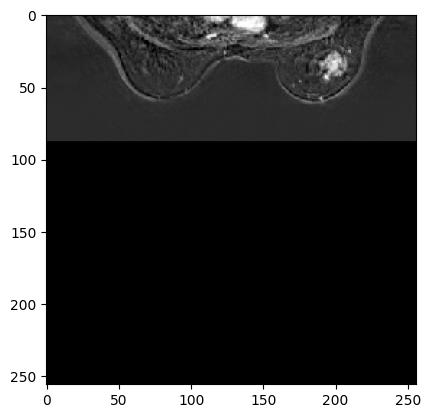

In [37]:
i = next(iter(train_loader_no_thorax_third_sub))["image"]
print(i.shape)
plt.imshow(i[0,0], cmap='gray')

In [38]:
test_loader_no_thorax_third_sub = DataLoader(test_ds_no_thorax_third_sub, batch_size=batch_size, worker_init_fn=seed_worker,
    generator=g, shuffle=False, drop_last=False)

# Dataloader Viz

In [39]:
batch_size = 8

try_loader = DataLoader(train_ds_no_thorax_third_sub, batch_size=batch_size, worker_init_fn=seed_worker,
    generator=g, shuffle=False, drop_last=False)

it = iter(try_loader)

In [40]:
data1 = next(it)

In [41]:
print(data1["image"].shape)

torch.Size([8, 1, 256, 256])


metatensor(1.)
image shape: torch.Size([256, 256, 1]), label shape: torch.Size([256, 256])


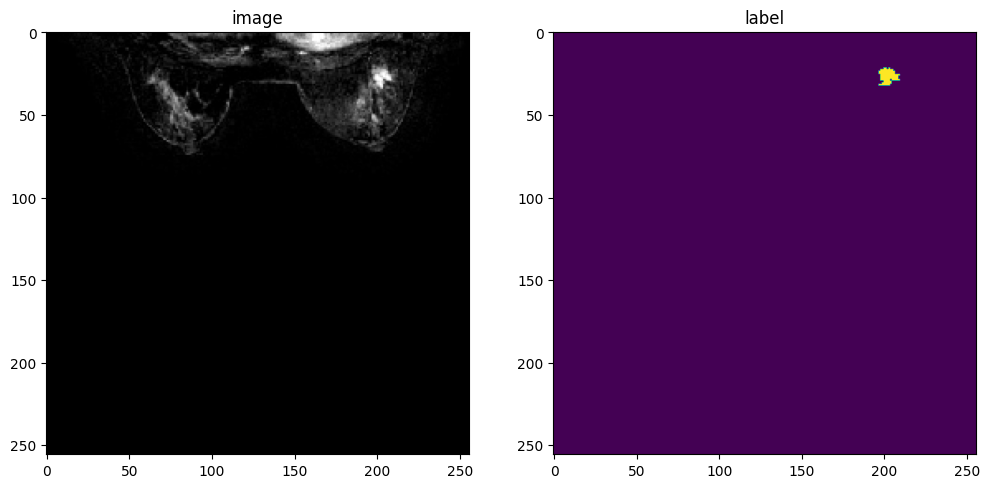

BreaDM\seg\train\images\BreaDM-Be-1801\SUB2\p-032.jpg
(369, 369)


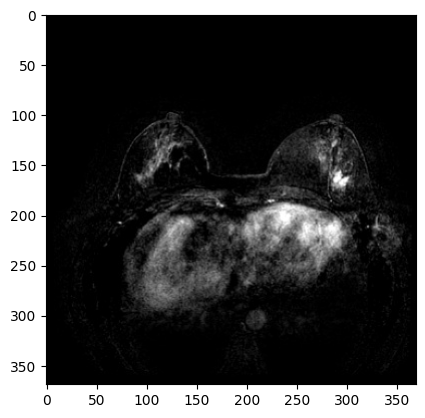

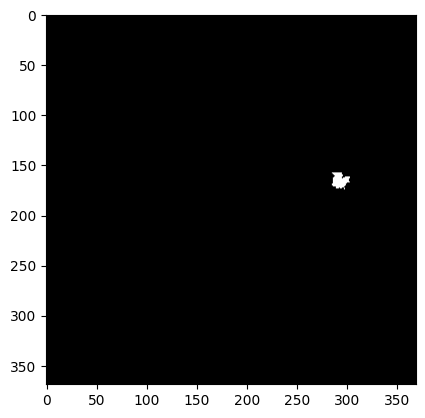

metatensor(1.)
image shape: torch.Size([256, 256, 1]), label shape: torch.Size([256, 256])


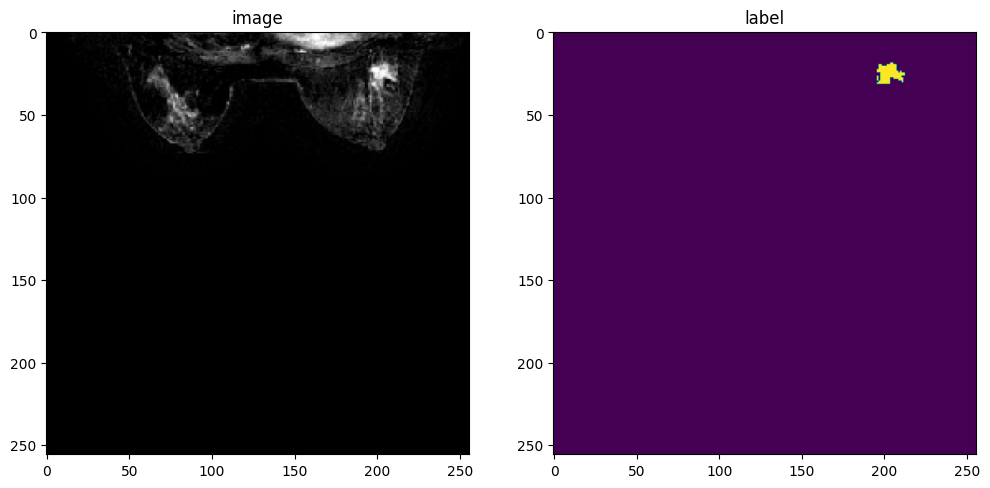

BreaDM\seg\train\images\BreaDM-Be-1801\SUB2\p-033.jpg
(369, 369)


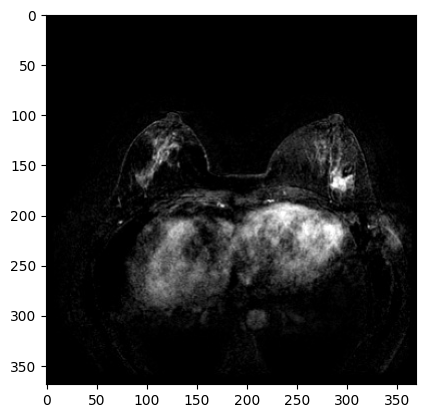

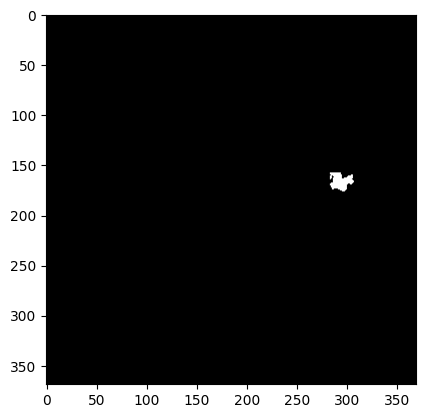

metatensor(1.)
image shape: torch.Size([256, 256, 1]), label shape: torch.Size([256, 256])


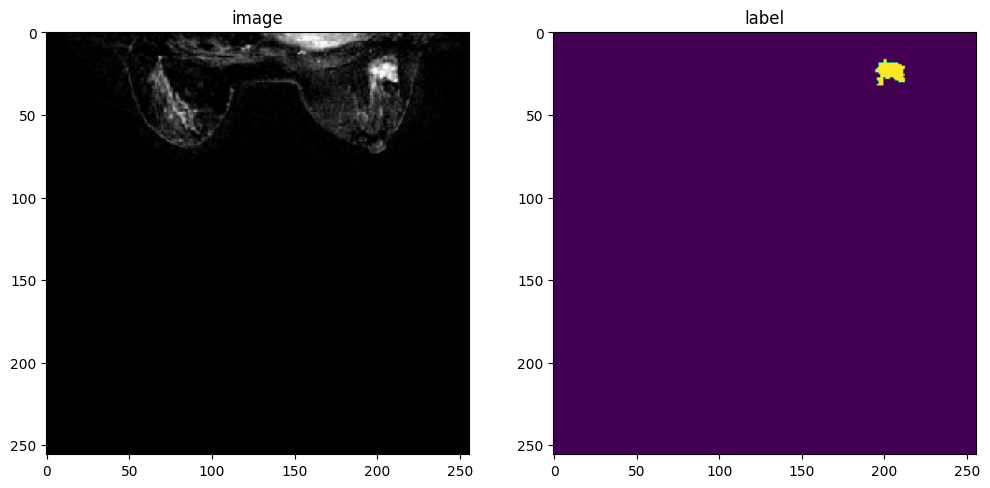

BreaDM\seg\train\images\BreaDM-Be-1801\SUB2\p-034.jpg
(369, 369)


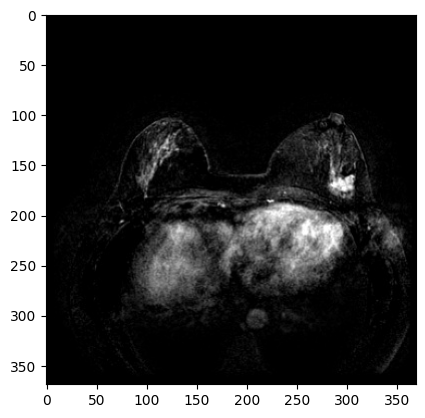

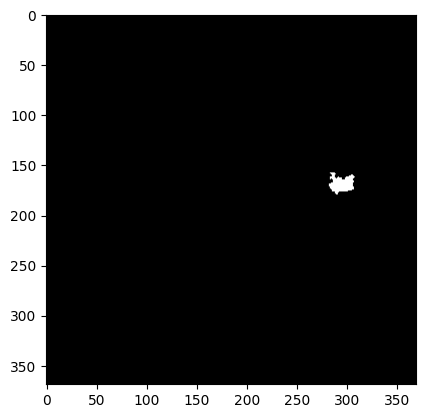

metatensor(1.)
image shape: torch.Size([256, 256, 1]), label shape: torch.Size([256, 256])


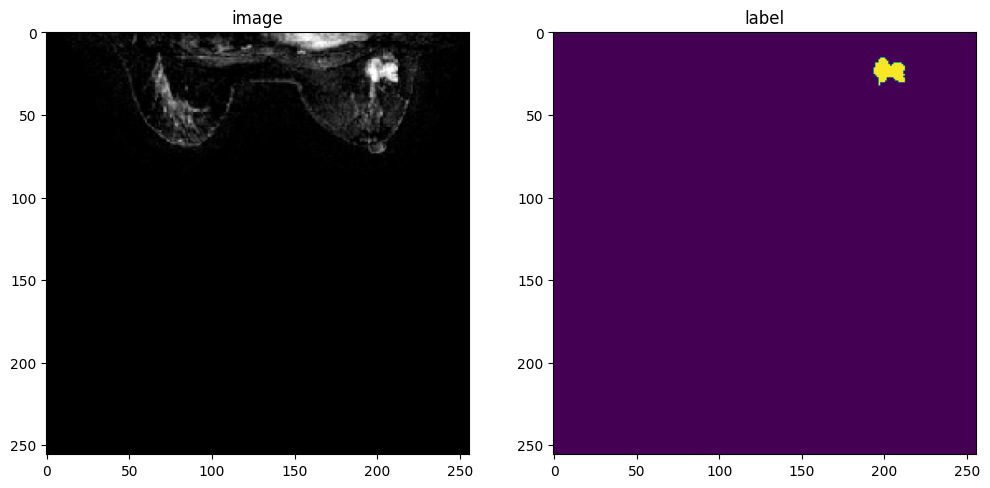

BreaDM\seg\train\images\BreaDM-Be-1801\SUB2\p-035.jpg
(369, 369)


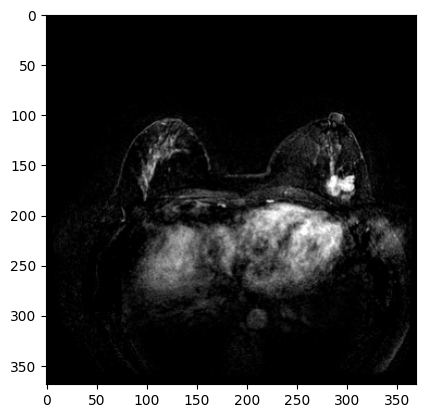

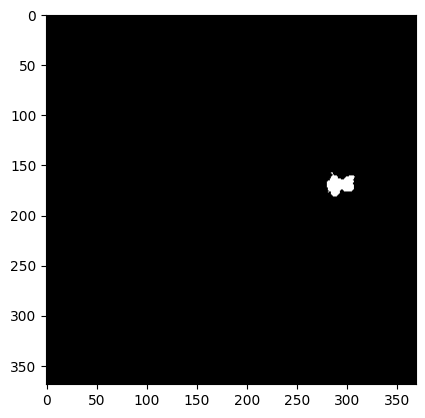

metatensor(1.)
image shape: torch.Size([256, 256, 1]), label shape: torch.Size([256, 256])


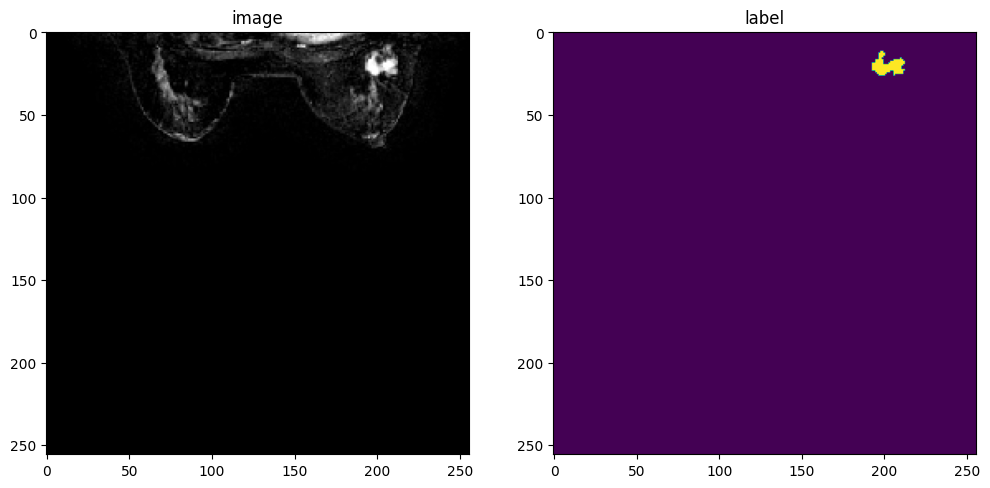

BreaDM\seg\train\images\BreaDM-Be-1801\SUB2\p-036.jpg
(369, 369)


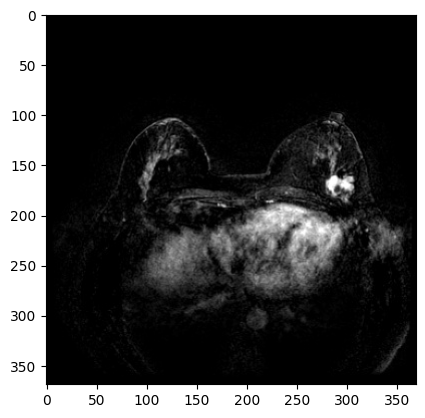

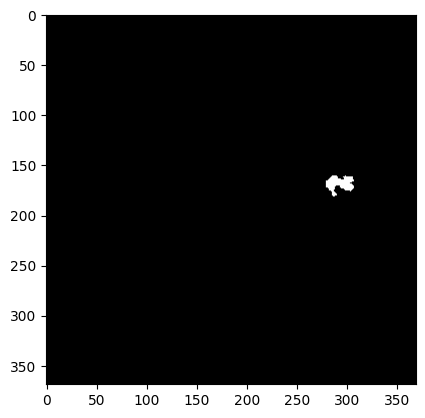

metatensor(1.)
image shape: torch.Size([256, 256, 1]), label shape: torch.Size([256, 256])


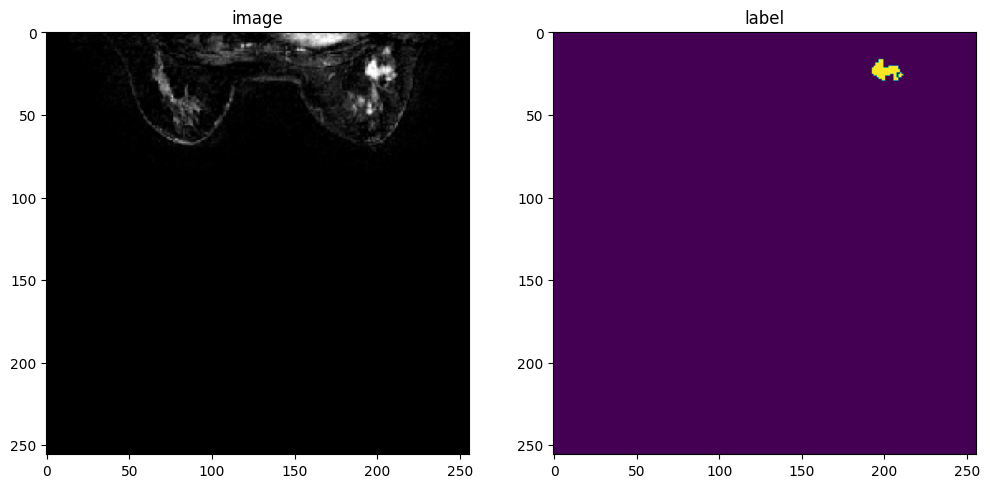

BreaDM\seg\train\images\BreaDM-Be-1801\SUB2\p-037.jpg
(369, 369)


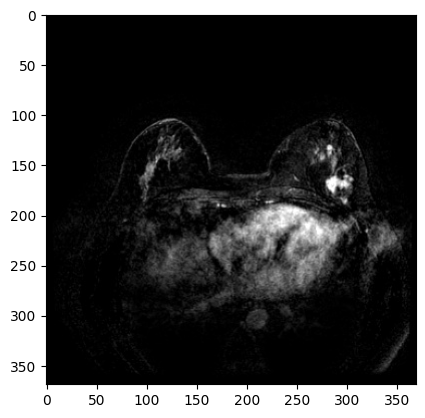

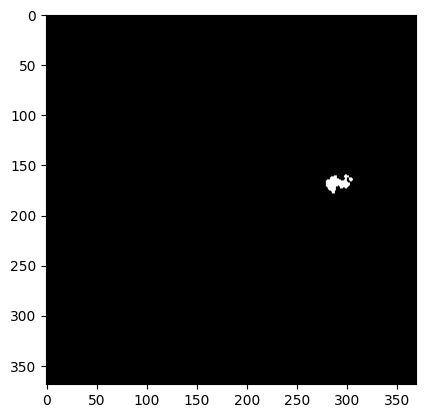

metatensor(1.)
image shape: torch.Size([256, 256, 1]), label shape: torch.Size([256, 256])


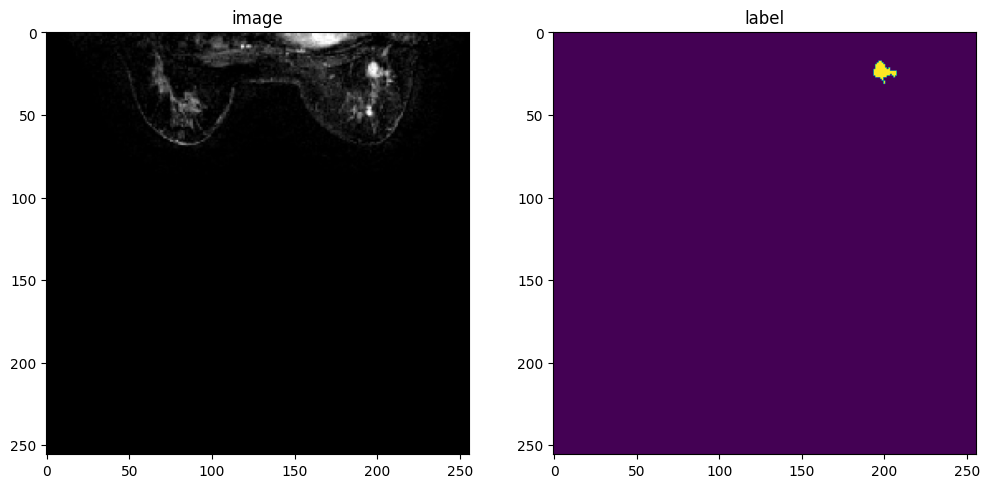

BreaDM\seg\train\images\BreaDM-Be-1801\SUB2\p-038.jpg
(369, 369)


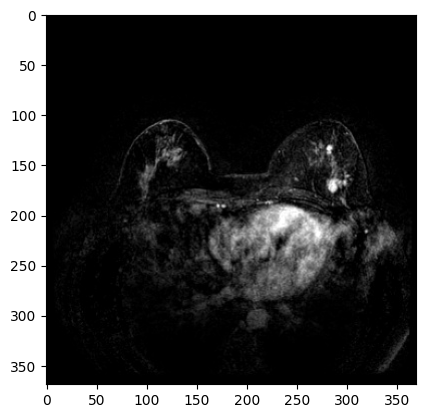

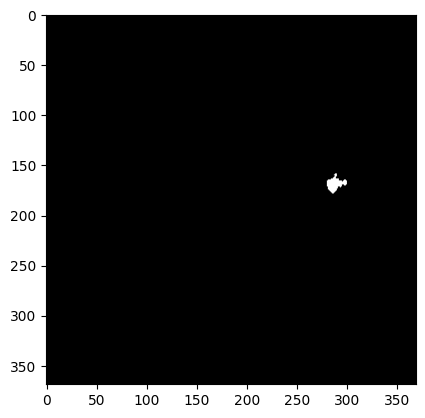

metatensor(1.)
image shape: torch.Size([256, 256, 1]), label shape: torch.Size([256, 256])


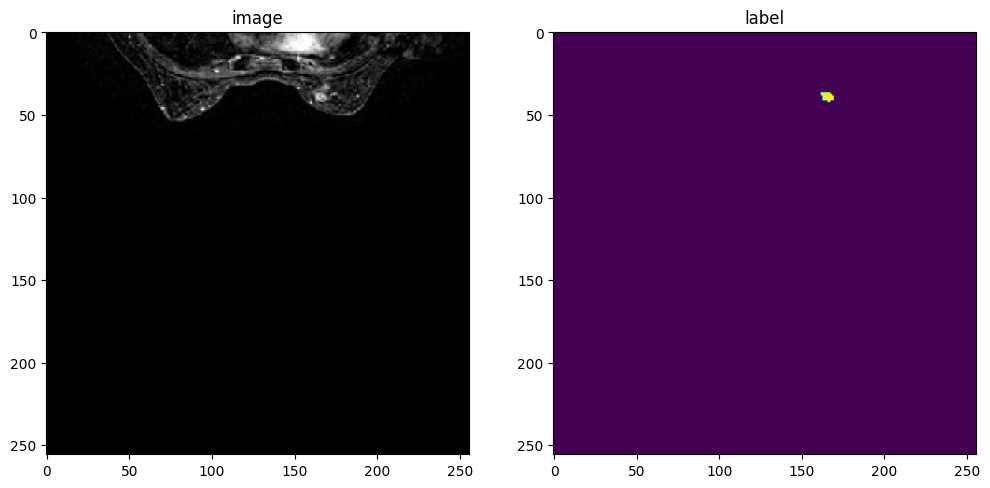

BreaDM\seg\train\images\BreaDM-Be-1803\SUB2\p-035.jpg
(369, 369)


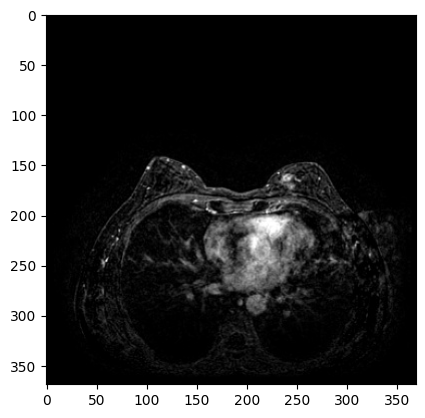

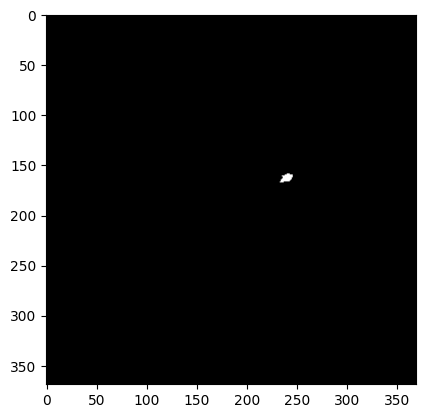

In [42]:
data = data1

for idx in range(8):
    image, label, i_p, l_p = (data["image"][idx], data["label"][idx], data['image_meta_dict']['subtracted_filename_or_obj'][idx], data['label_meta_dict']['subtracted_filename_or_obj'][idx])

    image = image.permute(1,2,0)
    label = label[0]
    print(label.max())

    print(f"image shape: {image.shape}, label shape: {label.shape}")
    plt. figure("check", (12, 6))
    plt.subplot(1, 2, 1)
    plt.title("image")
    plt.imshow(image, cmap='gray')
    plt.subplot(1, 2, 2)
    plt.title("label")
    plt.imshow(label)
    plt.show()

    i = Image.open(i_p)

    print(i_p)
    print(np.array(i).shape)
    plt.imshow(i, cmap='gray')
    plt.show()

    l = Image.open(l_p)

    plt.imshow(l, cmap='gray')
    plt.show()

metatensor(1.)
image shape: torch.Size([256, 256, 1]), label shape: torch.Size([256, 256])


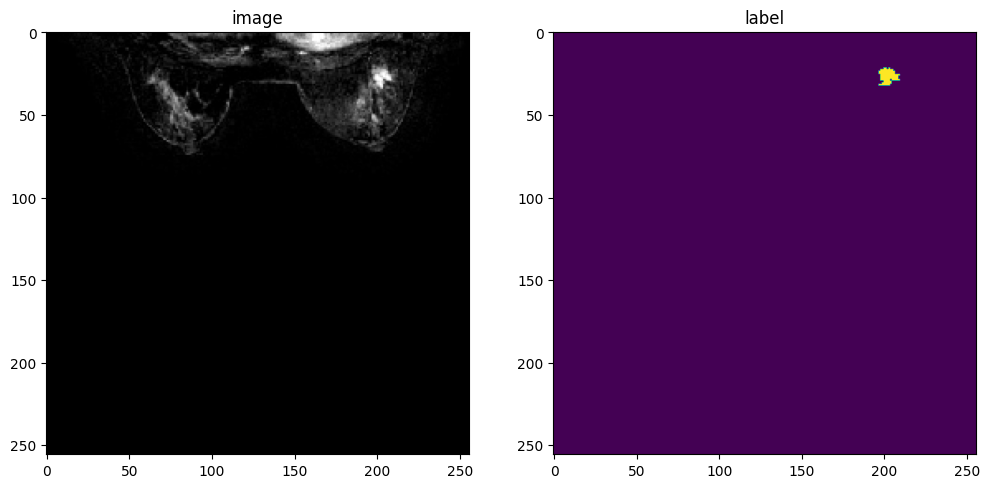

BreaDM\seg\train\images\BreaDM-Be-1801\SUB2\p-032.jpg
(369, 369)


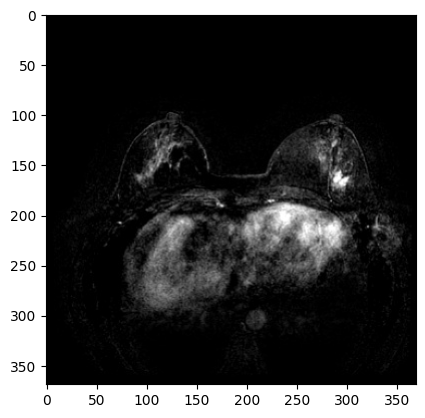

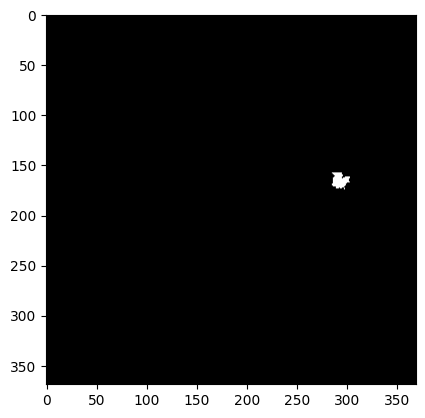

metatensor(1.)
image shape: torch.Size([256, 256, 1]), label shape: torch.Size([256, 256])


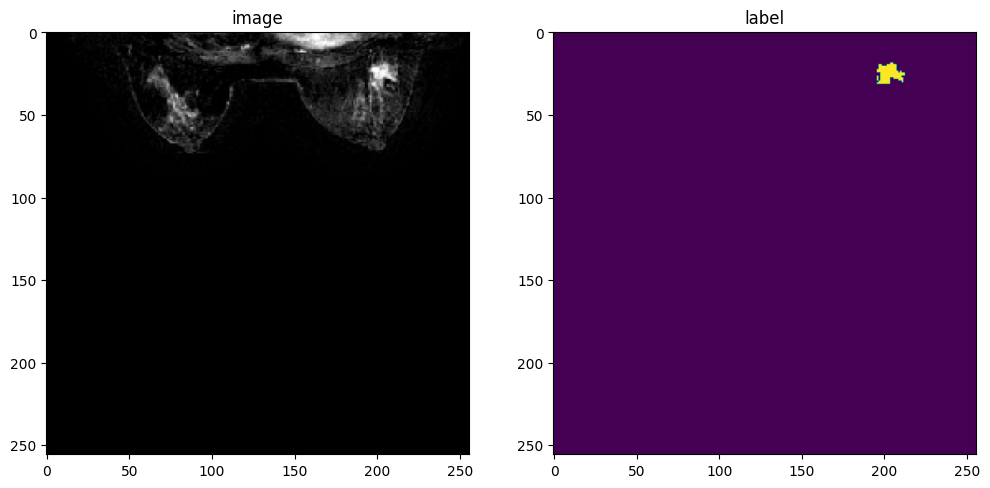

BreaDM\seg\train\images\BreaDM-Be-1801\SUB2\p-033.jpg
(369, 369)


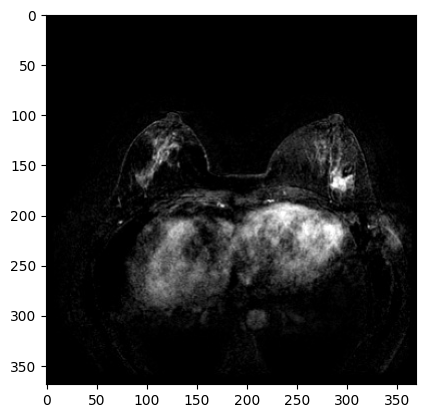

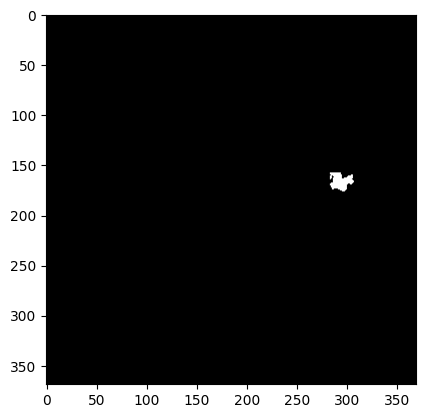

metatensor(1.)
image shape: torch.Size([256, 256, 1]), label shape: torch.Size([256, 256])


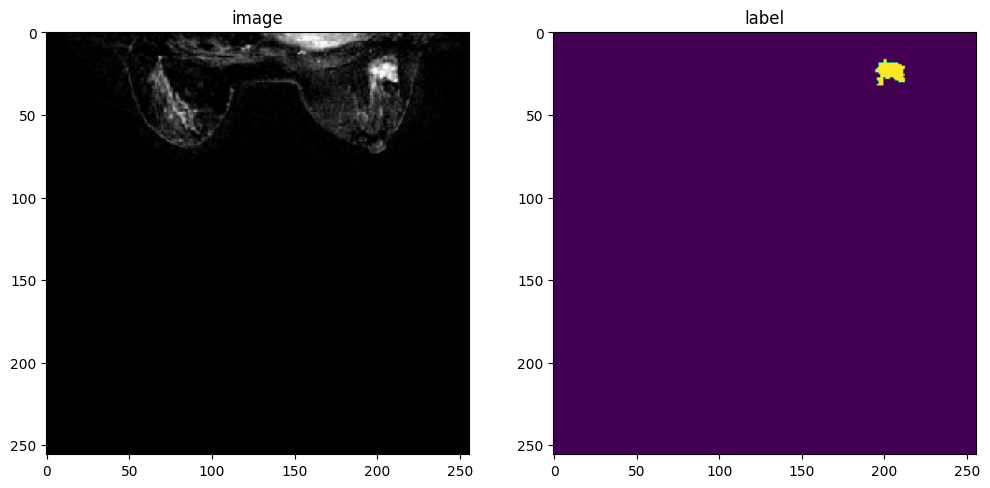

BreaDM\seg\train\images\BreaDM-Be-1801\SUB2\p-034.jpg
(369, 369)


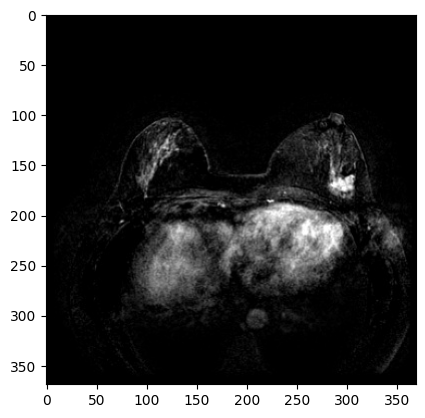

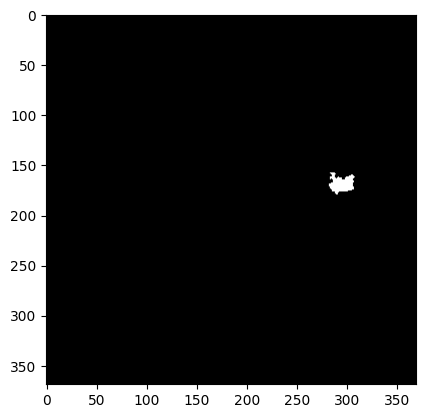

metatensor(1.)
image shape: torch.Size([256, 256, 1]), label shape: torch.Size([256, 256])


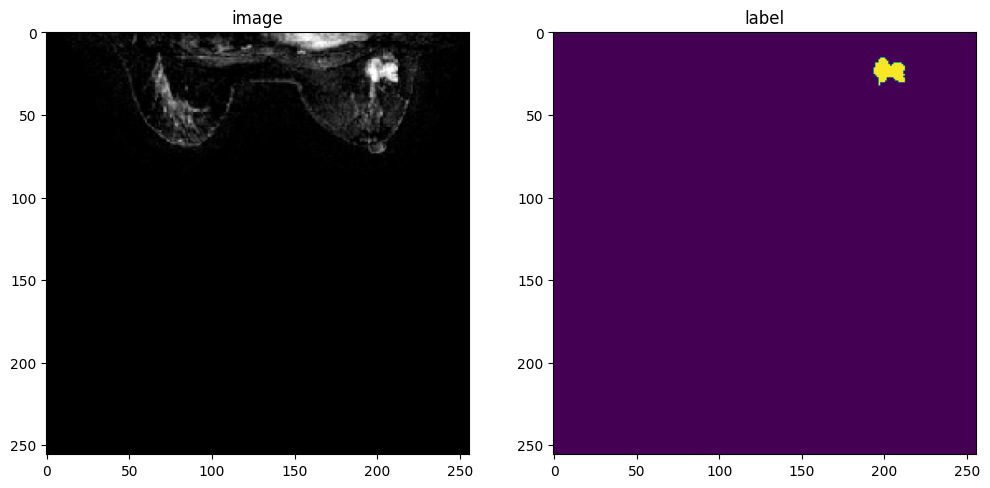

BreaDM\seg\train\images\BreaDM-Be-1801\SUB2\p-035.jpg
(369, 369)


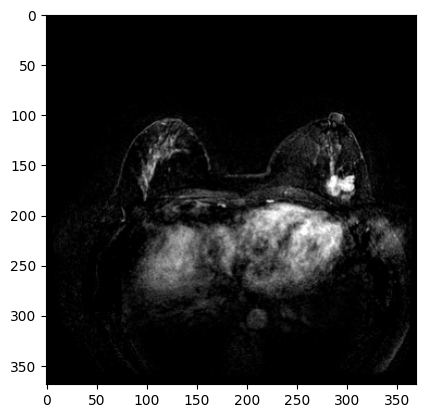

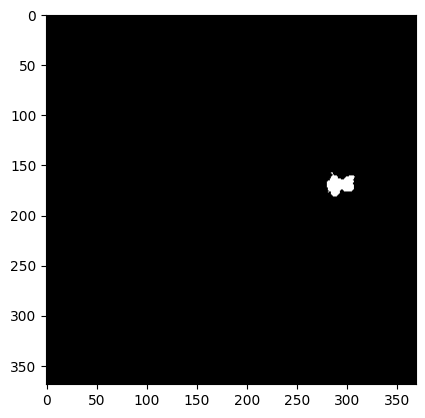

metatensor(1.)
image shape: torch.Size([256, 256, 1]), label shape: torch.Size([256, 256])


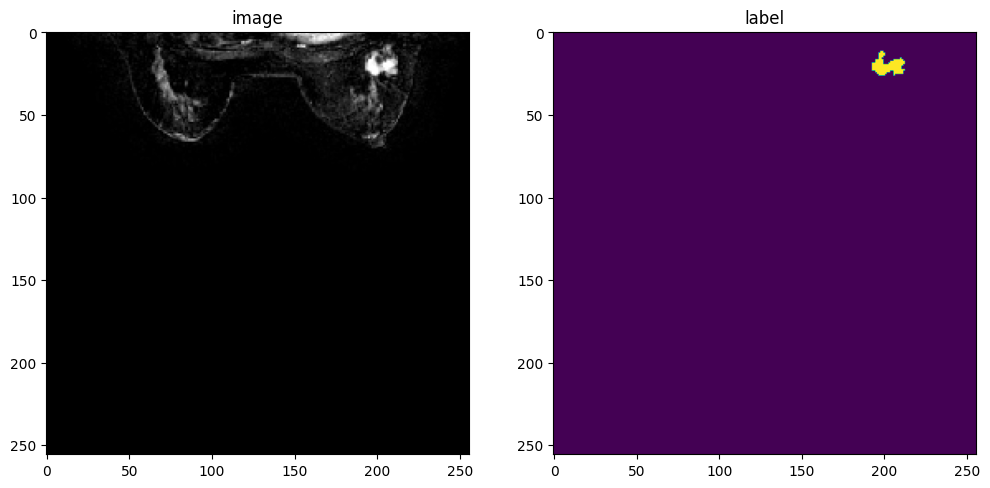

BreaDM\seg\train\images\BreaDM-Be-1801\SUB2\p-036.jpg
(369, 369)


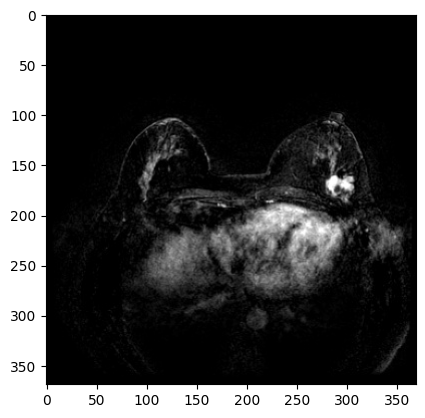

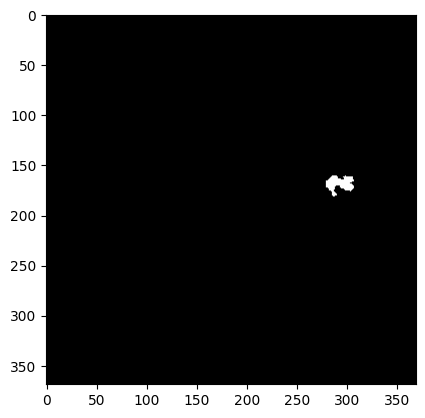

metatensor(1.)
image shape: torch.Size([256, 256, 1]), label shape: torch.Size([256, 256])


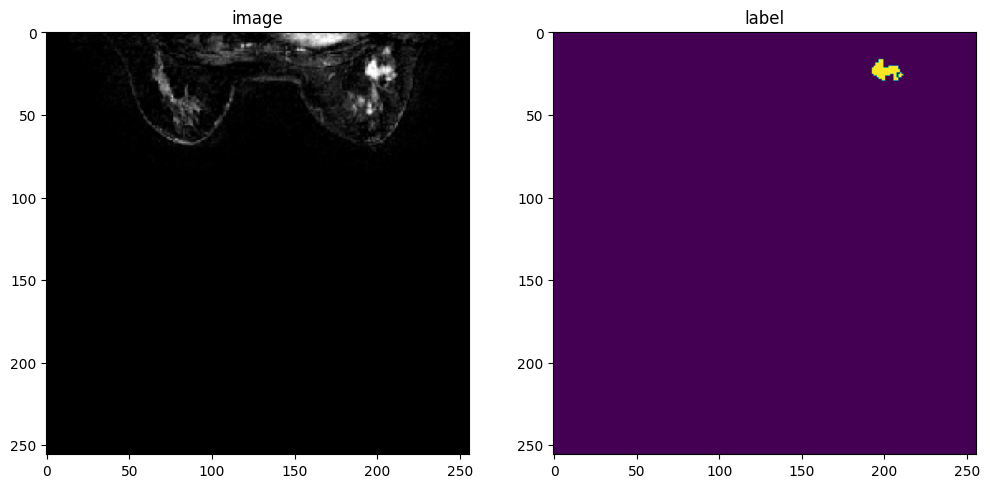

BreaDM\seg\train\images\BreaDM-Be-1801\SUB2\p-037.jpg
(369, 369)


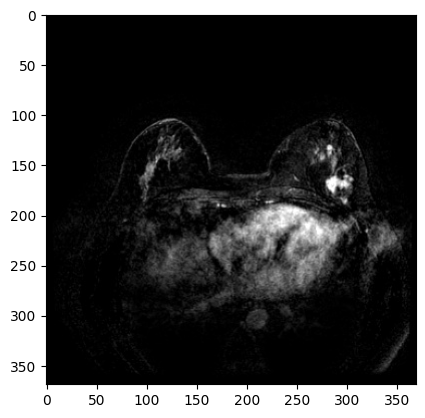

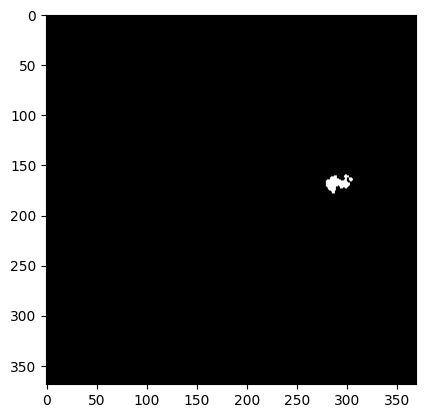

metatensor(1.)
image shape: torch.Size([256, 256, 1]), label shape: torch.Size([256, 256])


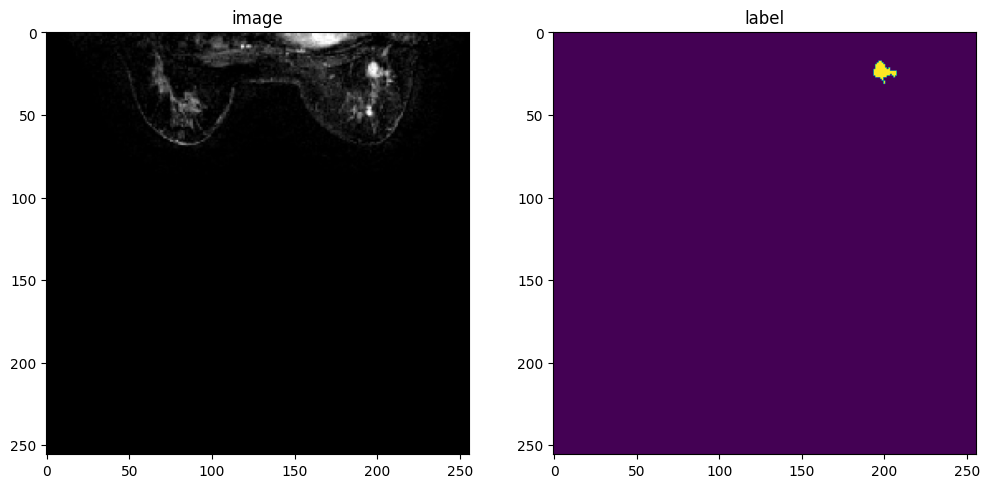

BreaDM\seg\train\images\BreaDM-Be-1801\SUB2\p-038.jpg
(369, 369)


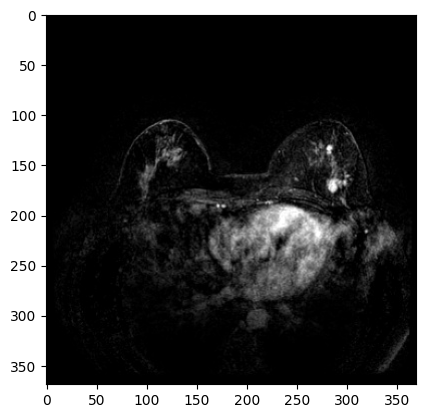

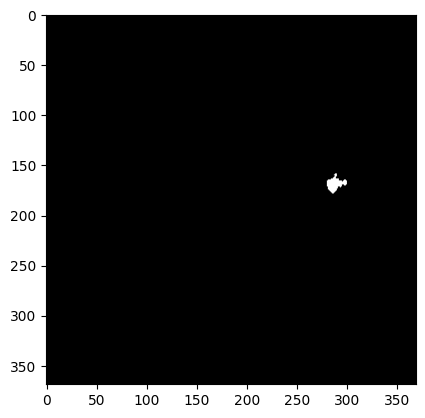

metatensor(1.)
image shape: torch.Size([256, 256, 1]), label shape: torch.Size([256, 256])


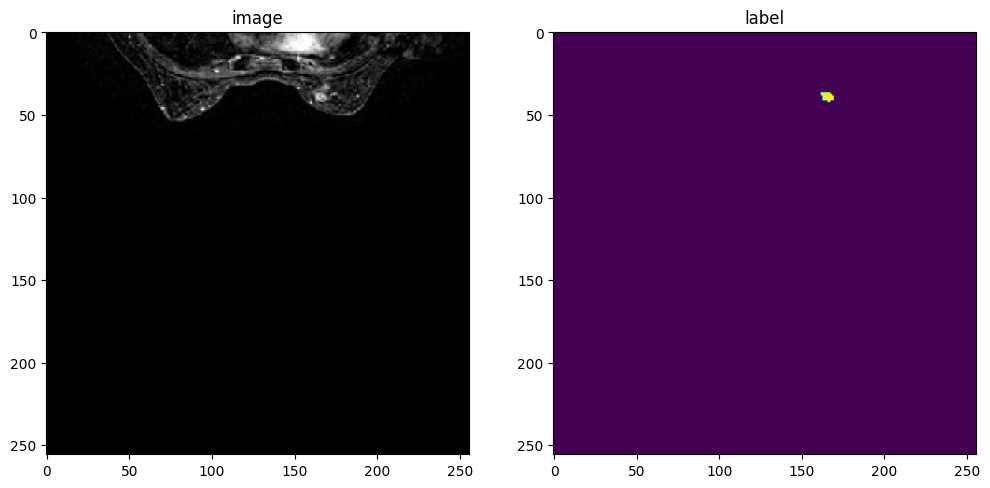

BreaDM\seg\train\images\BreaDM-Be-1803\SUB2\p-035.jpg
(369, 369)


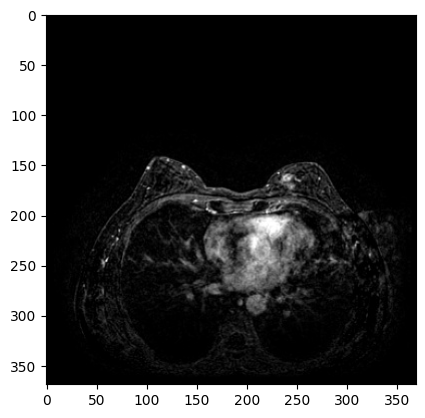

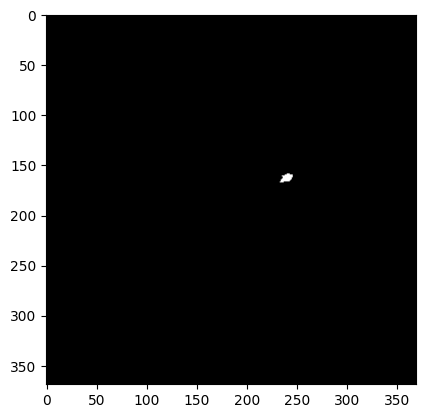

In [43]:
data = data1

for idx in range(8):
    image, label, i_p, l_p = (data["image"][idx], data["label"][idx], data['image_meta_dict']['subtracted_filename_or_obj'][idx], data['label_meta_dict']['subtracted_filename_or_obj'][idx])

    image = image.permute(1,2,0)
    label = label[0]
    print(label.max())

    print(f"image shape: {image.shape}, label shape: {label.shape}")
    plt. figure("check", (12, 6))
    plt.subplot(1, 2, 1)
    plt.title("image")
    plt.imshow(image, cmap='gray')
    plt.subplot(1, 2, 2)
    plt.title("label")
    plt.imshow(label)
    plt.show()

    i = Image.open(i_p)

    print(i_p)
    print(np.array(i).shape)
    plt.imshow(i, cmap='gray')
    plt.show()

    l = Image.open(l_p)

    plt.imshow(l, cmap='gray')
    plt.show()

# Losses & Metrics

In [ ]:
def compute_dice_from_metrics(tp, fp, tn, fn, reduction='micro', exclude_empty=False):
    dice_denominator = 2 * tp + fp + fn
    dice_numerator = 2 * tp

    if reduction == 'micro':
        dice_score = dice_numerator.sum() / dice_denominator.sum()
    elif reduction == 'micro-imagewise':
        dice_per_sample = dice_numerator / dice_denominator
        if exclude_empty:
            dice_per_sample = torch.where(dice_denominator == 0, torch.tensor(float('nan')), dice_per_sample)
            dice_score = torch.nanmean(dice_per_sample)
        else:
            dice_per_sample = torch.where(dice_denominator == 0, 1, dice_per_sample)
            dice_score = torch.nanmean(dice_per_sample)
    elif reduction == 'none':
        dice_score = dice_numerator / dice_denominator
        if exclude_empty:
            dice_score = torch.where(dice_denominator == 0, torch.tensor(float('nan')), dice_score)
        else:
            dice_score = torch.where(dice_denominator == 0, 1, dice_score)
    else:
        raise ValueError("Reduction method must be either 'micro', 'micro-imagewise', or 'none'.")

    # Ensure Dice scores are within the [0, 1] range
    dice_score = torch.clamp(dice_score, min=0, max=1)

    return dice_score

                  

def compute_iou_from_metrics(tp, fp, tn, fn, reduction='micro', exclude_empty=False):
    denominator = tp + fp + fn
    with torch.no_grad():  # Avoid tracking these operations in the autograd graph
        if reduction == 'micro':
            # Sum the counts across all samples and compute IoU
            iou = tp.sum() / (denominator.sum())
        elif reduction == 'micro-imagewise':
            # Avoid division by zero; set IoU to NaN for samples with denominator == 0
            valid = denominator != 0
            iou_per_sample = torch.zeros_like(tp, dtype=torch.float)
            iou_per_sample[valid] = tp[valid] / denominator[valid]
            if exclude_empty:
                iou = torch.mean(iou_per_sample[valid])  # Only consider valid samples
            else:
                iou_per_sample[~valid] = torch.tensor(1.0)  # Set invalid samples to 1
                iou = torch.mean(iou_per_sample)
        elif reduction == 'none':
            # Compute IoU for each sample, handling division by zero
            iou = torch.zeros_like(tp, dtype=torch.float)
            valid = denominator != 0
            iou[valid] = tp[valid] / denominator[valid]
            if exclude_empty:
                iou[~valid] = torch.tensor(float('nan'))  # Mark invalid samples as NaN
            else:
                # Optionally: Set a default value for invalid samples if not excluding them
                iou[~valid] = torch.tensor(1.0)
        else:
            raise ValueError("Reduction method must be either 'micro', 'micro-imagewise', or 'none'.")

    return iou



def compute_iou(y_true, y_pred, class_id, reduction='micro', exclude_empty=False):
    """
    Compute Intersection over Union for a specific class

    Args:
    y_true (torch.Tensor): batch of ground truth, 4D tensor (first dimension is batch size)
    y_pred (torch.Tensor): batch of prediction, 4D tensor (first dimension is batch size)
    class_id (int): the class to compute IoU for
    reduction (str): the method of reduction across the batch, can be 'micro' or 'micro image-wise'

    Returns:
    torch.Tensor: IoU score
    """

    def compute_iou_single(y_true_single, y_pred_single, class_id_single, exclude_empty=False):
        y_true_class = torch.where(y_true_single == class_id_single, 1, 0)
        y_pred_class = torch.where(y_pred_single == class_id_single, 1, 0)

        intersection = torch.logical_and(y_true_class, y_pred_class)
        union = torch.logical_or(y_true_class, y_pred_class)

        union_sum = torch.sum(union)
        if union_sum == 0:
            if exclude_empty:
                iou_score = float('nan')
            else:
                iou_score = 1.0
        else:
            iou_score = torch.sum(intersection).float() / union_sum.float()

        return iou_score

    assert reduction in ['micro', 'micro_image_wise'], "Reduction method should be either 'micro' or 'micro_image_wise'"

    if reduction == 'micro':
        y_true = y_true.view(-1)
        y_pred = y_pred.view(-1)
        return torch.tensor(compute_iou_single(y_true, y_pred, class_id,exclude_empty)).float()

    elif reduction == 'micro_image_wise':
        iou_scores = torch.tensor([compute_iou_single(y, p, class_id, exclude_empty) for y, p in zip(y_true, y_pred)], dtype=torch.float32)
        return torch.nanmean(iou_scores)  # Using nanmean to ignore NaN values



def compute_dice_score(y_true, y_pred, class_id=1, reduction='micro', exclude_empty=False):
    """
    Compute Dice Score for a specific class with reduction options, for input tensors in HxWxB format using PyTorch.
    
    Args:
    y_true (torch.Tensor): Ground truth, a 3D tensor (height, width, batch size).
    y_pred (torch.Tensor): Predictions, a 3D tensor (height, width, batch size).
    class_id (int): The class ID for which to compute the Dice Score.
    reduction (str): Method of reduction across the batch, either 'micro' or 'micro_image_wise'.
    
    Returns:
    torch.Tensor: The Dice Score.
    """

    def compute_dice_score_single(y_true_single, y_pred_single, class_id_single, exclude_empty=False):
        y_true_class = (y_true_single == class_id_single).float()
        y_pred_class = (y_pred_single == class_id_single).float()

        intersection = torch.sum(y_true_class * y_pred_class)
        union = torch.sum(y_true_class) + torch.sum(y_pred_class)

        if union == 0:
            if exclude_empty:
                dice_score = torch.tensor(float('nan'))  # Assuming need to handle NaN explicitly
            else:
                dice_score = torch.tensor(1.0)  # Assuming perfect IoU score when both prediction and GT are empty
        else:
            dice_score = (2. * intersection) / (union)
        
        return dice_score

    if reduction == 'micro':
        y_true_flat = y_true.view(-1)
        y_pred_flat = y_pred.view(-1)
        dice_score = torch.tensor(compute_dice_score_single(y_true_flat, y_pred_flat, class_id, exclude_empty)).float()
        return dice_score

    elif reduction == 'micro_image_wise':
        dice_scores = torch.tensor([compute_dice_score_single(y, p, class_id, exclude_empty) for y, p in zip(y_true, y_pred)], dtype=torch.float32)
        return torch.nanmean(dice_scores)  # Using nanmean to ignore NaN values in case of empty classes

    else:
        raise ValueError("Reduction method should be either 'micro' or 'micro_image_wise'")

def compute_mean_precision(tp, fp, fn, tn):
    """
    Compute the mean precision for binary classification across two classes.

    Args:
        tp (torch.Tensor): True Positives, tensor of shape (B, 1).
        fp (torch.Tensor): False Positives, tensor of shape (B, 1).
        tn (torch.Tensor): True Negatives, tensor of shape (B, 1).
        fn (torch.Tensor): False Negatives, tensor of shape (B, 1).

    Returns:
        torch.Tensor: The mean precision across classes.
    """

    # Precision for class 1
    precision_class_1 = torch.div(tp, tp + fp)
    precision_class_1[torch.isnan(precision_class_1)] = 1  # Handle division by zero

    # Precision for class 0 (inverting perspective)
    precision_class_0 = torch.div(tn, tn + fn)
    precision_class_0[torch.isnan(precision_class_0)] = 1  # Handle division by zero

    # Mean precision across both classes
    mean_precision = (precision_class_1 + precision_class_0) / 2

    # Average across the batch
    mean_precision = torch.mean(mean_precision)

    return mean_precision

def compute_mean_recall(tp, fp, fn, tn):
    """
    Compute the mean recall for binary classification across two classes.

    Args:
        tp (torch.Tensor): True Positives, tensor of shape (B, 1).
        fp (torch.Tensor): False Positives, tensor of shape (B, 1).
        tn (torch.Tensor): True Negatives, tensor of shape (B, 1).
        fn (torch.Tensor): False Negatives, tensor of shape (B, 1).

    Returns:
        torch.Tensor: The mean recall across classes.
    """
    recall_class_1 = torch.div(tp, tp + fn)
    recall_class_1[torch.isnan(recall_class_1)] = 1  # Handle division by zero

    recall_class_0 = torch.div(tn, tn + fp)
    recall_class_0[torch.isnan(recall_class_0)] = 1  # Handle division by zero

    mean_recall = (recall_class_1 + recall_class_0) / 2
    mean_recall = torch.mean(mean_recall)

    return mean_recall


def compute_dice_score_from_cm(tp, fp, fn, tn, reduction='micro', exclude_empty=False):
    # Convert to float for division
    tp = tp.float()
    fp = fp.float()
    fn = fn.float()
    
    if reduction == 'micro':
        # Sum across all classes and samples for micro averaging
        tp_sum = tp.sum()
        fp_sum = fp.sum()
        fn_sum = fn.sum()
        
        # Compute Dice score, handling division by zero
        denominator = 2 * tp_sum + fp_sum + fn_sum
        dice_score = 2 * tp_sum / denominator if denominator != 0 else torch.tensor(1.0)
        
    elif reduction == 'micro-imagewise':
        # Compute Dice Score per sample, then average across samples
        denominator = 2 * tp + fp + fn
        valid = denominator != 0
        dice_scores = torch.zeros_like(tp)
        dice_scores[valid] = 2 * tp[valid] / denominator[valid]

        if exclude_empty:
            dice_scores[~valid] = torch.tensor(float('nan'))  # Assuming perfect score for invalid cases
            dice_score = dice_scores.nanmean(dim=0)  # Average across samples
        else:
            dice_scores[~valid] = torch.tensor(1.0)  # Assuming perfect score for invalid cases
            dice_score = dice_scores.mean(dim=0)  # Average across samples
        
    else:
        raise ValueError("Reduction method must be either 'micro' or 'micro-imagewise'")
    
    return dice_score

def ra_iou(tp, fp, fn, beta=0.5):
    
    ra_iou = tp / (tp + beta * fn + fp + 1e-6)  # Adding epsilon to avoid division by zero
    
    return ra_iou.mean()

# Helper function to identify the axis for aggregation
def identify_axis(shape):
    if len(shape) == 5:
        return [2, 3, 4]
    elif len(shape) == 4:
        return [2, 3]
    else:
        raise ValueError('Shape of tensor is neither 2D or 3D.')

# Asymmetric Focal Loss for single-channel output
class AsymmetricFocalLoss(nn.Module):
    def __init__(self, delta=0.7, gamma=2., epsilon=1e-07):
        super(AsymmetricFocalLoss, self).__init__()
        self.delta = delta
        self.gamma = gamma
        self.epsilon = epsilon

    def forward(self, logits, y_true):
        y_pred = torch.sigmoid(logits)  # Applying sigmoid to convert logits to probabilities
        y_pred = torch.clamp(y_pred, self.epsilon, 1. - self.epsilon)
        cross_entropy = -y_true * torch.log(y_pred) - (1 - y_true) * torch.log(1 - y_pred)

        # Calculate the loss for positive and negative classes
        pos_loss = torch.pow(1 - y_pred, self.gamma) * cross_entropy
        neg_loss = torch.pow(y_pred, self.gamma) * cross_entropy

        # Weighted sum of the losses
        loss = torch.mean((self.delta * pos_loss) + ((1 - self.delta) * neg_loss))
        return loss

# Asymmetric Focal Tversky Loss for single-channel output
class AsymmetricFocalTverskyLoss(nn.Module):
    def __init__(self, delta=0.7, gamma=0.75, epsilon=1e-07):
        super(AsymmetricFocalTverskyLoss, self).__init__()
        self.delta = delta
        self.gamma = gamma
        self.epsilon = epsilon

    def forward(self, logits, y_true):
        y_pred = torch.sigmoid(logits)  # Applying sigmoid to convert logits to probabilities
        y_pred = torch.clamp(y_pred, self.epsilon, 1. - self.epsilon)
        axis = identify_axis(y_true.size())

        tp = torch.sum(y_true * y_pred, axis=axis)
        fn = torch.sum(y_true * (1 - y_pred), axis=axis)
        fp = torch.sum((1 - y_true) * y_pred, axis=axis)

        tversky_index = (tp + self.epsilon) / (tp + self.delta * fn + (1 - self.delta) * fp + self.epsilon)
        loss = (1 - tversky_index) * torch.pow(1 - tversky_index, -self.gamma)

        return torch.mean(loss)

# Asymmetric Unified Focal Loss for single-channel output
class AsymmetricUnifiedFocalLoss(nn.Module):
    def __init__(self, weight=0.5, delta=0.6, gamma=0.2):
        super(AsymmetricUnifiedFocalLoss, self).__init__()
        self.weight = weight
        self.delta = delta
        self.gamma = gamma

    def forward(self, logits, y_true):
        asymmetric_ftl = AsymmetricFocalTverskyLoss(delta=self.delta, gamma=self.gamma)(logits, y_true)
        asymmetric_fl = AsymmetricFocalLoss(delta=self.delta, gamma=self.gamma)(logits, y_true)

        if self.weight is not None:
            return (self.weight * asymmetric_ftl) + ((1 - self.weight) * asymmetric_fl)
        else:
            return asymmetric_ftl + asymmetric_fl

class SurfaceLossBinary(nn.Module):
    def __init__(self, idc):
        super(SurfaceLossBinary, self).__init__()
        # Self.idc is used to filter out some classes of the target mask. Use fancy indexing
        self.idc = idc
        print(f"Initialized {self.__class__.__name__} with {idc}")

    def forward(self, probs, dist_maps):

        pc = probs[:, 0, ...].type(torch.float32) # torch.Size([1, 256])
        dc = dist_maps[:, 1, ...].type(torch.float32)

        

        multipled = einsum("bwh,bwh->bwh", pc, dc)

        loss = multipled.mean()

        return loss

class CABFL(nn.Module):
    def __init__(self, idc, weight_aufl=0.5, delta=0.6, gamma=0.2):
        super(CABFL, self).__init__()
        self.boundaryLoss = SurfaceLossBinary(idc=idc)
        self.aufl =  AsymmetricUnifiedFocalLoss(delta=delta, gamma=gamma, weight=weight_aufl)
        self.alpha = 0.01
        self.current_epoch = 0

    def norm_distmap(self,distmap):
        _m: float = torch.abs(distmap).max()
        return distmap / _m

    def forward(self, logits, probs, dist_maps, gts, current_epoch):
        if current_epoch != self.current_epoch:
            self.current_epoch = current_epoch
            self.alpha = min(self.alpha+0.01, 0.99)

        bl = self.boundaryLoss(probs, self.norm_distmap(dist_maps))
        aufl = self.aufl(logits, gts)
        
        return (1-self.alpha)*aufl + self.alpha*bl

def compute_dice_score_npy(y_true, y_pred, class_id=1, reduction='micro',exclude_empty=False):
    """
    Compute Dice Score for a specific class with reduction options, for input arrays in HxWxB format using NumPy.
    
    Args:
    y_true (np.array): Ground truth, a 3D array (height, width, batch size).
    y_pred (np.array): Predictions, a 3D array (height, width, batch size).
    class_id (int): The class ID for which to compute the Dice Score.
    reduction (str): Method of reduction across the batch, either 'micro' or 'micro-imagewise'.
    
    Returns:
    float: The Dice Score.
    """

    def compute_dice_score_single(y_true_single, y_pred_single, class_id_single, exclude_empty=False):
        y_true_class = (y_true_single == class_id_single).astype(np.float32)
        y_pred_class = (y_pred_single == class_id_single).astype(np.float32)

        intersection = np.sum(y_true_class * y_pred_class)
        union = np.sum(y_true_class) + np.sum(y_pred_class)

        if union == 0:
            # Both prediction and ground truth are empty for this class
            if exclude_empty:
                dice_score =  float('nan')
            else:
                dice_score= torch.tensor(1.0)  # Assuming perfect IoU score when both prediction and GT are empty
        else:
            dice_score = (2. * intersection) / (union)  # Adding epsilon to avoid division by zero
        
        return dice_score

    if reduction == 'micro':
        # Reshape to combine height, width, and batch into a single dimension
        y_true_flat = y_true.reshape(-1)
        y_pred_flat = y_pred.reshape(-1)
        dice_score = compute_dice_score_single(y_true_flat, y_pred_flat, class_id, exclude_empty)
        return dice_score

    elif reduction == 'micro-imagewise':
        # Compute Dice Score for each image separately and then average
        dice_scores = np.array([compute_dice_score_single(y_true[:, :, i], y_pred[:, :, i], class_id,exclude_empty) for i in range(y_true.shape[2])])
        return np.nanmean(dice_scores)  # Using nanmean to ignore NaN values in case of empty classes

    else:
        raise ValueError("Reduction method should be either 'micro' or 'micro-imagewise'")

def compute_iou_npy(y_true, y_pred, class_id=1, reduction='micro', exclude_empty=False):
    """
    Compute Intersection over Union for a specific class using NumPy.

    Args:
    y_true (np.ndarray): batch of ground truth, 4D tensor (first dimension is batch size)
    y_pred (np.ndarray): batch of prediction, 4D tensor (first dimension is batch size)
    class_id (int): the class to compute IoU for
    reduction (str): the method of reduction across the batch, can be 'micro' or 'micro-imagewise'

    Returns:
    np.ndarray: IoU score
    """

    def compute_iou_single(y_true_single, y_pred_single, class_id_single, exclude_empty=False):
        y_true_class = np.where(y_true_single == class_id_single, 1, 0)
        y_pred_class = np.where(y_pred_single == class_id_single, 1, 0)

        intersection = np.logical_and(y_true_class, y_pred_class)
        union = np.logical_or(y_true_class, y_pred_class)

        union_sum = np.sum(union)
        if union_sum == 0:
            # Both prediction and ground truth are empty
            if exclude_empty:
                iou_score = float('nan')
            else:
                iou_score = 1.0
        else:
            iou_score = np.sum(intersection).astype(float) / union_sum.astype(float)

        return iou_score

    assert reduction in ['micro', 'micro-imagewise'], "Reduction method should be either 'micro' or 'micro_image_wise'"

    if reduction == 'micro':
        y_true = y_true.reshape(-1)
        y_pred = y_pred.reshape(-1)
        return compute_iou_single(y_true, y_pred, class_id, exclude_empty)

    elif reduction == 'micro-imagewise':
        iou_scores = np.array([compute_iou_single(y, p, class_id, exclude_empty) for y, p in zip(y_true, y_pred)], dtype=np.float32)
        return np.nanmean(iou_scores)  # Using nanmean to ignore NaN values

def select_slices_based_on_gt(gt_volume, pred_volume):
    # Select slices with positive pixels in ground truth
    positive_slices = (gt_volume > 0)
    return gt_volume[positive_slices], pred_volume[positive_slices]

def compute_classwise_volumetric_iou(gt_volume, pred_volume, num_classes, exclude_empty=False):
    # Initialize IoU scores for each class
    iou_scores = np.zeros(num_classes)

    for class_id in range(num_classes):
        # Consider only voxels belonging to the current class
        gt_class_bool = gt_volume == class_id
        pred_class_bool = pred_volume == class_id

        intersection = np.logical_and(gt_class_bool, pred_class_bool)
        union = np.logical_or(gt_class_bool, pred_class_bool)

        # Calculate IoU, setting it to 1 if the union is zero
        if np.sum(union) == 0:
            if exclude_empty:
                iou_scores[class_id] = float('nan')
            else:
                iou_scores[class_id] = 1.0
        else:
            iou_scores[class_id] = np.sum(intersection) / np.sum(union)

    return iou_scores


def ra_iou(tp, fp, fn, beta=0.5):
    
    ra_iou = tp / (tp + beta * fn + fp + 1e-6)  # Adding epsilon to avoid division by zero
    
    return ra_iou.mean()

### SoftDiceLoss

In [45]:
import torch
import torch.nn as nn

class SoftDiceLoss(nn.Module):
    """
    Soft Dice loss for binary (single-channel) segmentation.
    Expects predictions of shape (B, 1, H, W) already in [0,1].
    Expects ground truth of shape (B, 1, H, W), either 0/1 or float in [0,1].
    """
    def __init__(self, smooth=1e-6):
        super().__init__()
        self.smooth = smooth

    def forward(self, logits, targets):
        """
        Args:
            probs: model outputs as probabilities in [0,1], (B, 1, H, W)
            targets: ground truth masks, (B, 1, H, W) in {0,1} or floats
        Returns:
            Dice loss (scalar).
        """

        probs = logits.sigmoid()
        
        # Flatten: (B, 1, H, W) -> (B, H*W)
        probs_flat = probs.view(probs.size(0), -1)
        targets_flat = targets.view(targets.size(0), -1)

        # Numerator = 2 * Σ (p_i * t_i)
        intersection = 2.0 * torch.sum(probs_flat * targets_flat, dim=1)

        # Denominator = Σ (p_i^2) + Σ (t_i^2)
        denominator = torch.sum(probs_flat * probs_flat, dim=1) + \
                      torch.sum(targets_flat * targets_flat, dim=1)

        # Dice coefficient (per sample), then average over batch
        dice_per_sample = (intersection + self.smooth) / (denominator + self.smooth)
        dice = dice_per_sample.mean()

        # Dice loss = 1 - dice coefficient
        return 1.0 - dice

### FocalTverskyIOULoss (to finish)

In [46]:
class FocalTverskyIOULoss(nn.Module):
    def __init__(self, alpha=0.5, gamma=4/3, weights=[0.25, 0.25, 1]):
        """
        Parameters:
        - alpha: Weight for false negatives in the Tversky loss.
        - gamma: Focusing parameter for the focal Tversky loss.
        - weights: List of weights for the hierarchical decoder outputs.
        """
        super(HybridLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.weights = weights

    def forward(self, outputs, targets):
        """
        Parameters:
        - outputs: List of hierarchical outputs from the decoder. Each element is a tensor of shape (B, C, H, W).
        - targets: Ground truth segmentation mask of shape (B, H, W).

        Returns:
        - Loss value (scalar).
        """
        total_loss = 0.0
        for i, output in enumerate(outputs):
            # Resize targets to match output size
            targets_resized = F.interpolate(targets.unsqueeze(1).float(), size=output.shape[2:], mode='nearest').squeeze(1)

            loss = focal_tversky_loss + iou_loss

            # Weighted sum of losses
            total_loss += self.weights[i] * loss

        return total_loss


# Models

## Modules

In [47]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

class AttentionGate(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super(AttentionGate, self).__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )
        
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x, g):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        return x * psi

class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(EncoderBlock, self).__init__()
        self.conv = ConvBlock(in_channels, out_channels)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.conv(x)
        p = self.pool(x)
        return x, p

class DecoderBlock(nn.Module):
    def __init__(self, in_channels, mid_channels, out_channels, F_int, use_attention=True):
        super(DecoderBlock, self).__init__()
        self.up = nn.ConvTranspose2d(in_channels, mid_channels, kernel_size=2, stride=2)
        # Adjust the attention gate to handle the combined skip connections
        if use_attention:
            self.attention = AttentionGate(F_g=mid_channels, F_l=mid_channels, F_int=F_int)
        self.conv = ConvBlock(mid_channels + mid_channels, out_channels)  # Adjust for concatenated skip connection size
        self.use_attention=use_attention

    def forward(self, x, combined_skip):

        x = self.up(x)
        # Apply attention to the combined skip connections
        if self.use_attention:
            combined_skip = self.attention(x, combined_skip)
        
        x = torch.cat([x, combined_skip], dim=1)
        x = self.conv(x)
        return x
    

class ChannelAttention(nn.Module):
    def __init__(self, in_channels, reduction_ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.fc1 = nn.Linear(in_channels, in_channels // reduction_ratio, bias=False)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Linear(in_channels // reduction_ratio, in_channels, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        b, c, _, _ = x.size()
        avg_pooled = self.avg_pool(x).view(b, c)
        max_pooled = self.max_pool(x).view(b, c)
        avg_out = self.fc2(self.relu(self.fc1(avg_pooled)))
        max_out = self.fc2(self.relu(self.fc1(max_pooled)))
        out = self.sigmoid(avg_out + max_out).view(b, c, 1, 1)
        return x * out
        
class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size=kernel_size, padding=kernel_size // 2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        avg_out = torch.mean(x, dim=1, keepdim=True)
        x = torch.cat([max_out, avg_out], dim=1)
        x = self.conv(x)
        return self.sigmoid(x)

class FeatureFusionBlock(nn.Module):
    def __init__(self, in_channels, out_channels, reduction=16):
        super(FeatureFusionBlock, self).__init__()
        self.channel_attention_local = ChannelAttention(in_channels)
        self.spatial_attention_local = SpatialAttention()

        self.channel_attention_global = ChannelAttention(in_channels)
        self.spatial_attention_global = SpatialAttention()
        
        self.fusion_conv = nn.Conv2d(in_channels*3, out_channels, kernel_size=1)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, global_feat, local_feat1, local_feat2):
        # Apply channel attention to each feature map
        global_ca = global_feat * self.channel_attention_global(global_feat)
        local_ca1 = local_feat1 * self.channel_attention_local(local_feat1)
        local_ca2 = local_feat2 * self.channel_attention_local(local_feat2)

        # Apply spatial attention to each feature map
        global_sa = global_ca * self.spatial_attention_global(global_ca)
        local_sa1 = local_ca1 * self.spatial_attention_local(local_ca1)
        local_sa2 = local_ca2 * self.spatial_attention_local(local_ca2)

        # Concatenate the feature maps
        fused_features = torch.cat((global_sa, local_sa1, local_sa2), dim=1)
        
        # Fuse them using a convolutional layer
        fused_features = self.fusion_conv(fused_features)
        fused_features = self.relu(fused_features)
        
        return fused_features

class SimpleFeatureFusionBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(SimpleFeatureFusionBlock, self).__init__()
        # Since we're concatenating three feature maps, the input to the fusion_conv will be 3 times in_channels
        self.fusion_conv = nn.Conv2d(in_channels * 3, out_channels, kernel_size=1)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, global_feat, local_feat1, local_feat2):
        # Concatenate the feature maps along the channel dimension
        fused_features = torch.cat((global_feat, local_feat1, local_feat2), dim=1)
        
        # Apply a convolutional layer to reduce dimensions
        fused_features = self.fusion_conv(fused_features)
        fused_features = self.relu(fused_features)
        
        return fused_features

## SegNet

In [48]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import OrderedDict

class SegNet(nn.Module):
    def __init__(self,input_nbr,label_nbr):
        super(SegNet, self).__init__()

        batchNorm_momentum = 0.1

        self.conv11 = nn.Conv2d(input_nbr, 64, kernel_size=3, padding=1)
        self.bn11 = nn.BatchNorm2d(64, momentum= batchNorm_momentum)
        self.conv12 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn12 = nn.BatchNorm2d(64, momentum= batchNorm_momentum)

        self.conv21 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn21 = nn.BatchNorm2d(128, momentum= batchNorm_momentum)
        self.conv22 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn22 = nn.BatchNorm2d(128, momentum= batchNorm_momentum)

        self.conv31 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn31 = nn.BatchNorm2d(256, momentum= batchNorm_momentum)
        self.conv32 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn32 = nn.BatchNorm2d(256, momentum= batchNorm_momentum)
        self.conv33 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn33 = nn.BatchNorm2d(256, momentum= batchNorm_momentum)

        self.conv41 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn41 = nn.BatchNorm2d(512, momentum= batchNorm_momentum)
        self.conv42 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn42 = nn.BatchNorm2d(512, momentum= batchNorm_momentum)
        self.conv43 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn43 = nn.BatchNorm2d(512, momentum= batchNorm_momentum)

        self.conv51 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn51 = nn.BatchNorm2d(512, momentum= batchNorm_momentum)
        self.conv52 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn52 = nn.BatchNorm2d(512, momentum= batchNorm_momentum)
        self.conv53 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn53 = nn.BatchNorm2d(512, momentum= batchNorm_momentum)

        self.conv53d = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn53d = nn.BatchNorm2d(512, momentum= batchNorm_momentum)
        self.conv52d = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn52d = nn.BatchNorm2d(512, momentum= batchNorm_momentum)
        self.conv51d = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn51d = nn.BatchNorm2d(512, momentum= batchNorm_momentum)

        self.conv43d = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn43d = nn.BatchNorm2d(512, momentum= batchNorm_momentum)
        self.conv42d = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn42d = nn.BatchNorm2d(512, momentum= batchNorm_momentum)
        self.conv41d = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.bn41d = nn.BatchNorm2d(256, momentum= batchNorm_momentum)

        self.conv33d = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn33d = nn.BatchNorm2d(256, momentum= batchNorm_momentum)
        self.conv32d = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn32d = nn.BatchNorm2d(256, momentum= batchNorm_momentum)
        self.conv31d = nn.Conv2d(256,  128, kernel_size=3, padding=1)
        self.bn31d = nn.BatchNorm2d(128, momentum= batchNorm_momentum)

        self.conv22d = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn22d = nn.BatchNorm2d(128, momentum= batchNorm_momentum)
        self.conv21d = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.bn21d = nn.BatchNorm2d(64, momentum= batchNorm_momentum)

        self.conv12d = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn12d = nn.BatchNorm2d(64, momentum= batchNorm_momentum)
        self.conv11d = nn.Conv2d(64, label_nbr, kernel_size=3, padding=1)


    def forward(self, x):

        # Stage 1
        x11 = F.relu(self.bn11(self.conv11(x)))
        x12 = F.relu(self.bn12(self.conv12(x11)))
        x1p, id1 = F.max_pool2d(x12,kernel_size=2, stride=2,return_indices=True)

        # Stage 2
        x21 = F.relu(self.bn21(self.conv21(x1p)))
        x22 = F.relu(self.bn22(self.conv22(x21)))
        x2p, id2 = F.max_pool2d(x22,kernel_size=2, stride=2,return_indices=True)

        # Stage 3
        x31 = F.relu(self.bn31(self.conv31(x2p)))
        x32 = F.relu(self.bn32(self.conv32(x31)))
        x33 = F.relu(self.bn33(self.conv33(x32)))
        x3p, id3 = F.max_pool2d(x33,kernel_size=2, stride=2,return_indices=True)

        # Stage 4
        x41 = F.relu(self.bn41(self.conv41(x3p)))
        x42 = F.relu(self.bn42(self.conv42(x41)))
        x43 = F.relu(self.bn43(self.conv43(x42)))
        x4p, id4 = F.max_pool2d(x43,kernel_size=2, stride=2,return_indices=True)

        # Stage 5
        x51 = F.relu(self.bn51(self.conv51(x4p)))
        x52 = F.relu(self.bn52(self.conv52(x51)))
        x53 = F.relu(self.bn53(self.conv53(x52)))
        x5p, id5 = F.max_pool2d(x53,kernel_size=2, stride=2,return_indices=True)


        # Stage 5d
        torch.use_deterministic_algorithms(False)
        x5d = F.max_unpool2d(x5p, id5, kernel_size=2, stride=2)
        torch.use_deterministic_algorithms(True)
        x53d = F.relu(self.bn53d(self.conv53d(x5d)))
        x52d = F.relu(self.bn52d(self.conv52d(x53d)))
        x51d = F.relu(self.bn51d(self.conv51d(x52d)))

        # Stage 4d
        torch.use_deterministic_algorithms(False)
        x4d = F.max_unpool2d(x51d, id4, kernel_size=2, stride=2)
        torch.use_deterministic_algorithms(True)
        x43d = F.relu(self.bn43d(self.conv43d(x4d)))
        x42d = F.relu(self.bn42d(self.conv42d(x43d)))
        x41d = F.relu(self.bn41d(self.conv41d(x42d)))

        # Stage 3d
        torch.use_deterministic_algorithms(False)
        x3d = F.max_unpool2d(x41d, id3, kernel_size=2, stride=2)
        torch.use_deterministic_algorithms(True)
        x33d = F.relu(self.bn33d(self.conv33d(x3d)))
        x32d = F.relu(self.bn32d(self.conv32d(x33d)))
        x31d = F.relu(self.bn31d(self.conv31d(x32d)))

        # Stage 2d
        torch.use_deterministic_algorithms(False)
        x2d = F.max_unpool2d(x31d, id2, kernel_size=2, stride=2)
        torch.use_deterministic_algorithms(True)
        x22d = F.relu(self.bn22d(self.conv22d(x2d)))
        x21d = F.relu(self.bn21d(self.conv21d(x22d)))

        # Stage 1d
        torch.use_deterministic_algorithms(False)
        x1d = F.max_unpool2d(x21d, id1, kernel_size=2, stride=2)
        torch.use_deterministic_algorithms(True)
        x12d = F.relu(self.bn12d(self.conv12d(x1d)))
        x11d = self.conv11d(x12d)

        return x11d

    def load_from_segnet(self, model_path):
        s_dict = self.state_dict()# create a copy of the state dict
        th = torch.load(model_path).state_dict() # load the weigths
        # for name in th:
            # s_dict[corresp_name[name]] = th[name]
        self.load_state_dict(th)

## MultiUNet

In [49]:
def get_filters_count(level: int, base_filters: int = 19) -> int:
    return base_filters * (2 ** (level - 1))


class MultiInputUNet(nn.Module):
    def __init__(self, n_channels, n_classes, use_simple_fusion=False, use_decoder_attention=True):
        super(MultiInputUNet, self).__init__()

        if use_simple_fusion:
            self.fusion_skip1 = SimpleFeatureFusionBlock(64, 64)
            self.fusion_skip2 = SimpleFeatureFusionBlock(128, 128)
            self.fusion_skip3 = SimpleFeatureFusionBlock(256, 256)
            self.fusion_skip4 = SimpleFeatureFusionBlock(512, 512)
        else:
          # Initialize fusion blocks with channel reduction
            self.fusion_skip1 = FeatureFusionBlock(64, 64)
            self.fusion_skip2 = FeatureFusionBlock(128, 128)
            self.fusion_skip3 = FeatureFusionBlock(256, 256)
            self.fusion_skip4 = FeatureFusionBlock(512,512)
        
        # Encoders for each input stream
        self.encoder1 = nn.ModuleList([EncoderBlock(n_channels, 64), EncoderBlock(64, 128), EncoderBlock(128, 256), EncoderBlock(256,512)])
        self.encoder2 = nn.ModuleList([EncoderBlock(n_channels, 64), EncoderBlock(64, 128), EncoderBlock(128, 256), EncoderBlock(256,512)])
        self.encoder3 = nn.ModuleList([EncoderBlock(n_channels, 64), EncoderBlock(64, 128), EncoderBlock(128, 256), EncoderBlock(256,512)])

        if use_simple_fusion:
            self.deep_feature_fusion = SimpleFeatureFusionBlock(512, 512)
        else:
             self.deep_feature_fusion = FeatureFusionBlock(512,512)
        
        
        # Decoder Blocks
        self.decoder1 = DecoderBlock(512,512, 256,256, use_attention=use_decoder_attention)  # Input channels adjusted for merged features
        self.decoder2 = DecoderBlock(256, 256, 128, 128,use_attention=use_decoder_attention)  # Input channels adjusted for merged features
        self.decoder3 = DecoderBlock(128, 128, 64, 64,use_attention=use_decoder_attention)
        self.decoder4 = DecoderBlock(64, 64, 32, 32,use_attention=use_decoder_attention)

        self.final_conv = nn.Conv2d(32, n_classes, kernel_size=1)

    def forward(self, x1, x2, x3):
        # Process each input through its respective encoders
        skips1, p1 = self.process_through_encoders(x1, self.encoder1)
        skips2, p2 = self.process_through_encoders(x2, self.encoder2)
        skips3, p3 = self.process_through_encoders(x3, self.encoder3)

        fused_skips1 = self.fusion_skip1(skips1[0], skips2[0], skips3[0])
        fused_skips2 = self.fusion_skip2(skips1[1], skips2[1], skips3[1])
        fused_skips3 = self.fusion_skip3(skips1[2], skips2[2], skips3[2])
        fused_skips4 = self.fusion_skip4(skips1[3], skips2[3], skips3[3])

        fused_features = self.deep_feature_fusion(p1, p2, p3)
        
        # Decode the combined features
        # Note: Attention mechanism applies to concatenated skip connections from corresponding layers of each input
        d1 = self.decoder1(fused_features, fused_skips4)
        d2 = self.decoder2(d1, fused_skips3)
        d3 = self.decoder3(d2, fused_skips2)
        d4 = self.decoder4(d3, fused_skips1)

        return self.final_conv(d4)

    def process_through_encoders(self, x, encoders):
        skips = []
        p = x
        for encoder in encoders:
            x, p = encoder(p)
            skips.append(x)
        return skips, p  # Reverse skips for correct order in decoding

## Skinny

In [50]:
def get_filters_count(level: int, base_filters: int) -> int:
    """Calculate the number of filters at each level."""
    return base_filters * (2 ** (level - 1))

###############################################################################
# Inception Module
###############################################################################
class InceptionModule(nn.Module):
    """Inception module with 4 parallel branches."""
    def __init__(self, in_channels: int, out_channels: int,
                 activation=nn.LeakyReLU(0.3, inplace=True)):
        super().__init__()
        self.activation = activation
        branch_ch = out_channels // 4

        # Branch 1: 1×1
        self.branch1_1x1 = nn.Conv2d(in_channels, branch_ch, kernel_size=1)

        # Branch 2: 1×1 -> 3×3
        self.branch2_1x1 = nn.Conv2d(in_channels, branch_ch, kernel_size=1)
        self.branch2_3x3 = nn.Conv2d(branch_ch, branch_ch, kernel_size=3, padding=1)

        # Branch 3: 1×1 -> 5×5
        self.branch3_1x1 = nn.Conv2d(in_channels, branch_ch, kernel_size=1)
        self.branch3_5x5 = nn.Conv2d(branch_ch, branch_ch, kernel_size=5, padding=2)

        # Branch 4: MaxPool -> 1×1
        self.pool = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.branch4_1x1 = nn.Conv2d(in_channels, branch_ch, kernel_size=1)

    def forward(self, x):
        b1 = self.activation(self.branch1_1x1(x))
        b2 = self.activation(self.branch2_3x3(self.branch2_1x1(x)))
        b3 = self.activation(self.branch3_5x5(self.branch3_1x1(x)))
        b4 = self.activation(self.branch4_1x1(self.pool(x)))
        return torch.cat([b1, b2, b3, b4], dim=1)



class SkinnyNet(nn.Module):
    """
    'Skinny' U-Net
    """
    def __init__(self, image_channels=3, levels=6, base_filters=19):
        super().__init__()
        self.levels = levels
        self.base_filters = base_filters
        self.activation = nn.LeakyReLU(0.3, inplace=True)

        # ---------------------------------------------------------------------
        # Contracting (Down) Path
        # ---------------------------------------------------------------------
        self.down_convs = nn.ModuleList()
        self.down_inceptions = nn.ModuleList()
        self.pools = nn.ModuleList()

        # Record the actual # of output channels at each level
        self.down_channels = []

        in_ch = image_channels
        for lvl in range(1, levels + 1):
            out_ch = get_filters_count(lvl, base_filters)

            # Conv -> BN -> Activation
            conv = nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1)
            bn = nn.BatchNorm2d(out_ch)
            self.down_convs.append(nn.Sequential(conv, bn, self.activation))

            # Inception
            inc = InceptionModule(in_channels=out_ch, out_channels=out_ch,
                                  activation=self.activation)
            self.down_inceptions.append(inc)

            # Actual output channels after Inception
            actual_out_ch = (out_ch // 4) * 4
            self.down_channels.append(actual_out_ch)

            # MaxPool except at the last (bottom) level
            if lvl < levels:
                self.pools.append(nn.MaxPool2d(kernel_size=2, stride=2))
            else:
                self.pools.append(None)

            # Update input channels for the next level
            in_ch = actual_out_ch

        # ---------------------------------------------------------------------
        # Expanding (Up) Path
        # ---------------------------------------------------------------------
        self.up_convs = nn.ModuleList()
        self.up_inceptions = nn.ModuleList()

        for lvl in range(levels, 1, -1):
            # Skip connection channels from contracting path
            skip_channels = self.down_channels[lvl - 2]
            # Bottom (upsampled) feature channels from the contracting path
            bottom_channels = self.down_channels[lvl - 1]
            # Total input channels = skip + bottom
            total_channels = bottom_channels + skip_channels

            # Create convolutional layers for expanding path
            up_conv = nn.Conv2d(total_channels, skip_channels, kernel_size=3, padding=1)
            bn_up = nn.BatchNorm2d(skip_channels)
            self.up_convs.append(nn.Sequential(up_conv, bn_up, self.activation))

            # Create InceptionModule for expanding path
            up_inception = InceptionModule(in_channels=skip_channels, out_channels=skip_channels,
                                           activation=self.activation)
            self.up_inceptions.append(up_inception)

        # ---------------------------------------------------------------------
        # Final: 1×1 or 3×3 conv to 1 channel
        # ---------------------------------------------------------------------
        self.final_conv = nn.Conv2d(self.down_channels[0], 1, kernel_size=3, padding=1)

    def forward(self, x):
        """
        1) Contracting path:
           for i in [0..levels-1]:
             x -> conv -> inception -> store skip
             if i < levels-1: pool
        2) Expanding path:
           for i in [levels-1..1]:
             upsample
             cat with skip
             conv + inception
        3) Final conv -> sigmoid
        """
        # -------------------------------------
        # Contracting Path
        # -------------------------------------
        downs = []
        curr = x
        for i in range(self.levels):
            curr = self.down_convs[i](curr)       # Conv
            curr = self.down_inceptions[i](curr) # Inception
            downs.append(curr)
            if self.pools[i] is not None:
                curr = self.pools[i](curr)

        # -------------------------------------
        # Expanding Path
        # -------------------------------------
        for i, (up_conv, up_inception) in enumerate(zip(self.up_convs, self.up_inceptions)):
            curr = F.interpolate(curr, scale_factor=2, mode='nearest')
            skip = downs[-(i + 2)]  # Skip connection from contracting path
            curr = torch.cat([curr, skip], dim=1)  # Concatenate along channels
            curr = up_conv(curr)  # Apply Conv -> BN -> Activation
            curr = up_inception(curr)  # Apply Inception

        # -------------------------------------
        # Final Layer
        # -------------------------------------
        curr = self.final_conv(curr)
        return curr


## FCN-FFNET

In [51]:
import operator

class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)


    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)
    
class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)
    
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class NeighConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.neigh_conv = nn.Conv2d(in_channels, out_channels, kernel_size=2, padding=1)
    
    def forward(self, x):
        return self.neigh_conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)
    

def compute_class_weight(labels):
    """
    Compute class weights for binary classification with labels of shape (B, 1, C, H, W).
    """
    labels = labels.cpu()
    labels = labels.squeeze(1).reshape(-1)  # Flatten labels to (B * C * H * W)
    unique_labels = np.unique(labels.numpy())  # Get unique class labels
    
    class_freq = {}
    for label in unique_labels:
        class_freq[label] = np.sum(labels.numpy() == label)  # Count occurrences of each class
    
    max_value = max(class_freq.values())  # Get the largest class frequency
    
    class_weights = {}
    for label in unique_labels:
        class_weights[label] = max_value / class_freq[label]  # Compute class weights
    
    # Convert to a PyTorch tensor
    return torch.tensor([class_weights[label] for label in sorted(class_weights.keys())]).float()



def CrossEntropy2d(input, target, weight=None, reduction='mean'):
    """
    Binary cross entropy for 2D inputs with shape (B, H, W).
    `weight` is applied per class.
    """
    # Ensure input and target have the correct dimensions
    target = target.float()  # Convert target to float for BCEWithLogitsLoss
    
    # Handle class weights
    if weight is not None:
        # Expand weight to match the shape of the input/target
        weight = weight[target.long()]  # Select weights based on the class labels
    
    return F.binary_cross_entropy_with_logits(input, target, weight=weight, reduction=reduction)


class FcnnFnet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(FcnnFnet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.fc1 = OutConv(256, n_classes)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.fc2 = OutConv(128, n_classes)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.fc3 = OutConv(64, n_classes)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)
        self.neigh = NeighConv(n_classes, n_classes)

    def forward(self, x):

        activations = []
        out_fc = []
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        out1 = self.fc1(x)
        out_fc.append(out1)
        activations.append(x)
        x = self.up2(x, x3)
        out2 = self.fc2(x)
        out_fc.append(out2)
        activations.append(x)
        x = self.up3(x, x2)
        out3 = self.fc3(x)
        out_fc.append(out3)
        activations.append(x)
        x = self.up4(x, x1)
        logits = self.outc(x)
        neigh = self.neigh(logits)[:,:,:-1, :-1]
        return logits, out_fc, neigh, activations

## BMS

In [52]:
""" Parts of the U-Net model """

import torch
import torch.nn as nn
import torch.nn.functional as F


class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = (DoubleConv(n_channels, 64))
        self.down1 = (Down(64, 128))
        self.down2 = (Down(128, 256))
        self.down3 = (Down(256, 512))
        factor = 2 if bilinear else 1
        self.down4 = (Down(512, 1024 // factor))
        self.up1 = (Up(1024, 512 // factor, bilinear))
        self.up2 = (Up(512, 256 // factor, bilinear))
        self.up3 = (Up(256, 128 // factor, bilinear))
        self.up4 = (Up(128, 64, bilinear))
        self.outc = (OutConv(64, n_classes))

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

    def use_checkpointing(self):
        self.inc = torch.utils.checkpoint(self.inc)
        self.down1 = torch.utils.checkpoint(self.down1)
        self.down2 = torch.utils.checkpoint(self.down2)
        self.down3 = torch.utils.checkpoint(self.down3)
        self.down4 = torch.utils.checkpoint(self.down4)
        self.up1 = torch.utils.checkpoint(self.up1)
        self.up2 = torch.utils.checkpoint(self.up2)
        self.up3 = torch.utils.checkpoint(self.up3)
        self.up4 = torch.utils.checkpoint(self.up4)
        self.outc = torch.utils.checkpoint(self.outc)

In [53]:
class BreastModel2(L.LightningModule):

    def __init__(self,
                 arch,
                 encoder_name,
                 in_channels,
                 out_classes,
                 batch_size,
                 len_train_loader,
                 threshold = 0.4,
                 t_loss = AsymmetricUnifiedFocalLoss(delta=0.4, gamma=0.1),
                 boundaryloss=False,
                 img_size = None,
                 **kwargs
                 ):
        super().__init__()


        self.mode = "base"

        if arch == 'base_unet':
            self.model = UNet(n_channels=in_channels, n_classes = out_classes)

        elif arch == "segnet":
            self.model = SegNet(input_nbr=in_channels, label_nbr=out_classes)
            
        elif arch == "swin_unetr":
            self.model = SwinUNETR(img_size = img_size, in_channels=in_channels, out_channels = out_classes, spatial_dims=2, use_v2=True, downsample="mergingv2")

        elif arch == "unetplusplus":
            self.model = BasicUNetPlusPlus(in_channels=in_channels, out_channels = out_classes, spatial_dims=2)

        elif arch == "skinny":
            self.model = SkinnyNet(image_channels=in_channels, levels=6, base_filters=19)

        elif arch == "fcn_ffnet":
            self.model = FcnnFnet(n_channels=in_channels, n_classes=out_classes, bilinear=True)
            self.mode = "fcn_ffnet"

            
        else:
            aux_params = dict(
                pooling = 'avg',  # one of 'avg', 'max'
                dropout = 0.5,  # dropout ratio, default is None
                activation = None,  # activation function, default is None
                classes = out_classes,  # define number of output labels
            )
        
            self.model = smp.create_model(
                   arch, encoder_name=encoder_name,
                    aux_params = aux_params, 
                   in_channels = in_channels, encoder_weights=None,**kwargs)

        self.t_loss = t_loss
        self.train_outputs = []
        self.val_outputs = []
        self.test_outputs = []
        self.save_hyperparameters()
        self.threshold = threshold
        self.batch_size = batch_size
        self.len_train_loader = len_train_loader
        self.augment_inference=False
        self.val=80
        self.boundaryloss = boundaryloss

    def ttaug(self, model, image):
        transforms = tta.Compose(
        [
            tta.HorizontalFlip(),
            tta.VerticalFlip(),
            tta.Rotate90(angles=[0, 180]),
            #tta.Scale(scales=[1, 2, 4]),
            #tta.Multiply(factors=[0.8]),        
        ]
        )
    
        model.eval()
        merger = Merger(type="tsharpen", n=len(transforms))
        for transformer in transforms: # custom transforms or e.g. tta.aliases.d4_transform() 
        
            # augment image
            augmented_image = transformer.augment_image(image)
            augmented_image = augmented_image.to("cuda")
    
            model_output = model(augmented_image)[0]
            
            # reverse augmentation for mask and label
            deaug_mask = transformer.deaugment_mask(model_output)
            #deaug_mask = deaug_mask.sigmoid()
            
            merger.append(deaug_mask)
    
        masks = merger.result
        #masks = masks.sigmoid()

        return masks


    def base_step(self,stage, image, mask, batch):
        if stage=='test' and self.augment_inference:
            prob_mask = self.ttaug(self.model, image)
            logits_mask = self.forward(image)
            if isinstance(logits_mask, List):
                logits_mask = logits_mask[0]

        else:
            logits_mask = self.forward(image)
            if isinstance(logits_mask, List):
                logits_mask = logits_mask[0]
            prob_mask = logits_mask.sigmoid()
            
        if self.boundaryloss:
            dist_map = batch["boundary"].to("cuda")
            t_loss = self.t_loss(logits_mask, prob_mask, dist_map, mask, self.current_epoch)

        else:
            t_loss = self.t_loss(logits_mask, mask)
            
        loss = t_loss

        return loss, prob_mask

    def fcn_ffnet_step(self,stage, image, mask, batch):
        # Ensure mask has the correct shape
        mask = mask.data.cpu().numpy()  # Convert to numpy
        mask = np.squeeze(mask, axis=1)  # Remove the singleton channel dimension (B, H, W)
        
        # Resize and prepare the masks at different scales
        mask3 = np.stack([cv2.resize(m, dsize=(128, 128), interpolation=cv2.INTER_NEAREST) for m in mask], axis=0)
        mask2 = np.stack([cv2.resize(m, dsize=(64, 64), interpolation=cv2.INTER_NEAREST) for m in mask], axis=0)
        mask1 = np.stack([cv2.resize(m, dsize=(32, 32), interpolation=cv2.INTER_NEAREST) for m in mask], axis=0)
        
        # Convert resized masks back to tensors and adjust dimensions
        mask3 = torch.from_numpy(mask3).unsqueeze(1).type(torch.LongTensor).cuda()  # (B, 1, 128, 128)
        mask2 = torch.from_numpy(mask2).unsqueeze(1).type(torch.LongTensor).cuda()  # (B, 1, 64, 64)
        mask1 = torch.from_numpy(mask1).unsqueeze(1).type(torch.LongTensor).cuda()  # (B, 1, 32, 32)
        
        # Prepare the original mask
        mask = torch.from_numpy(mask).unsqueeze(1).type(torch.LongTensor).cuda()  # (B, 1, H, W)
        
        # Add weights for MLP loss
        image = Variable(image.cuda())
        mask = Variable(mask)
        
        # Forward pass
        output, out_fc, out_neigh = self.model(image)[:3]

        # Compute losses
        loss = self.t_loss(output, mask, weight=None)

        loss_fc1 = CrossEntropy2d(out_fc[0], Variable(mask1), weight=compute_class_weight(mask1).cuda())
        loss_fc2 = CrossEntropy2d(out_fc[1], Variable(mask2), weight=compute_class_weight(mask2).cuda())
        loss_fc3 = CrossEntropy2d(out_fc[2], Variable(mask3), weight=compute_class_weight(mask3).cuda())
        pairwise_loss = self.t_loss(out_neigh, mask, weight=None)
        
        # Combine losses
        loss = (loss + loss_fc1 + loss_fc2 + loss_fc3) / 4 + pairwise_loss
        
        # Output probabilities
        prob_mask = output.sigmoid()
        
        return loss, prob_mask


            
    def step(self, batch, batch_idx, stage, mode='base'):
        
        image = batch["image"].to("cuda")

        assert image.ndim == 4
        h, w = image.shape[2:]
        assert h % 32 == 0 and w % 32 == 0

        mask = batch["label"].to("cuda")
        assert mask.ndim == 4

        epsilon = 1e-6  # Define a small epsilon value for margin of error

        assert mask.max() <= 1 + epsilon and mask.min() >= -epsilon

        if mode == "fcn_ffnet":
            loss, prob_mask= self.fcn_ffnet_step(stage, image, mask, batch)
        else:
            loss, prob_mask = self.base_step(stage, image, mask, batch)

        pred_mask = (prob_mask > self.threshold).float()

        if stage=='test' and self.augment_inference:
            pred_mask = (prob_mask > self.threshold).int()
            pred_mask = remove_far_masses_based_on_largest_mass(pred_mask, distance_threshold=10)
            pred_mask = RemoveSmallObjects(connectivity=1, min_size=140)(pred_mask)
            pred_mask = torch.Tensor(pred_mask).to("cuda")

        tp, fp, fn, tn = smp.metrics.get_stats(pred_mask.long(), mask.long(), mode = "binary")

        iou_per_image_mass = compute_iou(y_true = mask, y_pred = pred_mask, class_id = 1,
                                         reduction = "micro_image_wise")
        iou_per_image_background = compute_iou(y_true = mask, y_pred = pred_mask, class_id = 0,
                                               reduction = "micro_image_wise")

        iou_per_image_mass_no_empty = compute_iou(y_true = mask, y_pred = pred_mask, class_id = 1,
                                         reduction = "micro_image_wise", exclude_empty=True)
        iou_per_image_background_no_empty = compute_iou(y_true = mask, y_pred = pred_mask, class_id = 0,
                                               reduction = "micro_image_wise",exclude_empty=True)

        iou_per_dataset_mass = compute_iou(y_true = mask, y_pred = pred_mask, class_id = 1, reduction = "micro")
        iou_per_dataset_background = compute_iou(y_true = mask, y_pred = pred_mask, class_id = 0, reduction = "micro")

        iou_per_dataset_mass_no_empty = compute_iou(y_true = mask, y_pred = pred_mask, class_id = 1, reduction = "micro",exclude_empty=True)
        iou_per_dataset_background_no_empty = compute_iou(y_true = mask, y_pred = pred_mask, class_id = 0, reduction = "micro",exclude_empty=True)

        ###

        dice_per_image_mass = compute_dice_score(y_true = mask, y_pred = pred_mask, class_id = 1,
                                         reduction = "micro_image_wise")
        dice_per_image_background = compute_dice_score(y_true = mask, y_pred = pred_mask, class_id = 0,
                                               reduction = "micro_image_wise")

        dice_per_image_mass_no_empty = compute_dice_score(y_true = mask, y_pred = pred_mask, class_id = 1,
                                         reduction = "micro_image_wise", exclude_empty=True)
        dice_per_image_background_no_empty = compute_dice_score(y_true = mask, y_pred = pred_mask, class_id = 0,
                                               reduction = "micro_image_wise",exclude_empty=True)

        dice_per_dataset_mass = compute_dice_score(y_true = mask, y_pred = pred_mask, class_id = 1, reduction = "micro")
        dice_per_dataset_background = compute_dice_score(y_true = mask, y_pred = pred_mask, class_id = 0, reduction = "micro")

        dice_per_dataset_mass_no_empty = compute_dice_score(y_true = mask, y_pred = pred_mask, class_id = 1, reduction = "micro",exclude_empty=True)
        dice_per_dataset_background_no_empty = compute_dice_score(y_true = mask, y_pred = pred_mask, class_id = 0, reduction = "micro",exclude_empty=True)


        ###

        acc_per_image_mass = class_specific_accuracy_score(preds = mask, targets = pred_mask, class_id = 1,
                                                           averaging = "micro_image_wise")
        acc_per_image_background = class_specific_accuracy_score(preds = mask, targets = pred_mask, class_id = 0,
                                                                 averaging = "micro_image_wise")

        acc_per_dataset_mass = class_specific_accuracy_score(preds = mask, targets = pred_mask, class_id = 1,
                                                              averaging = "micro")
        acc_per_dataset_background = class_specific_accuracy_score(preds = mask, targets = pred_mask, class_id = 0,
                                                                   averaging = "micro")

        loss = loss.to('cpu')

        output = {
            "loss":                       loss,
            "tp":                         tp,
            "fp":                         fp,
            "fn":                         fn,
            "tn":                         tn,
            "iou_per_image_mass":         iou_per_image_mass,
            "iou_per_image_background":   iou_per_image_background,
            "iou_per_dataset_mass":      iou_per_dataset_mass,
            "iou_per_dataset_background": iou_per_dataset_background,
            "iou_per_image_mass_no_empty":         iou_per_image_mass_no_empty,
            "iou_per_image_background_no_empty":   iou_per_image_background_no_empty,
            "iou_per_dataset_mass_no_empty":      iou_per_dataset_mass_no_empty,
            "iou_per_dataset_background_no_empty": iou_per_dataset_background_no_empty, ###
            "dice_per_image_mass":         dice_per_image_mass,
            "dice_per_image_background":   dice_per_image_background,
            "dice_per_dataset_mass":      dice_per_dataset_mass,
            "dice_per_dataset_background": dice_per_dataset_background,
            "dice_per_image_mass_no_empty":         dice_per_image_mass_no_empty,
            "dice_per_image_background_no_empty":   dice_per_image_background_no_empty,
            "dice_per_dataset_mass_no_empty":      dice_per_dataset_mass_no_empty,
            "dice_per_dataset_background_no_empty": dice_per_dataset_background_no_empty,
            "acc_per_image_mass":         acc_per_image_mass,
            "acc_per_image_background":   acc_per_image_background,
            "acc_per_dataset_mass":      acc_per_dataset_mass,
            "acc_per_dataset_background": acc_per_dataset_background
        }

        if stage=='train':
            self.train_outputs.append(output)
        if stage=='valid':
            self.val_outputs.append(output)
        if stage=='test':
            self.test_outputs.append(output)
        self.log(f'{stage}_loss', loss, prog_bar=True, on_epoch=True, batch_size=self.batch_size)
        return loss

    def validation_step(self, batch, batch_idx):
        if batch:
            return self.step(batch, batch_idx, "valid",self.mode)

    def test_step(self, batch, batch_idx):
        if batch:
            return self.step(batch, batch_idx, "test", self.mode)

    def training_step(self, batch, batch_idx):
        if batch:
            return self.step(batch, batch_idx, "train",self.mode)

    def forward(self, image):
        mask=self.model(image)
        return mask

    def single_predict_sliding_window(self, image, roi_size=(128,128), sw_batch_size=128, overlap=0):
        return sliding_window_inference(image, roi_size, sw_batch_size, self.model, overlap=0,
                                              mode="gaussian")


    def shared_epoch_end(self, outputs, stage):
        # aggregate step metics
        if not outputs:
            return

        tp = torch.cat([x["tp"] for x in outputs])
        fp = torch.cat([x["fp"] for x in outputs])
        fn = torch.cat([x["fn"] for x in outputs])
        tn = torch.cat([x["tn"] for x in outputs])
        
        iou_per_image_mass = torch.nanmean(torch.Tensor([x["iou_per_image_mass"] for x in outputs]))
        iou_per_image_background = torch.nanmean(torch.Tensor([x["iou_per_image_background"] for x in outputs]))
        iou_per_dataset_image = torch.nanmean(torch.Tensor([x["iou_per_dataset_mass"] for x in outputs]))
        iou_per_dataset_background = torch.nanmean(torch.Tensor([x["iou_per_dataset_background"] for x in outputs]))

        iou_per_image_mass_no_empty = torch.nanmean(torch.Tensor([x["iou_per_image_mass_no_empty"] for x in outputs]))
        iou_per_image_background_no_empty = torch.nanmean(torch.Tensor([x["iou_per_image_background_no_empty"] for x in outputs]))
        iou_per_dataset_image_no_empty = torch.nanmean(torch.Tensor([x["iou_per_dataset_mass_no_empty"] for x in outputs]))
        iou_per_dataset_background_no_empty = torch.nanmean(torch.Tensor([x["iou_per_dataset_background_no_empty"] for x in outputs]))


        dice_per_image_mass = torch.nanmean(torch.Tensor([x["dice_per_image_mass"] for x in outputs]))
        dice_per_image_background = torch.nanmean(torch.Tensor([x["dice_per_image_background"] for x in outputs]))
        dice_per_dataset_image = torch.nanmean(torch.Tensor([x["dice_per_dataset_mass"] for x in outputs]))
        dice_per_dataset_background = torch.nanmean(torch.Tensor([x["dice_per_dataset_background"] for x in outputs]))

        dice_per_image_mass_no_empty = torch.nanmean(torch.Tensor([x["dice_per_image_mass_no_empty"] for x in outputs]))
        dice_per_image_background_no_empty = torch.nanmean(torch.Tensor([x["dice_per_image_background_no_empty"] for x in outputs]))
        dice_per_dataset_image_no_empty = torch.nanmean(torch.Tensor([x["dice_per_dataset_mass_no_empty"] for x in outputs]))
        dice_per_dataset_background_no_empty = torch.nanmean(torch.Tensor([x["dice_per_dataset_background_no_empty"] for x in outputs]))


        acc_per_image_mass = torch.nanmean(torch.Tensor([x["acc_per_image_mass"] for x in outputs]))
        acc_per_image_background = torch.nanmean(torch.Tensor([x["acc_per_image_background"] for x in outputs]))
        acc_per_dataset_image = torch.nanmean(torch.Tensor([x["acc_per_dataset_mass"] for x in outputs]))
        acc_per_dataset_background = torch.nanmean(torch.Tensor([x["acc_per_dataset_background"] for x in outputs]))


        per_image_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction = "micro-imagewise")
        per_dataset_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction = "micro")

        per_image_dice = compute_dice_score_from_cm(tp, fp, fn, tn, reduction = "micro-imagewise")
        per_dataset_dice = compute_dice_score_from_cm(tp, fp, fn, tn, reduction = "micro")


        # MACRO AVG
        precision = compute_mean_precision(tp, fp, fn, tn)
        recall = compute_mean_recall(tp, fp, fn, tn)

        accuracy = smp.metrics.accuracy(tp, fp, fn, tn, reduction='micro-imagewise')

        # MACRO IMAGEWISE MEAN DICE WITH EMPTY
        dice1_per_image = compute_dice_from_metrics(tp, fp, tn, fn, reduction='none')
        dice0_per_image = compute_dice_from_metrics(tn, fn, tp, fp,  reduction='none')
        mean_dice_per_image = np.mean(np.nanmean(np.array([dice0_per_image.cpu().numpy(), dice1_per_image.cpu().numpy()]), axis=0))

        # MACRO MEAN DICE WITH EMPTY
        mean_dice1_per_dataset = compute_dice_from_metrics(tp, fp, tn, fn, reduction='micro-imagewise')
        mean_dice0_per_dataset = compute_dice_from_metrics(tn, fn, tp, fp,  reduction='micro-imagewise')
        mean_dice_per_dataset = np.nanmean(np.array([mean_dice0_per_dataset.cpu().numpy(), mean_dice1_per_dataset.cpu().numpy()]))

        # MACRO IMAGEWISE MEAN DICE NO EMPTY
        dice1_per_image_no_empty = compute_dice_from_metrics(tp, fp, tn, fn, reduction='none',exclude_empty=True)
        dice0_per_image_no_empty = compute_dice_from_metrics(tn, fn, tp, fp,  reduction='none',exclude_empty=True)
        combined_dice_scores = np.hstack((dice0_per_image_no_empty, dice1_per_image_no_empty ))
        valid_pairs = ~np.isnan(combined_dice_scores).any(axis=1)
        mean_dice_per_image_no_empty = np.mean(np.nanmean(combined_dice_scores[valid_pairs], axis=1))

        if mean_dice_per_image_no_empty.size == 0:
             mean_dice_per_image_no_empty = float('nan')

        # MACRO MEAN DICE NO EMPTY
        mean_dice1_per_dataset_no_empty = compute_dice_from_metrics(tp, fp, tn, fn, reduction='micro-imagewise',exclude_empty=True)
        mean_dice0_per_dataset_no_empty = compute_dice_from_metrics(tn, fn, tp, fp,  reduction='micro-imagewise',exclude_empty=True)
        mean_dice_per_dataset_no_empty = np.mean(np.array([mean_dice0_per_dataset_no_empty.cpu().numpy(), mean_dice1_per_dataset_no_empty.cpu().numpy()]))

        # MACRO IMAGEWISE MEAN IOU WITH EMPTY

        iou1_per_image = compute_iou_from_metrics(tp, fp, tn, fn, reduction='none')
        iou0_per_image = compute_iou_from_metrics(tn, fn, tp, fp,  reduction='none')
        mean_iou_per_image = np.mean(np.nanmean(np.array([iou0_per_image.cpu().numpy(), iou1_per_image.cpu().numpy()]), axis=0))

        # MACRO MEAN IOU WITH EMPTY
        mean_iou1_per_dataset = compute_iou_from_metrics(tp, fp, tn, fn, reduction='micro-imagewise')
        mean_iou0_per_dataset = compute_iou_from_metrics(tn, fn, tp, fp,  reduction='micro-imagewise')
        mean_iou_per_dataset = np.nanmean(np.array([mean_iou0_per_dataset.cpu().numpy(), mean_iou1_per_dataset.cpu().numpy()]))

        # MACRO IMAGEWISE MEAN IOU NO EMPTY
        iou1_per_image_no_empty = compute_iou_from_metrics(tp, fp, tn, fn, reduction='none',exclude_empty=True)
        iou0_per_image_no_empty = compute_iou_from_metrics(tn, fn, tp, fp,  reduction='none',exclude_empty=True)
        
        combined_iou_scores = np.hstack((iou0_per_image_no_empty, iou1_per_image_no_empty))
        valid_pairs = ~np.isnan(combined_iou_scores).any(axis=1) #10, 2
        mean_iou_per_image_no_empty = np.mean(np.nanmean(combined_iou_scores[valid_pairs], axis=1))

        if mean_iou_per_image_no_empty.size == 0:
             mean_iou_per_image_no_empty = float('nan')

        # MACRO MEAN IOU NO EMPTY
        mean_iou1_per_dataset_no_empty = compute_iou_from_metrics(tp, fp, tn, fn, reduction='micro-imagewise',exclude_empty=True)
        mean_iou0_per_dataset_no_empty = compute_iou_from_metrics(tn, fn, tp, fp,  reduction='micro-imagewise',exclude_empty=True)
        mean_iou_per_dataset_no_empty = np.mean(np.array([mean_iou0_per_dataset_no_empty.cpu().numpy(), mean_iou1_per_dataset_no_empty.cpu().numpy()]))
        

       
        self.log(f"{stage}_per_image_iou", per_image_iou, sync_dist = True, prog_bar=True, batch_size=batch_size)
        self.log(f"{stage}_per_dataset_iou", per_dataset_iou, sync_dist = True, prog_bar=True, batch_size=batch_size)

        self.log(f"{stage}_per_image_dice", per_image_dice, sync_dist = True, prog_bar=True, batch_size=batch_size)
        self.log(f"{stage}_per_dataset_dice", per_dataset_dice, sync_dist = True, prog_bar=True, batch_size=batch_size)
        
        self.log(f"{stage}_mean_iou_per_image", mean_iou_per_image, sync_dist = True, prog_bar=True, batch_size=batch_size)
        self.log(f"{stage}_mean_iou_per_dataset", mean_iou_per_dataset, sync_dist = True, prog_bar=True, batch_size=batch_size)

        self.log(f"{stage}_mean_iou_per_image_no_empty", mean_iou_per_image_no_empty, sync_dist = True, prog_bar=True, batch_size=batch_size)
        self.log(f"{stage}_mean_iou_per_dataset_no_empty", mean_iou_per_dataset_no_empty, sync_dist = True, prog_bar=True, batch_size=batch_size)

        self.log(f"{stage}_mean_dice_per_image", mean_dice_per_image, sync_dist = True, prog_bar=True, batch_size=batch_size)
        self.log(f"{stage}_mean_dice_per_dataset", mean_dice_per_dataset, sync_dist = True, prog_bar=True, batch_size=batch_size)

        self.log(f"{stage}_mean_dice_per_image_no_empty", mean_dice_per_image_no_empty, sync_dist = True, prog_bar=True, batch_size=batch_size)
        self.log(f"{stage}_mean_dice_per_dataset_no_empty", mean_dice_per_dataset_no_empty, sync_dist = True, prog_bar=True, batch_size=batch_size)
        
        
        self.log(f"{stage}_precision", precision, sync_dist = True, prog_bar=True, batch_size=batch_size)
        self.log(f"{stage}_recall", recall, sync_dist = True, prog_bar=True, batch_size=batch_size)
        self.log(f"{stage}_accuracy", accuracy, sync_dist = True, prog_bar=True, batch_size=batch_size)

        self.log(f'{stage}_iou_per_image_mass', iou_per_image_mass, sync_dist = True, prog_bar=True, batch_size=batch_size)
        self.log(f'{stage}_iou_per_image_background', iou_per_image_background, sync_dist = True, batch_size=batch_size)
        self.log(f'{stage}_iou_per_dataset_mass', iou_per_dataset_image, sync_dist = True, batch_size=batch_size)
        self.log(f'{stage}_iou_per_dataset_background', iou_per_dataset_background, sync_dist = True, batch_size=batch_size)

        self.log(f'{stage}_iou_per_image_mass_no_empty', iou_per_image_mass_no_empty, sync_dist = True, prog_bar=True, batch_size=batch_size)
        self.log(f'{stage}_iou_per_image_background_no_empty', iou_per_image_background_no_empty, sync_dist = True, batch_size=batch_size)
        self.log(f'{stage}_iou_per_dataset_mass_no_empty', iou_per_dataset_image_no_empty, sync_dist = True, batch_size=batch_size)
        self.log(f'{stage}_iou_per_dataset_background_no_empty', iou_per_dataset_background_no_empty, sync_dist = True, batch_size=batch_size)

        self.log(f'{stage}_dice_per_image_mass', dice_per_image_mass, sync_dist = True, prog_bar=True, batch_size=batch_size)
        self.log(f'{stage}_dice_per_image_background', dice_per_image_background, sync_dist = True, batch_size=batch_size)
        self.log(f'{stage}_dice_per_dataset_mass', dice_per_dataset_image, sync_dist = True, batch_size=batch_size)
        self.log(f'{stage}_dice_per_dataset_background', dice_per_dataset_background, sync_dist = True, batch_size=batch_size)

        self.log(f'{stage}_dice_per_image_mass_no_empty', dice_per_image_mass_no_empty, sync_dist = True, prog_bar=True, batch_size=batch_size)
        self.log(f'{stage}_dice_per_image_background_no_empty', dice_per_image_background_no_empty, sync_dist = True, batch_size=batch_size)
        self.log(f'{stage}_dice_per_dataset_mass_no_empty', dice_per_dataset_image_no_empty, sync_dist = True, batch_size=batch_size)
        self.log(f'{stage}_dice_per_dataset_background_no_empty', dice_per_dataset_background_no_empty, sync_dist = True, batch_size=batch_size)


        self.log(f'{stage}_acc_per_image_mass', acc_per_image_mass, sync_dist = True, prog_bar=True, batch_size=batch_size)
        self.log(f'{stage}_acc_per_image_background', acc_per_image_background, sync_dist = True, prog_bar=True,batch_size=batch_size)
        self.log(f'{stage}_acc_per_dataset_mass', acc_per_dataset_image, sync_dist = True, prog_bar=True,batch_size=batch_size)
        self.log(f'{stage}_acc_per_dataset_background', acc_per_dataset_background, sync_dist = True, prog_bar=True,batch_size=batch_size)
        self.log(f'{stage}_acc_per_dataset_background', acc_per_dataset_background, sync_dist = True, prog_bar=True,batch_size=batch_size)



    def on_train_epoch_end(self):
        self.shared_epoch_end(outputs = self.train_outputs, stage = "train")
        self.train_outputs.clear()

    def on_validation_epoch_end(self):
        self.shared_epoch_end(outputs = self.val_outputs, stage = "valid")
        self.val_outputs.clear()

    def on_test_epoch_end(self):
        self.shared_epoch_end(outputs = self.test_outputs, stage = "test")
        self.test_outputs.clear()

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr = 1e-4, weight_decay=1e-4)

        iterations_per_epoch = self.len_train_loader  # Number of iterations per epoch
        step_size_up = iterations_per_epoch // 2  # Half an epoch for the increasing phase
        gamma = 0.99 

        base_lr = 3e-5  # Increased base learning rate
        max_lr = 9e-4   # Increased maximum learning rate

        #base_lr = 1e-4  # Increased base learning rate
        #max_lr = 1e-3   # Increased maximum learning rate
        
        scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer,
                             base_lr=base_lr,  # Minimum learning rate
                             max_lr=max_lr,   # Maximum learning rate
                             step_size_up=step_size_up,
                             mode='triangular',
                             cycle_momentum=False)  # Set to True if using an optimizer with momentum

        return [optimizer], [scheduler]
        
class BreastModel(L.LightningModule):

    def __init__(self,
                 arch,
                 encoder_name,
                 in_channels,
                 out_classes,
                 batch_size,
                 len_train_loader,
                 threshold = 0.4,
                 t_loss = AsymmetricUnifiedFocalLoss(delta=0.4, gamma=0.1),
                 boundaryloss=False, use_decoder_attention=True,use_simple_fusion=False,
                 **kwargs
                 ):
        super().__init__()

        aux_params = dict(
                pooling = 'avg',  # one of 'avg', 'max'
                dropout = 0.5,  # dropout ratio, default is None
                activation = None,  # activation function, default is None
                classes = out_classes,  # define number of output labels
        )
        self.model = MultiInputUNet(n_channels=in_channels, n_classes=out_classes, use_simple_fusion=use_simple_fusion,use_decoder_attention=use_decoder_attention)
        """self.model = smp.create_model(
               arch, encoder_name=encoder_name,
                aux_params = aux_params, 
               in_channels = in_channels, encoder_weights=None,**kwargs)"""

        self.t_loss = t_loss
    
        self.train_outputs = []
        self.val_outputs = []
        self.test_outputs = []
        self.save_hyperparameters()
        self.threshold = threshold
        self.batch_size = batch_size
        self.len_train_loader = len_train_loader
        self.augment_inference=False
        self.val=80
        self.boundaryloss=boundaryloss

    def ttaug(self, model, image):
        transforms = tta.Compose(
        [
            tta.HorizontalFlip(),
            tta.VerticalFlip(),
            tta.Rotate90(angles=[0, 180]),
            #tta.Scale(scales=[1, 2, 4]),
            #tta.Multiply(factors=[0.8]),        
        ]
        )
    
        model.eval()
        merger = Merger(type="tsharpen", n=len(transforms))
        for transformer in transforms: # custom transforms or e.g. tta.aliases.d4_transform() 
        
            # augment image
            augmented_image = transformer.augment_image(image)
            augmented_image = augmented_image.to("cuda")
    
            model_output = model(augmented_image)[0]
            
            # reverse augmentation for mask and label
            deaug_mask = transformer.deaugment_mask(model_output)
            #deaug_mask = deaug_mask.sigmoid()
            
            merger.append(deaug_mask)
    
        masks = merger.result
        #masks = masks.sigmoid()

        return masks


    def step(self, batch, batch_idx, stage):
        
        image1 = batch[0]["image"].to("cuda")
        image2 = batch[1]["image"].to("cuda")
        image3 = batch[2]["image"].to("cuda")

        assert image1.ndim == 4
        h, w = image1.shape[2:]
        assert h % 32 == 0 and w % 32 == 0

        mask = batch[0]["label"].to("cuda")
        assert mask.ndim == 4

        mask = mask
        assert mask.max() <= 1 and mask.min() >= 0

        if stage=='test' and self.augment_inference:
            prob_mask = self.ttaug(self.model, image)
            logits_mask = self.forward(image)

        else:
            logits_mask = self.forward(image1,image2,image3)
            prob_mask = logits_mask.sigmoid()

        if self.boundaryloss:
            dist_map = batch[0]["boundary"].to("cuda")
            t_loss = self.t_loss(logits_mask, prob_mask, dist_map, mask, self.current_epoch)

        else:
            t_loss = self.t_loss(logits_mask, mask)

        loss = t_loss

        pred_mask = (prob_mask > self.threshold).float()

        if stage=='test' and self.augment_inference:
            pred_mask = (prob_mask > self.threshold).int()
            pred_mask = remove_far_masses_based_on_largest_mass(pred_mask, distance_threshold=10)
            pred_mask = RemoveSmallObjects(connectivity=1, min_size=140)(pred_mask)
            pred_mask = torch.Tensor(pred_mask).to("cuda")


        tp, fp, fn, tn = smp.metrics.get_stats(pred_mask.long(), mask.long(), mode = "binary")

        iou_per_image_mass = compute_iou(y_true = mask, y_pred = pred_mask, class_id = 1,
                                         reduction = "micro_image_wise")
        iou_per_image_background = compute_iou(y_true = mask, y_pred = pred_mask, class_id = 0,
                                               reduction = "micro_image_wise")

        iou_per_image_mass_no_empty = compute_iou(y_true = mask, y_pred = pred_mask, class_id = 1,
                                         reduction = "micro_image_wise", exclude_empty=True)
        iou_per_image_background_no_empty = compute_iou(y_true = mask, y_pred = pred_mask, class_id = 0,
                                               reduction = "micro_image_wise",exclude_empty=True)

        iou_per_dataset_mass = compute_iou(y_true = mask, y_pred = pred_mask, class_id = 1, reduction = "micro")
        iou_per_dataset_background = compute_iou(y_true = mask, y_pred = pred_mask, class_id = 0, reduction = "micro")

        iou_per_dataset_mass_no_empty = compute_iou(y_true = mask, y_pred = pred_mask, class_id = 1, reduction = "micro",exclude_empty=True)
        iou_per_dataset_background_no_empty = compute_iou(y_true = mask, y_pred = pred_mask, class_id = 0, reduction = "micro",exclude_empty=True)

        ###

        dice_per_image_mass = compute_dice_score(y_true = mask, y_pred = pred_mask, class_id = 1,
                                         reduction = "micro_image_wise")
        dice_per_image_background = compute_dice_score(y_true = mask, y_pred = pred_mask, class_id = 0,
                                               reduction = "micro_image_wise")

        dice_per_image_mass_no_empty = compute_dice_score(y_true = mask, y_pred = pred_mask, class_id = 1,
                                         reduction = "micro_image_wise", exclude_empty=True)
        dice_per_image_background_no_empty = compute_dice_score(y_true = mask, y_pred = pred_mask, class_id = 0,
                                               reduction = "micro_image_wise",exclude_empty=True)

        dice_per_dataset_mass = compute_dice_score(y_true = mask, y_pred = pred_mask, class_id = 1, reduction = "micro")
        dice_per_dataset_background = compute_dice_score(y_true = mask, y_pred = pred_mask, class_id = 0, reduction = "micro")

        dice_per_dataset_mass_no_empty = compute_dice_score(y_true = mask, y_pred = pred_mask, class_id = 1, reduction = "micro",exclude_empty=True)
        dice_per_dataset_background_no_empty = compute_dice_score(y_true = mask, y_pred = pred_mask, class_id = 0, reduction = "micro",exclude_empty=True)


        ###

        acc_per_image_mass = class_specific_accuracy_score(preds = mask, targets = pred_mask, class_id = 1,
                                                           averaging = "micro_image_wise")
        acc_per_image_background = class_specific_accuracy_score(preds = mask, targets = pred_mask, class_id = 0,
                                                                 averaging = "micro_image_wise")

        acc_per_dataset_mass = class_specific_accuracy_score(preds = mask, targets = pred_mask, class_id = 1,
                                                              averaging = "micro")
        acc_per_dataset_background = class_specific_accuracy_score(preds = mask, targets = pred_mask, class_id = 0,
                                                                   averaging = "micro")

        loss = loss.to('cpu')

        output = {
            "loss":                       loss,
            "tp":                         tp,
            "fp":                         fp,
            "fn":                         fn,
            "tn":                         tn,
            "iou_per_image_mass":         iou_per_image_mass,
            "iou_per_image_background":   iou_per_image_background,
            "iou_per_dataset_mass":      iou_per_dataset_mass,
            "iou_per_dataset_background": iou_per_dataset_background,
            "iou_per_image_mass_no_empty":         iou_per_image_mass_no_empty,
            "iou_per_image_background_no_empty":   iou_per_image_background_no_empty,
            "iou_per_dataset_mass_no_empty":      iou_per_dataset_mass_no_empty,
            "iou_per_dataset_background_no_empty": iou_per_dataset_background_no_empty, ###
            "dice_per_image_mass":         dice_per_image_mass,
            "dice_per_image_background":   dice_per_image_background,
            "dice_per_dataset_mass":      dice_per_dataset_mass,
            "dice_per_dataset_background": dice_per_dataset_background,
            "dice_per_image_mass_no_empty":         dice_per_image_mass_no_empty,
            "dice_per_image_background_no_empty":   dice_per_image_background_no_empty,
            "dice_per_dataset_mass_no_empty":      dice_per_dataset_mass_no_empty,
            "dice_per_dataset_background_no_empty": dice_per_dataset_background_no_empty,
            "acc_per_image_mass":         acc_per_image_mass,
            "acc_per_image_background":   acc_per_image_background,
            "acc_per_dataset_mass":      acc_per_dataset_mass,
            "acc_per_dataset_background": acc_per_dataset_background
        }

        if stage=='train':
            self.train_outputs.append(output)
        if stage=='valid':
            self.val_outputs.append(output)
        if stage=='test':
            self.test_outputs.append(output)
        self.log(f'{stage}_loss', loss, prog_bar=True, on_epoch=True, batch_size=self.batch_size)
        return loss

    def validation_step(self, batch, batch_idx):
        if batch:
            return self.step(batch, batch_idx, "valid")

    def test_step(self, batch, batch_idx):
        if batch:
            return self.step(batch, batch_idx, "test")

    def training_step(self, batch, batch_idx):
        if batch:
            return self.step(batch, batch_idx, "train")


    def forward(self, image1,image2, image3):
        mask=self.model(image1, image2, image3)
        return mask

    def single_predict_sliding_window(self, image, roi_size=(128,128), sw_batch_size=128, overlap=0):
        return sliding_window_inference(image, roi_size, sw_batch_size, self.model, overlap=0,
                                              mode="gaussian")

    def shared_epoch_end(self, outputs, stage):
        # aggregate step metics
        if not outputs:
            return

        tp = torch.cat([x["tp"] for x in outputs])
        fp = torch.cat([x["fp"] for x in outputs])
        fn = torch.cat([x["fn"] for x in outputs])
        tn = torch.cat([x["tn"] for x in outputs])
        
        iou_per_image_mass = torch.nanmean(torch.Tensor([x["iou_per_image_mass"] for x in outputs]))
        iou_per_image_background = torch.nanmean(torch.Tensor([x["iou_per_image_background"] for x in outputs]))
        iou_per_dataset_image = torch.nanmean(torch.Tensor([x["iou_per_dataset_mass"] for x in outputs]))
        iou_per_dataset_background = torch.nanmean(torch.Tensor([x["iou_per_dataset_background"] for x in outputs]))

        iou_per_image_mass_no_empty = torch.nanmean(torch.Tensor([x["iou_per_image_mass_no_empty"] for x in outputs]))
        iou_per_image_background_no_empty = torch.nanmean(torch.Tensor([x["iou_per_image_background_no_empty"] for x in outputs]))
        iou_per_dataset_image_no_empty = torch.nanmean(torch.Tensor([x["iou_per_dataset_mass_no_empty"] for x in outputs]))
        iou_per_dataset_background_no_empty = torch.nanmean(torch.Tensor([x["iou_per_dataset_background_no_empty"] for x in outputs]))


        dice_per_image_mass = torch.nanmean(torch.Tensor([x["dice_per_image_mass"] for x in outputs]))
        dice_per_image_background = torch.nanmean(torch.Tensor([x["dice_per_image_background"] for x in outputs]))
        dice_per_dataset_image = torch.nanmean(torch.Tensor([x["dice_per_dataset_mass"] for x in outputs]))
        dice_per_dataset_background = torch.nanmean(torch.Tensor([x["dice_per_dataset_background"] for x in outputs]))

        dice_per_image_mass_no_empty = torch.nanmean(torch.Tensor([x["dice_per_image_mass_no_empty"] for x in outputs]))
        dice_per_image_background_no_empty = torch.nanmean(torch.Tensor([x["dice_per_image_background_no_empty"] for x in outputs]))
        dice_per_dataset_image_no_empty = torch.nanmean(torch.Tensor([x["dice_per_dataset_mass_no_empty"] for x in outputs]))
        dice_per_dataset_background_no_empty = torch.nanmean(torch.Tensor([x["dice_per_dataset_background_no_empty"] for x in outputs]))


        acc_per_image_mass = torch.nanmean(torch.Tensor([x["acc_per_image_mass"] for x in outputs]))
        acc_per_image_background = torch.nanmean(torch.Tensor([x["acc_per_image_background"] for x in outputs]))
        acc_per_dataset_image = torch.nanmean(torch.Tensor([x["acc_per_dataset_mass"] for x in outputs]))
        acc_per_dataset_background = torch.nanmean(torch.Tensor([x["acc_per_dataset_background"] for x in outputs]))


        per_image_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction = "micro-imagewise")
        per_dataset_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction = "micro")

        per_image_dice = compute_dice_score_from_cm(tp, fp, fn, tn, reduction = "micro-imagewise")
        per_dataset_dice = compute_dice_score_from_cm(tp, fp, fn, tn, reduction = "micro")


        # MACRO AVG
        precision = compute_mean_precision(tp, fp, fn, tn)
        recall = compute_mean_recall(tp, fp, fn, tn)

        accuracy = smp.metrics.accuracy(tp, fp, fn, tn, reduction='micro-imagewise')

        
        # MACRO IMAGEWISE MEAN DICE WITH EMPTY
        dice1_per_image = compute_dice_from_metrics(tp, fp, tn, fn, reduction='none')
        dice0_per_image = compute_dice_from_metrics(tn, fn, tp, fp,  reduction='none')
        mean_dice_per_image = np.mean(np.nanmean(np.array([dice0_per_image.cpu().numpy(), dice1_per_image.cpu().numpy()]), axis=0))

        # MACRO MEAN DICE WITH EMPTY
        mean_dice1_per_dataset = compute_dice_from_metrics(tp, fp, tn, fn, reduction='micro-imagewise')
        mean_dice0_per_dataset = compute_dice_from_metrics(tn, fn, tp, fp,  reduction='micro-imagewise')
        mean_dice_per_dataset = np.nanmean(np.array([mean_dice0_per_dataset.cpu().numpy(), mean_dice1_per_dataset.cpu().numpy()]))

        # MACRO IMAGEWISE MEAN DICE NO EMPTY
        dice1_per_image_no_empty = compute_dice_from_metrics(tp, fp, tn, fn, reduction='none',exclude_empty=True)
        dice0_per_image_no_empty = compute_dice_from_metrics(tn, fn, tp, fp,  reduction='none',exclude_empty=True)
        combined_dice_scores = np.hstack((dice0_per_image_no_empty, dice1_per_image_no_empty ))
        valid_pairs = ~np.isnan(combined_dice_scores).any(axis=1)
        mean_dice_per_image_no_empty = np.mean(np.nanmean(combined_dice_scores[valid_pairs], axis=1))

        if mean_dice_per_image_no_empty.size == 0:
             mean_dice_per_image_no_empty = float('nan')

        # MACRO MEAN DICE NO EMPTY
        mean_dice1_per_dataset_no_empty = compute_dice_from_metrics(tp, fp, tn, fn, reduction='micro-imagewise',exclude_empty=True)
        mean_dice0_per_dataset_no_empty = compute_dice_from_metrics(tn, fn, tp, fp,  reduction='micro-imagewise',exclude_empty=True)
        mean_dice_per_dataset_no_empty = np.mean(np.array([mean_dice0_per_dataset_no_empty.cpu().numpy(), mean_dice1_per_dataset_no_empty.cpu().numpy()]))

        # MACRO IMAGEWISE MEAN IOU WITH EMPTY

        iou1_per_image = compute_iou_from_metrics(tp, fp, tn, fn, reduction='none')
        iou0_per_image = compute_iou_from_metrics(tn, fn, tp, fp,  reduction='none')
        mean_iou_per_image = np.mean(np.nanmean(np.array([iou0_per_image.cpu().numpy(), iou1_per_image.cpu().numpy()]), axis=0))

        # MACRO MEAN IOU WITH EMPTY
        mean_iou1_per_dataset = compute_iou_from_metrics(tp, fp, tn, fn, reduction='micro-imagewise')
        mean_iou0_per_dataset = compute_iou_from_metrics(tn, fn, tp, fp,  reduction='micro-imagewise')
        mean_iou_per_dataset = np.nanmean(np.array([mean_iou0_per_dataset.cpu().numpy(), mean_iou1_per_dataset.cpu().numpy()]))

        # MACRO IMAGEWISE MEAN IOU NO EMPTY
        iou1_per_image_no_empty = compute_iou_from_metrics(tp, fp, tn, fn, reduction='none',exclude_empty=True)
        iou0_per_image_no_empty = compute_iou_from_metrics(tn, fn, tp, fp,  reduction='none',exclude_empty=True)
        
        combined_iou_scores = np.hstack((iou0_per_image_no_empty, iou1_per_image_no_empty))
        valid_pairs = ~np.isnan(combined_iou_scores).any(axis=1) #10, 2
        mean_iou_per_image_no_empty = np.mean(np.nanmean(combined_iou_scores[valid_pairs], axis=1))

        if mean_iou_per_image_no_empty.size == 0:
             mean_iou_per_image_no_empty = float('nan')

        # MACRO MEAN IOU NO EMPTY
        mean_iou1_per_dataset_no_empty = compute_iou_from_metrics(tp, fp, tn, fn, reduction='micro-imagewise',exclude_empty=True)
        mean_iou0_per_dataset_no_empty = compute_iou_from_metrics(tn, fn, tp, fp,  reduction='micro-imagewise',exclude_empty=True)
        mean_iou_per_dataset_no_empty = np.mean(np.array([mean_iou0_per_dataset_no_empty.cpu().numpy(), mean_iou1_per_dataset_no_empty.cpu().numpy()]))
    
        self.log(f"{stage}_per_image_iou", per_image_iou, sync_dist = True, prog_bar=True, batch_size=batch_size)
        
        self.log(f"{stage}_per_dataset_iou", per_dataset_iou, sync_dist = True, prog_bar=True, batch_size=batch_size)

        self.log(f"{stage}_per_image_dice", per_image_dice, sync_dist = True, prog_bar=True, batch_size=batch_size)
        self.log(f"{stage}_per_dataset_dice", per_dataset_dice, sync_dist = True, prog_bar=True, batch_size=batch_size)
        
        self.log(f"{stage}_mean_iou_per_image", mean_iou_per_image, sync_dist = True, prog_bar=True, batch_size=batch_size)
        self.log(f"{stage}_mean_iou_per_dataset", mean_iou_per_dataset, sync_dist = True, prog_bar=True, batch_size=batch_size)

        self.log(f"{stage}_mean_iou_per_image_no_empty", mean_iou_per_image_no_empty, sync_dist = True, prog_bar=True, batch_size=batch_size)
        self.log(f"{stage}_mean_iou_per_dataset_no_empty", mean_iou_per_dataset_no_empty, sync_dist = True, prog_bar=True, batch_size=batch_size)

        self.log(f"{stage}_mean_dice_per_image", mean_dice_per_image, sync_dist = True, prog_bar=True, batch_size=batch_size)
        self.log(f"{stage}_mean_dice_per_dataset", mean_dice_per_dataset, sync_dist = True, prog_bar=True, batch_size=batch_size)

        self.log(f"{stage}_mean_dice_per_image_no_empty", mean_dice_per_image_no_empty, sync_dist = True, prog_bar=True, batch_size=batch_size)
        self.log(f"{stage}_mean_dice_per_dataset_no_empty", mean_dice_per_dataset_no_empty, sync_dist = True, prog_bar=True, batch_size=batch_size)
        
        
        self.log(f"{stage}_precision", precision, sync_dist = True, prog_bar=True, batch_size=batch_size)
        self.log(f"{stage}_recall", recall, sync_dist = True, prog_bar=True, batch_size=batch_size)
        self.log(f"{stage}_accuracy", accuracy, sync_dist = True, prog_bar=True, batch_size=batch_size)

        self.log(f'{stage}_iou_per_image_mass', iou_per_image_mass, sync_dist = True, prog_bar=True, batch_size=batch_size)
        self.log(f'{stage}_iou_per_image_background', iou_per_image_background, sync_dist = True, batch_size=batch_size)
        self.log(f'{stage}_iou_per_dataset_mass', iou_per_dataset_image, sync_dist = True, batch_size=batch_size)
        self.log(f'{stage}_iou_per_dataset_background', iou_per_dataset_background, sync_dist = True, batch_size=batch_size)

        self.log(f'{stage}_iou_per_image_mass_no_empty', iou_per_image_mass_no_empty, sync_dist = True, prog_bar=True, batch_size=batch_size)
        self.log(f'{stage}_iou_per_image_background_no_empty', iou_per_image_background_no_empty, sync_dist = True, batch_size=batch_size)
        self.log(f'{stage}_iou_per_dataset_mass_no_empty', iou_per_dataset_image_no_empty, sync_dist = True, batch_size=batch_size)
        self.log(f'{stage}_iou_per_dataset_background_no_empty', iou_per_dataset_background_no_empty, sync_dist = True, batch_size=batch_size)

        self.log(f'{stage}_dice_per_image_mass', dice_per_image_mass, sync_dist = True, prog_bar=True, batch_size=batch_size)
        self.log(f'{stage}_dice_per_image_background', dice_per_image_background, sync_dist = True, batch_size=batch_size)
        self.log(f'{stage}_dice_per_dataset_mass', dice_per_dataset_image, sync_dist = True, batch_size=batch_size)
        self.log(f'{stage}_dice_per_dataset_background', dice_per_dataset_background, sync_dist = True, batch_size=batch_size)

        self.log(f'{stage}_dice_per_image_mass_no_empty', dice_per_image_mass_no_empty, sync_dist = True, prog_bar=True, batch_size=batch_size)
        self.log(f'{stage}_dice_per_image_background_no_empty', dice_per_image_background_no_empty, sync_dist = True, batch_size=batch_size)
        self.log(f'{stage}_dice_per_dataset_mass_no_empty', dice_per_dataset_image_no_empty, sync_dist = True, batch_size=batch_size)
        self.log(f'{stage}_dice_per_dataset_background_no_empty', dice_per_dataset_background_no_empty, sync_dist = True, batch_size=batch_size)


        self.log(f'{stage}_acc_per_image_mass', acc_per_image_mass, sync_dist = True, prog_bar=True, batch_size=batch_size)
        self.log(f'{stage}_acc_per_image_background', acc_per_image_background, sync_dist = True, prog_bar=True,batch_size=batch_size)
        self.log(f'{stage}_acc_per_dataset_mass', acc_per_dataset_image, sync_dist = True, prog_bar=True,batch_size=batch_size)
        self.log(f'{stage}_acc_per_dataset_background', acc_per_dataset_background, sync_dist = True, prog_bar=True,batch_size=batch_size)

    def on_train_epoch_end(self):
        self.shared_epoch_end(outputs = self.train_outputs, stage = "train")
        self.train_outputs.clear()

    def on_validation_epoch_end(self):
        self.shared_epoch_end(outputs = self.val_outputs, stage = "valid")
        self.val_outputs.clear()

    def on_test_epoch_end(self):
        self.shared_epoch_end(outputs = self.test_outputs, stage = "test")
        self.test_outputs.clear()

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr = 1e-4, weight_decay=1e-4)



        iterations_per_epoch = self.len_train_loader  # Number of iterations per epoch
        step_size_up = iterations_per_epoch // 2  # Half an epoch for the increasing phase
        gamma = 0.99 

        base_lr = 3e-5  # Increased base learning rate
        max_lr = 9e-4   # Increased maximum learning rate

        #base_lr = 1e-4  # Increased base learning rate
        #max_lr = 1e-3   # Increased maximum learning rate
        
        scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer,
                             base_lr=base_lr,  # Minimum learning rate
                             max_lr=max_lr,   # Maximum learning rate
                             step_size_up=step_size_up,
                             mode='triangular',
                             cycle_momentum=False)  # Set to True if using an optimizer with momentum

        return [optimizer], [scheduler]

In [54]:
""" Parts of the U-Net model """

from torch.autograd import Variable

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = (DoubleConv(n_channels, 64))
        self.down1 = (Down(64, 128))
        self.down2 = (Down(128, 256))
        self.down3 = (Down(256, 512))
        factor = 2 if bilinear else 1
        self.down4 = (Down(512, 1024 // factor))
        self.up1 = (Up(1024, 512 // factor, bilinear))
        self.up2 = (Up(512, 256 // factor, bilinear))
        self.up3 = (Up(256, 128 // factor, bilinear))
        self.up4 = (Up(128, 64, bilinear))
        self.outc = (OutConv(64, n_classes))

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

    def use_checkpointing(self):
        self.inc = torch.utils.checkpoint(self.inc)
        self.down1 = torch.utils.checkpoint(self.down1)
        self.down2 = torch.utils.checkpoint(self.down2)
        self.down3 = torch.utils.checkpoint(self.down3)
        self.down4 = torch.utils.checkpoint(self.down4)
        self.up1 = torch.utils.checkpoint(self.up1)
        self.up2 = torch.utils.checkpoint(self.up2)
        self.up3 = torch.utils.checkpoint(self.up3)
        self.up4 = torch.utils.checkpoint(self.up4)
        self.outc = torch.utils.checkpoint(self.outc)

# Training FCN-FFNET (DONE)

In [55]:
#g = reseed()
ENCODER_NAME = None
fcn_ffnet_model = BreastModel2("fcn_ffnet", ENCODER_NAME, t_loss = CrossEntropy2d, boundaryloss=False,img_size = 256, in_channels = 1, out_classes = 1, batch_size=batch_size, len_train_loader = len(train_ds_no_thorax_third_sub)//batch_size)

es = EarlyStopping(monitor="valid_loss", mode="min", patience=10)

cc_fcn_ffnet_model = ModelCheckpoint(
    monitor="valid_loss",
    save_top_k=1,  # Keep only the best checkpoint
    mode="min",  # Minimize the validation loss
    filename='unet-clahe--mit2-{epoch:02d}-{valid_loss:.2f}',
    dirpath=checkpoints_dir,
    auto_insert_metric_name=False  # This avoids adding metric name to the filename
)
wandb.login(key = "2bc18e4744fb0771a16fd009b7aa2c98c79efc49")
wandb_logger = WandbLogger(project='Tesi-final', log_model=False) # log all new checkpoints during training

trainer_fcn_ffnet_model  = L.Trainer(
    logger=wandb_logger,
    devices = 1,
    accelerator='gpu',
    max_epochs=1000,
    callbacks=[es, cc_fcn_ffnet_model],
    log_every_n_steps=10,
    gradient_clip_val=1,
    num_sanity_val_steps=1,
    #val_check_interval=10,
    deterministic=True
)

trainer_fcn_ffnet_model.fit(
    fcn_ffnet_model,
    train_dataloaders=train_loader_no_thorax_third_sub,
    val_dataloaders=val_loader_no_thorax_third_sub
)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\pabli\_netrc


KeyboardInterrupt: 

In [ ]:
fcn_ffnet_model = BreastModel2.load_from_checkpoint(cc_fcn_ffnet_model.best_model_path,t_loss = CrossEntropy2d, boundaryloss=False)
test_metrics = trainer_fcn_ffnet_model.test(fcn_ffnet_model, dataloaders=test_loader_no_thorax_third_sub, verbose=False)
pp.pprint(test_metrics[0])

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\pabli\AppData\Local\pypoetry\Cache\virtualenvs\venus-nCPuPPcI-py3.9\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:433: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

C:\Users\pabli\AppData\Local\Temp\ipykernel_6324\1136960453.py:101: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(compute_iou_single(y_true, y_pred, class_id,exclude_empty)).float()
C:\Users\pabli\AppData\Local\Temp\ipykernel_6324\1136960453.py:143: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dice_score = torch.tensor(compute_dice_score_single(y_true_flat, y_pred_flat, class_id, exclude_empty)).float()


{   'test_acc_per_dataset_background': 0.9951000213623047,
    'test_acc_per_dataset_mass': 0.20484709739685059,
    'test_acc_per_image_background': 0.9950994849205017,
    'test_acc_per_image_mass': 0.18699225783348083,
    'test_accuracy': 0.9950823783874512,
    'test_dice_per_dataset_background': 0.9975438714027405,
    'test_dice_per_dataset_background_no_empty': 0.9975438714027405,
    'test_dice_per_dataset_mass': 0.3301137685775757,
    'test_dice_per_dataset_mass_no_empty': 0.3301137685775757,
    'test_dice_per_image_background': 0.9975433349609375,
    'test_dice_per_image_background_no_empty': 0.9975433349609375,
    'test_dice_per_image_mass': 0.29630246758461,
    'test_dice_per_image_mass_no_empty': 0.29630246758461,
    'test_iou_per_dataset_background': 0.9951000213623047,
    'test_iou_per_dataset_background_no_empty': 0.9951000213623047,
    'test_iou_per_dataset_mass': 0.20484709739685059,
    'test_iou_per_dataset_mass_no_empty': 0.20484709739685059,
    'test_iou

In [ ]:
trainer_fcn_ffnet_model.save_checkpoint("fcn_ffnet_model.ckpt")

In [ ]:
wandb.finish()

epoch,▁▁▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇█
test_acc_per_dataset_background,▁
test_acc_per_dataset_mass,▁
test_acc_per_image_background,▁
test_acc_per_image_mass,▁
test_accuracy,▁
test_dice_per_dataset_background,▁
test_dice_per_dataset_background_no_empty,▁
test_dice_per_dataset_mass,▁
test_dice_per_dataset_mass_no_empty,▁
+101,...


# Training Swin-Unetr (DONE)

In [ ]:
swin_unetr_loss = SoftDiceLoss()

In [ ]:
g = reseed()
ENCODER_NAME = None
swin_model = BreastModel2("swin_unetr", ENCODER_NAME, t_loss = swin_unetr_loss , boundaryloss=False,img_size = 256, in_channels = 1, out_classes = 1, batch_size=batch_size, len_train_loader = len(train_ds_no_thorax_third_sub)//batch_size)

es = EarlyStopping(monitor="valid_loss", mode="min", patience=10)

cc_swin_model = ModelCheckpoint(
    monitor="valid_loss",
    save_top_k=1,  # Keep only the best checkpoint
    mode="min",  # Minimize the validation loss
    filename='unet-clahe--mit2-{epoch:02d}-{valid_loss:.2f}',
    dirpath=checkpoints_dir,
    auto_insert_metric_name=False  # This avoids adding metric name to the filename
)
wandb.login(key = "2bc18e4744fb0771a16fd009b7aa2c98c79efc49")
wandb_logger = WandbLogger(project='Tesi-final', log_model=False) # log all new checkpoints during training

trainer_swin_model  = L.Trainer(
    logger=wandb_logger,
    devices = 1,
    accelerator='gpu',
    max_epochs=1000,
    callbacks=[es, cc_swin_model],
    log_every_n_steps=10,
    gradient_clip_val=1,
    num_sanity_val_steps=1,
    #val_check_interval=10,
    deterministic=True
)

trainer_swin_model.fit(
    swin_model,
    train_dataloaders=train_loader_no_thorax_third_sub,
    val_dataloaders=val_loader_no_thorax_third_sub
)

Seed set to 200


Using random seed 200...


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name   | Type         | Params | Mode 
------------------------------------------------
0 | model  | SwinUNETR    | 7.2 M  | train
1 | t_loss | SoftDiceLoss | 0      | train
------------------------------------------------
7.2 M     Trainable params
0         Non-trainable params
7.2 M     Total params
28.734    Total estimated model params size (MB)
311       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/tmp/ipykernel_4499/1136960453.py:101: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(compute_iou_single(y_true, y_pred, class_id,exclude_empty)).float()
/tmp/ipykernel_4499/1136960453.py:143: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dice_score = torch.tensor(compute_dice_score_single(y_true_flat, y_pred_flat, class_id, exclude_empty)).float()


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [ ]:
swin_model = BreastModel2.load_from_checkpoint(cc_swin_model.best_model_path, t_loss = swin_unetr_loss , boundaryloss=False)
test_metrics = trainer_swin_model.test(swin_model, dataloaders=test_loader_no_thorax_third_sub, verbose=False)
pp.pprint(test_metrics[0])

Initialized SurfaceLossBinary with [1]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/opt/conda/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=95` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

/tmp/ipykernel_4499/1136960453.py:101: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(compute_iou_single(y_true, y_pred, class_id,exclude_empty)).float()
/tmp/ipykernel_4499/1136960453.py:143: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dice_score = torch.tensor(compute_dice_score_single(y_true_flat, y_pred_flat, class_id, exclude_empty)).float()


{   'test_acc_per_dataset_background': 0.9996289014816284,
    'test_acc_per_dataset_mass': 0.8254681825637817,
    'test_acc_per_image_background': 0.9996289014816284,
    'test_acc_per_image_mass': 0.8178072571754456,
    'test_accuracy': 0.9996210932731628,
    'test_dice_per_dataset_background': 0.9998143315315247,
    'test_dice_per_dataset_background_no_empty': 0.9998143315315247,
    'test_dice_per_dataset_mass': 0.9007046818733215,
    'test_dice_per_dataset_mass_no_empty': 0.9007046818733215,
    'test_dice_per_image_background': 0.9998143315315247,
    'test_dice_per_image_background_no_empty': 0.9998143315315247,
    'test_dice_per_image_mass': 0.8720605969429016,
    'test_dice_per_image_mass_no_empty': 0.8720605969429016,
    'test_iou_per_dataset_background': 0.9996289014816284,
    'test_iou_per_dataset_background_no_empty': 0.9996289014816284,
    'test_iou_per_dataset_mass': 0.8254681825637817,
    'test_iou_per_dataset_mass_no_empty': 0.8254681825637817,
    'test_iou

In [ ]:
trainer_swin_model.save_checkpoint("swin_model.ckpt")

In [ ]:
wandb.finish()

epoch,▁▁▁▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇██
test_acc_per_dataset_background,▁
test_acc_per_dataset_mass,▁
test_acc_per_image_background,▁
test_acc_per_image_mass,▁
test_accuracy,▁
test_dice_per_dataset_background,▁
test_dice_per_dataset_background_no_empty,▁
test_dice_per_dataset_mass,▁
test_dice_per_dataset_mass_no_empty,▁
test_dice_per_image_background,▁


# Training Unet++ (DONE)

In [ ]:
unet_plusplus_loss = DiceCELoss(sigmoid=True, lambda_dice=0.5, lambda_ce=0.5)

In [ ]:
g = reseed()
ENCODER_NAME = None
unetplusplus_model = BreastModel2("unetplusplus", ENCODER_NAME, t_loss = unet_plusplus_loss, boundaryloss=False, img_size = 256, in_channels = 1, out_classes = 1, batch_size=batch_size, len_train_loader = len(train_ds_no_thorax_third_sub)//batch_size)


es = EarlyStopping(monitor="valid_loss", mode="min", patience=10)

cc_unetplusplus_model = ModelCheckpoint(
    monitor="valid_loss",
    save_top_k=1,  # Keep only the best checkpoint
    mode="min",  # Minimize the validation loss
    filename='unet-clahe--mit2-{epoch:02d}-{valid_loss:.2f}',
    dirpath=checkpoints_dir,
    auto_insert_metric_name=False  # This avoids adding metric name to the filename
)
wandb.login(key = "2bc18e4744fb0771a16fd009b7aa2c98c79efc49")
wandb_logger = WandbLogger(project='Tesi-final', log_model=False) # log all new checkpoints during training

trainer_unetplusplus_model  = L.Trainer(
    logger=wandb_logger,
    devices = 1,
    accelerator='gpu',
    max_epochs=1000,
    callbacks=[es, cc_unetplusplus_model],
    log_every_n_steps=10,
    gradient_clip_val=1,
    num_sanity_val_steps=1,
    #val_check_interval=10,
    deterministic=True
)

trainer_unetplusplus_model.fit(
    unetplusplus_model,
    train_dataloaders=train_loader_no_thorax_third_sub,
    val_dataloaders=val_loader_no_thorax_third_sub
)

Seed set to 200
/opt/conda/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 't_loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['t_loss'])`.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Using random seed 200...
BasicUNetPlusPlus features: (32, 32, 64, 128, 256, 32).


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name   | Type              | Params | Mode 
-----------------------------------------------------
0 | model  | BasicUNetPlusPlus | 2.4 M  | train
1 | t_loss | DiceCELoss        | 0      | train
-----------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.641     Total estimated model params size (MB)
242       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.
/tmp/ipykernel_1479/1136960453.py:101: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(compute_iou_single(y_true, y_pred, class_id,exclude_empty)).float()
/tmp/ipykernel_1479/1136960453.py:143: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dice_score = torch.tensor(compute_dice_score_single(y_true_flat, y_pred_flat, class_id, exclude_empty)).float()
/opt/conda/lib/python3.10/

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [ ]:
unetplusplus_model = BreastModel2.load_from_checkpoint(cc_unetplusplus_model.best_model_path,t_loss = unet_plusplus_loss, boundaryloss=False)
test_metrics = trainer_unetplusplus_model.test(unetplusplus_model, dataloaders=test_loader_no_thorax_third_sub, verbose=False)
pp.pprint(test_metrics[0])

Initialized SurfaceLossBinary with [1]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


BasicUNetPlusPlus features: (32, 32, 64, 128, 256, 32).


/opt/conda/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

/tmp/ipykernel_1479/1136960453.py:101: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(compute_iou_single(y_true, y_pred, class_id,exclude_empty)).float()
/tmp/ipykernel_1479/1136960453.py:143: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dice_score = torch.tensor(compute_dice_score_single(y_true_flat, y_pred_flat, class_id, exclude_empty)).float()


{   'test_acc_per_dataset_background': 0.9996224641799927,
    'test_acc_per_dataset_mass': 0.8520867824554443,
    'test_acc_per_image_background': 0.9996223449707031,
    'test_acc_per_image_mass': 0.8553770780563354,
    'test_accuracy': 0.9996125102043152,
    'test_dice_per_dataset_background': 0.9998111724853516,
    'test_dice_per_dataset_background_no_empty': 0.9998111724853516,
    'test_dice_per_dataset_mass': 0.9183311462402344,
    'test_dice_per_dataset_mass_no_empty': 0.9183311462402344,
    'test_dice_per_image_background': 0.9998109340667725,
    'test_dice_per_image_background_no_empty': 0.9998109340667725,
    'test_dice_per_image_mass': 0.9091305136680603,
    'test_dice_per_image_mass_no_empty': 0.9091305136680603,
    'test_iou_per_dataset_background': 0.9996224641799927,
    'test_iou_per_dataset_background_no_empty': 0.9996224641799927,
    'test_iou_per_dataset_mass': 0.8520867824554443,
    'test_iou_per_dataset_mass_no_empty': 0.8520867824554443,
    'test_iou

In [ ]:
trainer_unetplusplus_model.save_checkpoint("unetplusplus_model.ckpt")

In [ ]:
wandb.finish()

epoch,▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇█████
test_acc_per_dataset_background,▁
test_acc_per_dataset_mass,▁
test_acc_per_image_background,▁
test_acc_per_image_mass,▁
test_accuracy,▁
test_dice_per_dataset_background,▁
test_dice_per_dataset_background_no_empty,▁
test_dice_per_dataset_mass,▁
test_dice_per_dataset_mass_no_empty,▁
test_dice_per_image_background,▁


# Training SegNet

In [ ]:
g = reseed()
ENCODER_NAME = None
segnet_model = BreastModel2("segnet", ENCODER_NAME, t_loss = CABFL(idc=[1], weight_aufl=0.5, delta=0.4, gamma=0.1), boundaryloss=True,img_size = 256, in_channels = 1, out_classes = 1, batch_size=batch_size, len_train_loader = len(train_ds_no_thorax_third_sub)//batch_size)

es = EarlyStopping(monitor="valid_loss", mode="min", patience=10)

cc_segnet_model = ModelCheckpoint(
    monitor="valid_loss",
    save_top_k=1,  # Keep only the best checkpoint
    mode="min",  # Minimize the validation loss
    filename='unet-clahe--mit2-{epoch:02d}-{valid_loss:.2f}',
    dirpath=checkpoints_dir,
    auto_insert_metric_name=False  # This avoids adding metric name to the filename
)
wandb.login(key = "2bc18e4744fb0771a16fd009b7aa2c98c79efc49")
wandb_logger = WandbLogger(project='Tesi-final', log_model=False) # log all new checkpoints during training

trainer_segnet_model  = L.Trainer(
    logger=wandb_logger,
    devices = 1,
    accelerator='gpu',
    max_epochs=1000,
    callbacks=[es, cc_segnet_model],
    log_every_n_steps=10,
    gradient_clip_val=1,
    num_sanity_val_steps=1,
    #val_check_interval=10,
    deterministic=True
)

trainer_segnet_model.fit(
    segnet_model,
    train_dataloaders=train_loader_no_thorax_third_sub,
    val_dataloaders=val_loader_no_thorax_third_sub
)

Seed set to 200


Using random seed 200...
Initialized SurfaceLossBinary with [1]


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/conda/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /tmp/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name   | Type   | Params | Mode 
------------------------------------------
0 | model  | SegNet | 29.4 M | train
1 | t_loss | CABFL  | 0      | train
------------------------------------------
29.4 M    Trainable params
0         Non-trainable params
29.4 M    Total params
117.770   Total estimated model params size (MB)
55        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/tmp/ipykernel_787/1136960453.py:101: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(compute_iou_single(y_true, y_pred, class_id,exclude_empty)).float()
/tmp/ipykernel_787/1136960453.py:143: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dice_score = torch.tensor(compute_dice_score_single(y_true_flat, y_pred_flat, class_id, exclude_empty)).float()


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]


Detected KeyboardInterrupt, attempting graceful shutdown ...

KeyboardInterrupt



In [ ]:
segnet_model = BreastModel2.load_from_checkpoint(cc_segnet_model.best_model_path,t_loss = CABFL(idc=[1], weight_aufl=0.5, delta=0.4, gamma=0.1), boundaryloss=True)
test_metrics = trainer_segnet_model.test(segnet_model, dataloaders=test_loader_no_thorax_third_sub, verbose=False)
pp.pprint(test_metrics[0])

In [ ]:
trainer_segnet_model.save_checkpoint("segnet_model.ckpt")

In [ ]:
wandb.finish()

# Training Skinny (DONE)

In [ ]:
skinny_loss = DiceCELoss(sigmoid=True, lambda_dice=0.5, lambda_ce=0.5)

NameError: name 'DiceCELoss' is not defined

In [ ]:
g = reseed()
ENCODER_NAME = None
skinny_model = BreastModel2("skinny", ENCODER_NAME, t_loss = skinny_loss, boundaryloss=False,img_size = 256, in_channels = 1, out_classes = 1, batch_size=batch_size, len_train_loader = len(train_ds_no_thorax_third_sub)//batch_size)

es = EarlyStopping(monitor="valid_loss", mode="min", patience=10)

cc_skinny_model = ModelCheckpoint(
    monitor="valid_loss",
    save_top_k=1,  # Keep only the best checkpoint
    mode="min",  # Minimize the validation loss
    filename='unet-clahe--mit2-{epoch:02d}-{valid_loss:.2f}',
    dirpath=checkpoints_dir,
    auto_insert_metric_name=False  # This avoids adding metric name to the filename
)
wandb.login(key = "2bc18e4744fb0771a16fd009b7aa2c98c79efc49")
wandb_logger = WandbLogger(project='Tesi-final', log_model=False) # log all new checkpoints during training

trainer_skinny_model  = L.Trainer(
    logger=wandb_logger,
    devices = 1,
    accelerator='gpu',
    max_epochs=1000,
    callbacks=[es, cc_skinny_model],
    log_every_n_steps=10,
    gradient_clip_val=1,
    num_sanity_val_steps=1,
    #val_check_interval=10,
    deterministic=True
)

trainer_skinny_model.fit(
    skinny_model,
    train_dataloaders=train_loader_no_thorax_third_sub,
    val_dataloaders=val_loader_no_thorax_third_sub
)

Seed set to 200
wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Using random seed 200...


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name   | Type       | Params | Mode 
----------------------------------------------
0 | model  | SkinnyNet  | 7.5 M  | train
1 | t_loss | DiceCELoss | 0      | train
----------------------------------------------
7.5 M     Trainable params
0         Non-trainable params
7.5 M     Total params
29.855    Total estimated model params size (MB)
138       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/tmp/ipykernel_1479/1136960453.py:101: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(compute_iou_single(y_true, y_pred, class_id,exclude_empty)).float()
/tmp/ipykernel_1479/1136960453.py:143: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dice_score = torch.tensor(compute_dice_score_single(y_true_flat, y_pred_flat, class_id, exclude_empty)).float()


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [ ]:
skinny_model = BreastModel2.load_from_checkpoint(cc_skinny_model.best_model_path,t_loss = skinny_loss, boundaryloss=False)
test_metrics = trainer_skinny_model.test(skinny_model, dataloaders=test_loader_no_thorax_third_sub, verbose=False)
pp.pprint(test_metrics[0])

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

/tmp/ipykernel_1479/1136960453.py:101: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(compute_iou_single(y_true, y_pred, class_id,exclude_empty)).float()
/tmp/ipykernel_1479/1136960453.py:143: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dice_score = torch.tensor(compute_dice_score_single(y_true_flat, y_pred_flat, class_id, exclude_empty)).float()


{   'test_acc_per_dataset_background': 0.9994118809700012,
    'test_acc_per_dataset_mass': 0.7810394763946533,
    'test_acc_per_image_background': 0.9994118213653564,
    'test_acc_per_image_mass': 0.7801176905632019,
    'test_accuracy': 0.9993979930877686,
    'test_dice_per_dataset_background': 0.9997057318687439,
    'test_dice_per_dataset_background_no_empty': 0.9997057318687439,
    'test_dice_per_dataset_mass': 0.8721082210540771,
    'test_dice_per_dataset_mass_no_empty': 0.8721082210540771,
    'test_dice_per_image_background': 0.9997055530548096,
    'test_dice_per_image_background_no_empty': 0.9997055530548096,
    'test_dice_per_image_mass': 0.8584764003753662,
    'test_dice_per_image_mass_no_empty': 0.8584764003753662,
    'test_iou_per_dataset_background': 0.9994118809700012,
    'test_iou_per_dataset_background_no_empty': 0.9994118809700012,
    'test_iou_per_dataset_mass': 0.7810394763946533,
    'test_iou_per_dataset_mass_no_empty': 0.7810394763946533,
    'test_iou

In [ ]:
trainer_skinny_model.save_checkpoint("skinny_model.ckpt")

In [ ]:
skinny_model.model

SkinnyNet(
  (activation): LeakyReLU(negative_slope=0.3, inplace=True)
  (down_convs): ModuleList(
    (0): Sequential(
      (0): Conv2d(1, 19, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(19, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.3, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(16, 38, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(38, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.3, inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(36, 76, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(76, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.3, inplace=True)
    )
    (3): Sequential(
      (0): Conv2d(76, 152, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(152, eps=1e-05, momentum=0.1, 

In [ ]:
wandb.finish()

# OTHER

In [ ]:
model = BreastModel.load_from_checkpoint(cc.best_model_path)
test_metrics = trainer.test(model, dataloaders=test_loader_fusion_sub, verbose=False)
pp.pprint(test_metrics[0])

In [ ]:
trainer.save_checkpoint("FUSION-SUB-LARGE.ckpt")

In [ ]:
wandb.finish()

In [ ]:
model = BreastModel.load_from_checkpoint('FUSION-THIRD-LARGE.ckpt')

In [ ]:
test_metrics = trainer.test(model, dataloaders=test_loader_no_thorax_third_sub, verbose=False)
print(test_metrics)

[{'test_loss': 0.2396455854177475, 'test_per_image_iou': 0.8569268584251404, 'test_mean_iou': 0.8848581314086914, 'test_precision': 0.9040284156799316, 'test_iou_per_image_mass': 0.8296467661857605, 'test_iou_per_image_background': 0.9995619058609009, 'test_iou_per_dataset_mass': 0.759320080280304, 'test_iou_per_dataset_background': 0.9995625615119934, 'test_acc_per_image_mass': 0.4903610646724701, 'test_acc_per_image_background': 0.9995619058609009, 'test_acc_per_dataset_mass': 0.759320080280304, 'test_acc_per_dataset_background': 0.9995625615119934}]

In [ ]:
trainer.save_checkpoint("FUSION-SUB-EXP.ckpt")

In [ ]:
wandb.finish()

In [ ]:
test_metrics = trainer.test(model, dataloaders=test_loader, verbose=False)
print(test_metrics)

In [ ]:
model = BreastModel.load_from_checkpoint("unet-breadm-fusion.ckpt")
model.augment_inference=False
#20,30 0.1596201360225677

In [ ]:
test_metrics = trainer.test(model, dataloaders=test_loader, verbose=False)
print(test_metrics)

In [ ]:
[{'test_loss': 0.0648152232170105, 'test_per_image_iou': 0.8326926827430725, 'test_mean_iou': 0.9122321605682373, 'test_precision': 0.9073711633682251, 'test_iou_per_image_mass': 0.8358312249183655, 'test_iou_per_image_background': 0.9995975494384766, 'test_iou_per_dataset_mass': 0.8306330442428589, 'test_iou_per_dataset_background': 0.9995980262756348, 'test_acc_per_image_mass': 0.8358312845230103, 'test_acc_per_image_background': 0.9995975494384766, 'test_acc_per_dataset_mass': 0.8306330442428589, 'test_acc_per_dataset_background': 0.9995980262756348}]


In [ ]:
wandb.finish()

In [ ]:
model

In [ ]:

# lets look at some samples
it = iter(test_loader_fusion_sub)
check_data = next(it)

In [ ]:
check_data = next(it)

In [ ]:
image1 = check_data[0]["image"].to("cuda")
image2 = check_data[1]["image"].to("cuda")
image3 = check_data[2]["image"].to("cuda")

label = check_data[0]["label"].to("cuda")

fnames = check_data[0]['image_meta_dict']['filename_or_obj']

with torch.no_grad():

    model = model_fusion_sub_aufl.to("cuda")
    model.eval()
    logits = model(image1.to("cuda"),image2.to("cuda"),image3.to("cuda"))

pr_masks = logits.sigmoid()

print(pr_masks.shape)

ious1 = []
ious2 = []



for image, gt_mask, pr_mask, fname in zip(image1, label, pr_masks, fnames):
    
    iou =  compute_iou(y_true = gt_mask/255, y_pred = torch.where(pr_mask> 0.4,torch.tensor(1.0), torch.tensor(0.0))
                              , class_id = 1)
    print(iou.item())

    ious2.append(iou.item())

    iou =  compute_iou(y_true = gt_mask/255, y_pred = torch.where(pr_mask> 0.4,torch.tensor(1.0), torch.tensor(0.0))
                              , class_id = 0)

    ious1.append(iou.item())

    pr_mask = (pr_mask.cpu().numpy().squeeze() > 0.4).astype(int)
    
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(image.cpu().numpy().transpose(1,2,0), cmap='gray')  # convert CHW -> HWC
    plt.title("Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(gt_mask[0].cpu().numpy(), cmap='gray') # just squeeze classes dim, because we have only one class
    plt.title("Ground truth")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(pr_mask, cmap='gray') # just squeeze classes dim, because we have only one class
    plt.title("Prediction")
    plt.axis("off")
    plt.show()


    i = Image.open(fname)
    plt.imshow(i, cmap='gray')
    plt.show()


In [ ]:
FILES = os.listdir("seg/test/images")+os.listdir("seg/train/images")+os.listdir("seg/val/images")

In [ ]:
FILES_BE = [f for f in FILES if 'Be' in f]
FILES_MA = [f for f in FILES if 'Ma' in f]

In [ ]:
len(FILES_BE)

In [ ]:
len(FILES_MA)

# TEST MODELS

## NO THORAX SUBTRACTED 3RD

In [ ]:
model_no_thorax_sub = BreastModel2.load_from_checkpoint('BREADM  NO-THORAX-SUBTRACTED-3RD.ckpt')

trainer = L.Trainer(
    devices = 1,
    accelerator='gpu',
    max_epochs=1000,
    log_every_n_steps=10,
    gradient_clip_val=1,
    num_sanity_val_steps=1,
    #val_check_interval=10,
    deterministic=False
)

test_metrics = trainer.test(model_no_thorax_sub, dataloaders=test_loader_no_thorax_third, verbose=False)
pp.pprint(test_metrics)

## NO THORAX 3RD

In [ ]:
model_no_thorax_third = BreastModel2.load_from_checkpoint('BREADM NO-THORAX-3RD.ckpt')

trainer = L.Trainer(
    devices = 1,
    accelerator='gpu',
    max_epochs=1000,
    log_every_n_steps=10,
    gradient_clip_val=1,
    num_sanity_val_steps=1,
    #val_check_interval=10,
    deterministic=False
)

test_metrics = trainer.test(model_no_thorax_third , dataloaders=test_loader_no_thorax_third_sub, verbose=False)
pp.pprint(test_metrics)

In [ ]:
model_fusion_sub = BreastModel.load_from_checkpoint('BREADM-FUSION-SUB-LARGE.ckpt')

trainer = L.Trainer(
    devices = 1,
    accelerator='gpu',
    max_epochs=1000,
    log_every_n_steps=10,
    gradient_clip_val=1,
    num_sanity_val_steps=1,
    #val_check_interval=10,
    deterministic=False
)

test_metrics = trainer.test(model_fusion_sub, dataloaders=test_loader_fusion_sub, verbose=False)
pp.pprint(test_metrics)